# Load HCP parcellated task data
## (version with Behavioural Data)

The HCP dataset comprises task-based fMRI from a large sample of human subjects. The NMA-curated dataset includes time series data that has been preprocessed and spatially-downsampled by aggregating within 360 regions of interest.

In order to use this dataset, please electronically sign the HCP data use terms at [ConnectomeDB](https://db.humanconnectome.org). Instructions for this are on pp. 24-25 of the [HCP Reference Manual](https://www.humanconnectome.org/storage/app/media/documentation/s1200/HCP_S1200_Release_Reference_Manual.pdf).

In this notebook, NMA provides code for downloading the data and doing some basic visualisation and processing.

In [1]:
# @title Install dependencies
!pip install nilearn --quiet

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.6/10.6 MB 83.8 MB/s eta 0:00:00


In [2]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [4]:
#@title Figure settings
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
plt.style.use("https://raw.githubusercontent.com/NeuromatchAcademy/course-content/main/nma.mplstyle")

In [3]:
# The data shared for NMA projects is a subset of the full HCP dataset
N_SUBJECTS = 100

# The data have already been aggregated into ROIs from the Glasser parcellation
N_PARCELS = 360

# The acquisition parameters for all tasks were identical
TR = 0.72  # Time resolution, in seconds

# The parcels are matched across hemispheres with the same order
HEMIS = ["Right", "Left"]

# Each experiment was repeated twice in each subject
RUNS   = ['LR','RL']
N_RUNS = 2

# There are 7 tasks. Each has a number of 'conditions'

EXPERIMENTS = {
    'MOTOR'      : {'cond':['lf','rf','lh','rh','t','cue']},
    'WM'         : {'cond':['0bk_body','0bk_faces','0bk_places','0bk_tools','2bk_body','2bk_faces','2bk_places','2bk_tools']},
    'EMOTION'    : {'cond':['fear','neut']},
    'GAMBLING'   : {'cond':['loss','win']},
    'LANGUAGE'   : {'cond':['math','story']},
    'RELATIONAL' : {'cond':['match','relation']},
    'SOCIAL'     : {'cond':['ment','rnd']}
}

In [5]:
# @title Download data file
import os, requests

fname = "hcp_task.tgz"
url = "https://osf.io/2y3fw/download"

if not os.path.isfile(fname):
  try:
    r = requests.get(url)
  except requests.ConnectionError:
    print("!!! Failed to download data !!!")
  else:
    if r.status_code != requests.codes.ok:
      print("!!! Failed to download data !!!")
    else:
      with open(fname, "wb") as fid:
        fid.write(r.content)

In [6]:
# The download cells will store the data in nested directories starting here:
HCP_DIR = "./hcp_task"

# importing the "tarfile" module
import tarfile

# open file
with tarfile.open(fname) as tfile:
  # extracting file
  tfile.extractall('.')

subjects = np.loadtxt(os.path.join(HCP_DIR, 'subjects_list.txt'), dtype='str')

## Understanding the folder organisation

The data folder has the following organisation:

- hcp
  - regions.npy (information on the brain parcellation)
  - subjects_list.txt (list of subject IDs)
  - subjects (main data folder)
    - [subjectID] (subject-specific subfolder)
      - EXPERIMENT (one folder per experiment)
        - RUN (one folder per run)
          - data.npy (the parcellated time series data)
          - EVs (EVs folder)
            - [ev1.txt] (one file per condition)
            - [ev2.txt]
            - Stats.txt (behavioural data [where available] - averaged per run)
            - Sync.txt (ignore this file)



## Loading region information

Downloading this dataset will create the `regions.npy` file, which contains the region name and network assignment for each parcel.

Detailed information about the name used for each region is provided [in the Supplement](https://static-content.springer.com/esm/art%3A10.1038%2Fnature18933/MediaObjects/41586_2016_BFnature18933_MOESM330_ESM.pdf) to [Glasser et al. 2016](https://www.nature.com/articles/nature18933).

Information about the network parcellation is provided in [Ji et al, 2019](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC6289683/).



In [7]:
regions = np.load(f"{HCP_DIR}/regions.npy").T
region_info = dict(
    name=regions[0].tolist(),
    network=regions[1],
    hemi=['Right']*int(N_PARCELS/2) + ['Left']*int(N_PARCELS/2),
)

In [8]:
region_info['name']

['R_V1',
 'R_MST',
 'R_V6',
 'R_V2',
 'R_V3',
 'R_V4',
 'R_V8',
 'R_4',
 'R_3b',
 'R_FEF',
 'R_PEF',
 'R_55b',
 'R_V3A',
 'R_RSC',
 'R_POS2',
 'R_V7',
 'R_IPS1',
 'R_FFC',
 'R_V3B',
 'R_LO1',
 'R_LO2',
 'R_PIT',
 'R_MT',
 'R_A1',
 'R_PSL',
 'R_SFL',
 'R_PCV',
 'R_STV',
 'R_7Pm',
 'R_7m',
 'R_POS1',
 'R_23d',
 'R_v23ab',
 'R_d23ab',
 'R_31pv',
 'R_5m',
 'R_5mv',
 'R_23c',
 'R_5L',
 'R_24dd',
 'R_24dv',
 'R_7AL',
 'R_SCEF',
 'R_6ma',
 'R_7Am',
 'R_7PL',
 'R_7PC',
 'R_LIPv',
 'R_VIP',
 'R_MIP',
 'R_1',
 'R_2',
 'R_3a',
 'R_6d',
 'R_6mp',
 'R_6v',
 'R_p24pr',
 'R_33pr',
 'R_a24pr',
 'R_p32pr',
 'R_a24',
 'R_d32',
 'R_8BM',
 'R_p32',
 'R_10r',
 'R_47m',
 'R_8Av',
 'R_8Ad',
 'R_9m',
 'R_8BL',
 'R_9p',
 'R_10d',
 'R_8C',
 'R_44',
 'R_45',
 'R_47l',
 'R_a47r',
 'R_6r',
 'R_IFJa',
 'R_IFJp',
 'R_IFSp',
 'R_IFSa',
 'R_p9-46v',
 'R_46',
 'R_a9-46v',
 'R_9-46d',
 'R_9a',
 'R_10v',
 'R_a10p',
 'R_10pp',
 'R_11l',
 'R_13l',
 'R_OFC',
 'R_47s',
 'R_LIPd',
 'R_6a',
 'R_i6-8',
 'R_s6-8',
 'R_43',
 'R_O

In [23]:
def load_single_timeseries(subject, experiment, run, remove_mean=True):
  """Load timeseries data for a single subject and single run.

  Args:
    subject (str):      subject ID to load
    experiment (str):   Name of experiment
    run (int):          (0 or 1)
    remove_mean (bool): If True, subtract the parcel-wise mean (typically the mean BOLD signal is not of interest)

  Returns
    ts (n_parcel x n_timepoint array): Array of BOLD data values

  """
  bold_run  = RUNS[run]
  bold_path = f"{HCP_DIR}/subjects/{subject}/{experiment}/tfMRI_{experiment}_{bold_run}"
  bold_file = "data.npy"
  ts = np.load(f"{bold_path}/{bold_file}")
  if remove_mean:
    ts -= ts.mean(axis=1, keepdims=True)
  return ts



def load_evs_ours(subject, experiment, run):
  """Load EVs (explanatory variables) data for one task experiment.

  Args:
    subject (str): subject ID to load
    experiment (str) : Name of experiment
    run (int): 0 or 1

  Returns
    evs (list of lists): A list of frames associated with each condition

  """
  frames_list = {}
  task_key = f'tfMRI_{experiment}_{RUNS[run]}'
  for cond in EXPERIMENTS[experiment]['cond']:
    if "2bk" in cond:
      # import pdb;pdb.set_trace()
      ev_file  = f"{HCP_DIR}/subjects/{subject}/{experiment}/{task_key}/EVs/{cond}.txt"
      ev_array = np.loadtxt(ev_file, ndmin=2, unpack=True)
      ev       = dict(zip(["onset", "duration", "amplitude"], ev_array))
      # Determine when trial starts, rounded down
      start = np.floor(ev["onset"] / TR).astype(int)
      # Use trial duration to determine how many frames to include for trial
      duration = np.ceil(ev["duration"] / TR).astype(int)
      # Take the range of frames that correspond to this specific trial
      frames = [s + np.arange(0, d) for s, d in zip(start, duration)]
      frames_list[cond] = frames
      # print(f"this is cond:{cond}, and this is frames:{frames}")

  return frames_list
load_evs_ours("100307", "WM", 1)

{'2bk_body': [array([14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30,
         31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47,
         48, 49, 50, 51, 52])],
 '2bk_faces': [array([251, 252, 253, 254, 255, 256, 257, 258, 259, 260, 261, 262, 263,
         264, 265, 266, 267, 268, 269, 270, 271, 272, 273, 274, 275, 276,
         277, 278, 279, 280, 281, 282, 283, 284, 285, 286, 287, 288, 289])],
 '2bk_places': [array([350, 351, 352, 353, 354, 355, 356, 357, 358, 359, 360, 361, 362,
         363, 364, 365, 366, 367, 368, 369, 370, 371, 372, 373, 374, 375,
         376, 377, 378, 379, 380, 381, 382, 383, 384, 385, 386, 387, 388])],
 '2bk_tools': [array([113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125,
         126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138,
         139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151])]}

In [22]:
EXPERIMENTS["WM"]['cond']

['0bk_body',
 '0bk_faces',
 '0bk_places',
 '0bk_tools',
 '2bk_body',
 '2bk_faces',
 '2bk_places',
 '2bk_tools']

In [24]:
my_exp = 'WM'
my_subj = subjects[1]
my_run = 1

data = load_single_timeseries(subject=my_subj,
                              experiment=my_exp,
                              run=my_run,
                              remove_mean=True)
print(data.shape)


(360, 405)


In [25]:
evs = load_evs_ours(subject=my_subj, experiment="WM", run=1)

In [26]:
print(evs)

{'2bk_body': [array([14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30,
       31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47,
       48, 49, 50, 51, 52])], '2bk_faces': [array([251, 252, 253, 254, 255, 256, 257, 258, 259, 260, 261, 262, 263,
       264, 265, 266, 267, 268, 269, 270, 271, 272, 273, 274, 275, 276,
       277, 278, 279, 280, 281, 282, 283, 284, 285, 286, 287, 288, 289])], '2bk_places': [array([350, 351, 352, 353, 354, 355, 356, 357, 358, 359, 360, 361, 362,
       363, 364, 365, 366, 367, 368, 369, 370, 371, 372, 373, 374, 375,
       376, 377, 378, 379, 380, 381, 382, 383, 384, 385, 386, 387, 388])], '2bk_tools': [array([113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125,
       126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138,
       139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151])]}


In [27]:
print(list(evs.keys()))
my_exp = "WM"
all_data_dictionary = {}
for my_subj in subjects:
  evs = load_evs_ours(subject=my_subj, experiment=my_exp, run=1)
  data = load_single_timeseries(subject=my_subj,
                              experiment=my_exp,
                              run=my_run,
                              remove_mean=True)
  print(data.shape)
  subject_dict = {}
  for task, task_value in evs.items():
    task_sample = []
    for item in task_value[0]:
      task_sample.append(data[:,item]) #(360,)
    subject_dict[task] = task_sample
  all_data_dictionary[my_subj] = subject_dict

['2bk_body', '2bk_faces', '2bk_places', '2bk_tools']
(360, 405)
(360, 405)
(360, 405)
(360, 405)
(360, 405)
(360, 405)
(360, 405)
(360, 405)
(360, 405)
(360, 405)
(360, 405)
(360, 405)
(360, 405)
(360, 405)
(360, 405)
(360, 405)
(360, 405)
(360, 405)
(360, 405)
(360, 405)
(360, 405)
(360, 405)
(360, 405)
(360, 405)
(360, 405)
(360, 405)
(360, 405)
(360, 405)
(360, 405)
(360, 405)
(360, 405)
(360, 405)
(360, 405)
(360, 405)
(360, 405)
(360, 405)
(360, 405)
(360, 405)
(360, 405)
(360, 405)
(360, 405)
(360, 405)
(360, 405)
(360, 405)
(360, 405)
(360, 405)
(360, 405)
(360, 405)
(360, 405)
(360, 405)
(360, 405)
(360, 405)
(360, 405)
(360, 405)
(360, 405)
(360, 405)
(360, 405)
(360, 405)
(360, 405)
(360, 405)
(360, 405)
(360, 405)
(360, 405)
(360, 405)
(360, 405)
(360, 405)
(360, 405)
(360, 405)
(360, 405)
(360, 405)
(360, 405)
(360, 405)
(360, 405)
(360, 405)
(360, 405)
(360, 405)
(360, 405)
(360, 405)
(360, 405)
(360, 405)
(360, 405)
(360, 405)
(360, 405)
(360, 405)
(360, 405)
(360, 405)
(

In [28]:
print(all_data_dictionary.keys()) #subject name
print(all_data_dictionary[list(all_data_dictionary.keys())[0]].keys()) #one subject tasks
test = list(all_data_dictionary[list(all_data_dictionary.keys())[0]].keys())[0]
print(f"this is label:{test}") #one task of one subject
print(len(all_data_dictionary[list(all_data_dictionary.keys())[0]][test])) #number of trial for first task
print(len(all_data_dictionary[list(all_data_dictionary.keys())[0]][test][0])) #shape of data in one trial
print(len(all_data_dictionary[list(all_data_dictionary.keys())[0]][test])) #shape of data in one trial

dict_keys([np.str_('100307'), np.str_('100408'), np.str_('101915'), np.str_('102816'), np.str_('103414'), np.str_('103515'), np.str_('103818'), np.str_('105115'), np.str_('105216'), np.str_('106016'), np.str_('106319'), np.str_('110411'), np.str_('111009'), np.str_('111312'), np.str_('111514'), np.str_('111716'), np.str_('113215'), np.str_('113619'), np.str_('114924'), np.str_('115320'), np.str_('117122'), np.str_('117324'), np.str_('118730'), np.str_('118932'), np.str_('119833'), np.str_('120111'), np.str_('120212'), np.str_('122317'), np.str_('123117'), np.str_('124422'), np.str_('125525'), np.str_('126325'), np.str_('127933'), np.str_('128632'), np.str_('129028'), np.str_('130013'), np.str_('130316'), np.str_('130922'), np.str_('131924'), np.str_('133625'), np.str_('133827'), np.str_('133928'), np.str_('134324'), np.str_('135932'), np.str_('136833'), np.str_('137128'), np.str_('138231'), np.str_('138534'), np.str_('139637'), np.str_('140824'), np.str_('142828'), np.str_('143325'), n

/tmp/ipython-input-2516067413.py:5: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


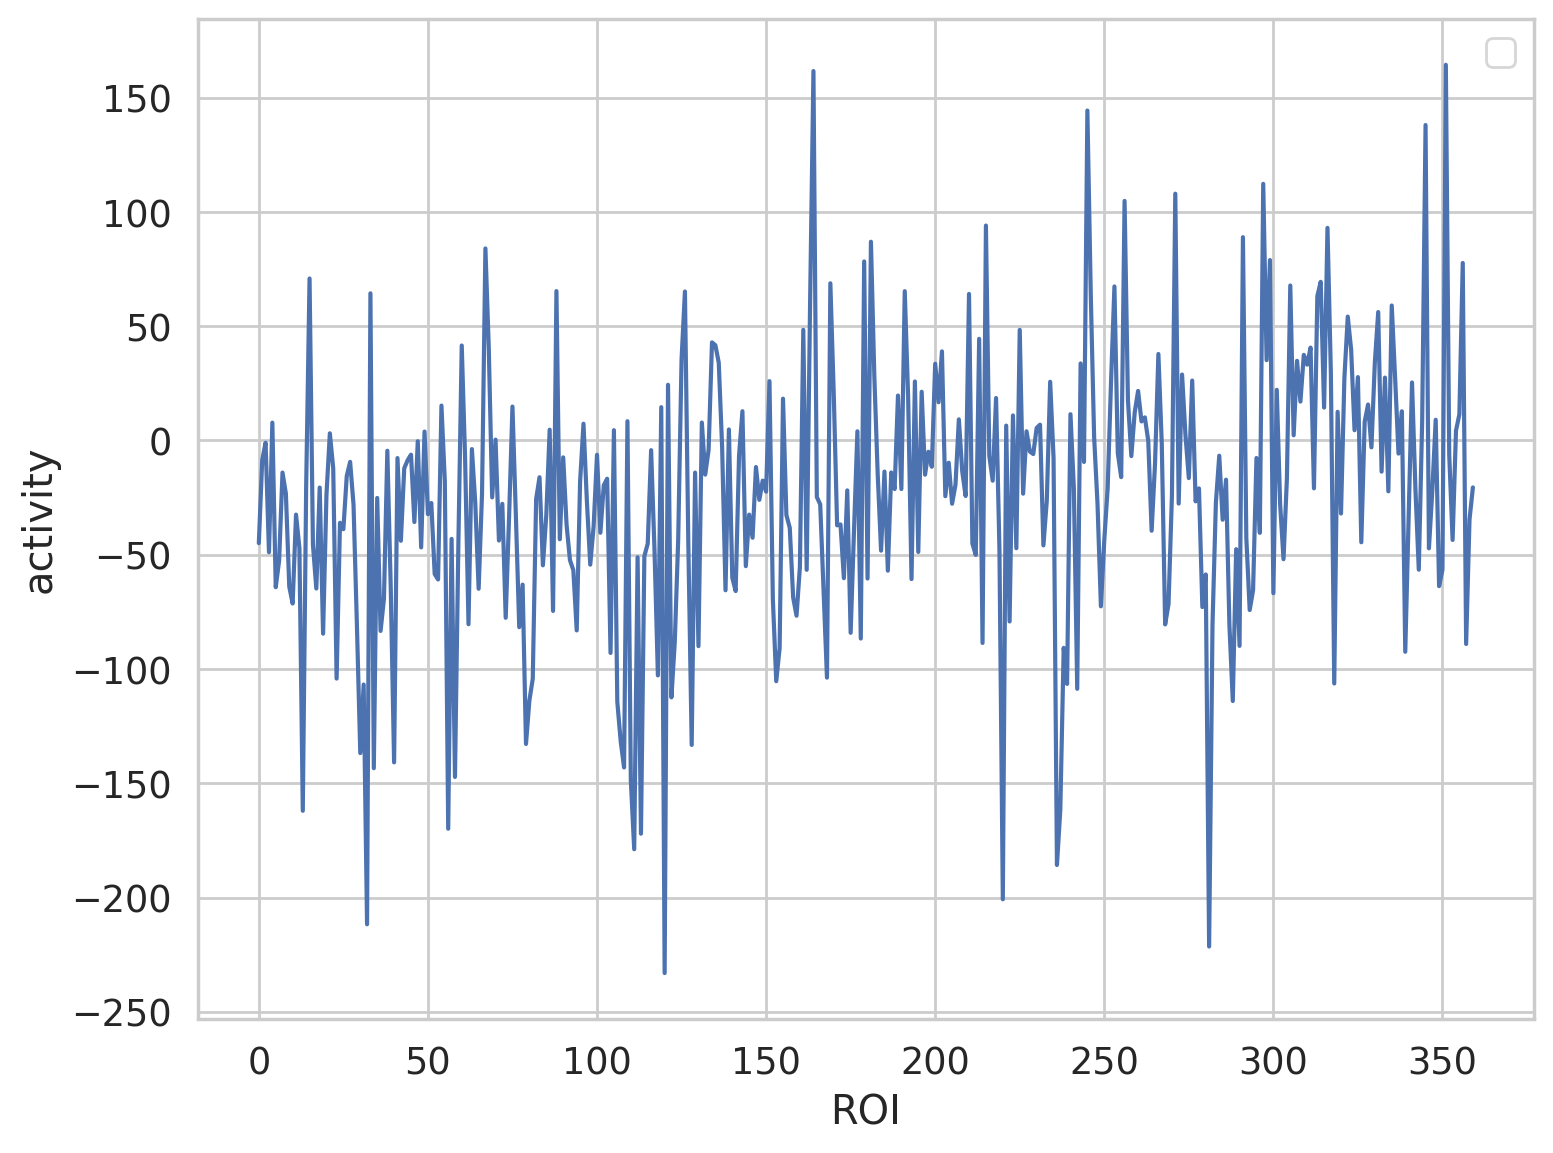

In [29]:
# one sample test
plt.plot(all_data_dictionary[list(all_data_dictionary.keys())[0]][test][0])
plt.xlabel('ROI')
plt.ylabel('activity')
plt.legend()
plt.show()

# extract specific times from serie

In [32]:
import os

def extract_2bk_data(wm_path):
    all_dict = {}
    for root, dirs, files in os.walk(wm_path):
        for file in files:
            result = []
            if file.startswith("2bk") and file.endswith(".txt"):
                file_path = os.path.join(root, file)
                with open(file_path, 'r') as f:
                    for line in f:
                        parts = line.strip().split()
                        if len(parts) >= 2:
                            try:
                                first = float(parts[0])
                                second = float(parts[1])
                                result.append((first, second))
                            except ValueError:
                                continue
                all_dict[file.replace("2bk_", "").replace(".txt", "")] = result
    return all_dict


all_users_data = {}
for item in subjects:
  subject_path = os.path.join(os.path.join(HCP_DIR + "/subjects", str(item)), "WM/tfMRI_WM_LR/EVs")
  data = extract_2bk_data(subject_path)
  all_users_data[item] = data
print(subject_path)

hcp_task/subjects/205119/WM/tfMRI_WM_LR/EVs


In [33]:
my_exp = 'WM'
my_subj = "100307"
my_run = 1

load_evs_ours("100307", "WM", 1)
data = load_single_timeseries(subject=my_subj,
                              experiment=my_exp,
                              run=my_run,
                              remove_mean=True)
print(data.shape)
print(data)

(360, 405)
[[ 50.19921191   1.34838897 -54.23134606 ... -60.53749034 -52.94961708
  -12.77754168]
 [-69.69155496 -42.04106153 -73.35811026 ... -67.48801877 -20.14024688
   10.34704496]
 [ 49.5032546   66.97627607  51.6482781  ... -22.07037662  50.26181342
   -7.53944421]
 ...
 [ 46.31084504  85.92061817 -12.88382143 ...  -6.43644312  70.13928554
   71.26116054]
 [ 54.04311812 -42.11979997 -67.97955644 ... -17.81967485 -97.6609453
  -11.924312  ]
 [112.01146257 -13.36949782   4.00403733 ...  68.93746271  87.78902521
  138.94414711]]


In [34]:
for user, data in all_users_data.items():
  for user_test, test_data in data.items():
    for item in test_data:
      starting_time = item[0]
      duration = item[1]



In [35]:
import os

def get_folder_structure(path):
    output = []
    for root, dirs, files in os.walk(path):
        level = root.replace(path, '').count(os.sep)
        indent = '    ' * level
        output.append(f"{indent}[{os.path.basename(root)}]")
        for f in files:
            output.append(f"{indent}    {f}")
    return '\n'.join(output)

# Replace this with your actual path
path = '/content/hcp_task/subjects/100307'
print(get_folder_structure(path))

[100307]
    [WM]
        [tfMRI_WM_RL]
            data.npy
            [EVs]
                0bk_places.txt
                all_bk_err.txt
                0bk_nlr.txt
                0bk_body.txt
                0bk_err.txt
                2bk_faces.txt
                all_bk_cor.txt
                2bk_err.txt
                2bk_nlr.txt
                Stats.txt
                Sync.txt
                2bk_tools.txt
                2bk_places.txt
                2bk_cor.txt
                0bk_tools.txt
                0bk_faces.txt
                0bk_cor.txt
                2bk_body.txt
        [tfMRI_WM_LR]
            data.npy
            [EVs]
                0bk_places.txt
                all_bk_err.txt
                0bk_nlr.txt
                0bk_body.txt
                0bk_err.txt
                2bk_faces.txt
                all_bk_cor.txt
                2bk_err.txt
                2bk_nlr.txt
                Stats.txt
                Sync.txt
                2bk_tool

# **MY CODE**

# **BETWEEN NETWORK ANALYSIS**

In [9]:
print(region_info.keys())

dict_keys(['name', 'network', 'hemi'])


In [10]:
np.unique(region_info['network'])


array(['Auditory', 'Cingulo-Oper', 'Default', 'Dorsal-atten',
       'Frontopariet', 'Language', 'Orbito-Affec', 'Posterior-Mu',
       'Somatomotor', 'Ventral-Mult', 'Visual1', 'Visual2'], dtype='<U12')

In [11]:
from pathlib import Path


def load_evs(subject, experiment, run):
   frames_list = []
   task_key = f'tfMRI_{experiment}_{RUNS[run]}'
   # Load time series to get number of timepoints
   try:
       ts = load_single_timeseries(subject, experiment, run, remove_mean=False)
       n_timepoints = ts.shape[1]
   except Exception as e:
       print(f"Error loading time series for {subject}/{experiment}/{task_key} to clip frames: {e}")
       return None


   for cond in EXPERIMENTS[experiment]['cond']:
       ev_file  = f"{HCP_DIR}/subjects/{subject}/{experiment}/{task_key}/EVs/{cond}.txt"
       try:
           ev_array = np.loadtxt(ev_file, ndmin=2, unpack=True)
           ev = dict(zip(["onset", "duration", "amplitude"], ev_array))
           # Determine when trial starts, rounded down
           start = np.floor(ev["onset"] / TR).astype(int)
           # Use trial duration to determine how many frames to include for trial
           duration = np.ceil(ev["duration"] / TR).astype(int)
           # Take the range of frames that correspond to this specific trial
           frames = [s + np.arange(0, d) for s, d in zip(start, duration)]
           # Clip frames to valid timepoints
           clipped_frames = []
           for frame in frames:
               valid_frames = frame[frame < n_timepoints]
               if len(valid_frames) > 0:
                   clipped_frames.append(valid_frames)
           frames_list.append(clipped_frames if clipped_frames else [])
       except Exception as e:
           print(f"Error loading EV file {ev_file}: {e}")
           frames_list.append([])


   return frames_list


def concatenate_task_data(task, condition):
   """
   Concatenate condition-specific frames from data.npy files for all subjects for a specific task and condition.
   Extract frames using load_evs, concatenate across runs (LR and RL), truncate to minimum frame count
   across subjects, and stack into a design matrix.

   Args:
       task (str): Task name (e.g., 'SOCIAL', 'WM')
       condition (str): Condition name (e.g., 'mental', '0bk_body')

   Returns:
       task_cond_array (array): Array of shape (n_subjects, n_parcels, n_condition_timepoints)
                               or None if no data is concatenated
   """
   # Validate inputs
   if task not in EXPERIMENTS:
       print(f"Invalid task: {task}. Must be one of {list(EXPERIMENTS.keys())}.")
       return None
   if condition not in EXPERIMENTS[task]['cond']:
       print(f"Invalid condition: {condition} for task {task}. Must be one of {EXPERIMENTS[task]['cond']}.")
       return None

   task_data = []
   frame_counts = []

   # Iterate through subjects
   for subject in subjects:
       subject_folder = Path(HCP_DIR) / "subjects" / subject
       if not subject_folder.is_dir():
           print(f"Subject directory {subject_folder} does not exist. Skipping.")
           continue

       task_folder = subject_folder / task
       if not task_folder.is_dir():
           print(f"Task directory {task_folder} does not exist for subject {subject}. Skipping.")
           continue

       # Load time series and EV frames for both runs
       subject_task_data = []
       subject_frames = []
       for run_idx, run_suffix in enumerate(RUNS):
           try:
               # Load time series
               ts = load_single_timeseries(subject, task, run_idx, remove_mean=False)
               subject_task_data.append(ts)
               # Load EV frames
               frames_list = load_evs(subject, task, run_idx)
               if frames_list is None:
                   raise Exception("EV frames are None")
               subject_frames.append(frames_list)
           except Exception as e:
               print(f"Error loading data or EVs for {subject}/{task}/tfMRI_{task}_{run_suffix}: {e}")
               subject_task_data.append(None)
               subject_frames.append(None)

       # Check if any run failed to load
       if any(x is None for x in subject_task_data) or any(x is None for x in subject_frames):
           print(f"Skipping subject {subject} for task {task} due to missing data or EV frames.")
           continue

       # Get index of condition in EXPERIMENTS[task]['cond']
       cond_idx = EXPERIMENTS[task]['cond'].index(condition)

       try:
           # Concatenate frames for this condition across runs
           cond_frames = []
           for run_idx, run_frames in enumerate(subject_frames):
               # Flatten the frame list for this condition and adjust for run concatenation
               run_cond_frames = np.concatenate(run_frames[cond_idx]).astype(int) if run_frames[cond_idx] else np.array([])
               if run_idx == 1 and subject_task_data[0] is not None and len(run_cond_frames) > 0:
                   # Offset RL frames by the number of timepoints in LR
                   run_cond_frames += subject_task_data[0].shape[1]
               cond_frames.append(run_cond_frames)

           # Combine frames from both runs
           all_cond_frames = np.concatenate(cond_frames) if cond_frames and any(len(f) > 0 for f in cond_frames) else np.array([])

           # Skip if no valid frames
           if len(all_cond_frames) == 0:
               print(f"No valid frames for {subject}/{task}/{condition}. Skipping.")
               continue

           # Concatenate time series for LR and RL runs
           concatenated_ts = np.concatenate(subject_task_data, axis=1)

           # Ensure frames are within bounds
           max_timepoints = concatenated_ts.shape[1]
           valid_frames = all_cond_frames[all_cond_frames < max_timepoints]
           if len(valid_frames) == 0:
               print(f"No valid frames after clipping for {subject}/{task}/{condition}. Skipping.")
               continue

           # Extract condition-specific timepoints
           cond_ts = concatenated_ts[:, valid_frames]
           task_data.append(cond_ts)
           frame_counts.append(len(valid_frames))
       except Exception as e:
           print(f"Error processing condition {condition} for {subject}/{task}: {e}")
           continue

   # Stack subject arrays, truncating to minimum frame count
   if not task_data:
       print(f"No data concatenated for task {task}, condition {condition}.")
       return None
   try:
       # Find minimum number of frames across subjects
       min_frames = min(frame_counts) if frame_counts else 0
       if min_frames == 0:
           print(f"No valid frames for task {task}, condition {condition}.")
           return None

       # Truncate each subject's data to min_frames
       truncated_data = [data[:, :min_frames] for data in task_data]

       # Stack along a new axis (0) to get (n_subjects, n_parcels, n_condition_timepoints)
       task_cond_array = np.stack(truncated_data, axis=0)
       print(f"Task {task}, Condition {condition}: Concatenated array shape {task_cond_array.shape}")
       return task_cond_array
   except Exception as e:
       print(f"Error stacking subjects for task {task}, condition {condition}: {e}")
       return None






# Example: Concatenate data for a specific task and condition
task = "SOCIAL"
condition = "mental"
result = concatenate_task_data(task, condition)
if result is not None:
   print(f"\n=== Concatenated Data for {task} - {condition} ===")
   print(f"Shape: {result.shape}")




Invalid condition: mental for task SOCIAL. Must be one of ['ment', 'rnd'].


In [13]:
def load_single_timeseries(subject, experiment, run, remove_mean=True):
  """Load timeseries data for a single subject and single run.

  Args:
    subject (str):      subject ID to load
    experiment (str):   Name of experiment
    run (int):          (0 or 1)
    remove_mean (bool): If True, subtract the parcel-wise mean (typically the mean BOLD signal is not of interest)

  Returns
    ts (n_parcel x n_timepoint array): Array of BOLD data values

  """
  bold_run  = RUNS[run]
  bold_path = f"{HCP_DIR}/subjects/{subject}/{experiment}/tfMRI_{experiment}_{bold_run}"
  bold_file = "data.npy"
  ts = np.load(f"{bold_path}/{bold_file}")
  if remove_mean:
    ts -= ts.mean(axis=1, keepdims=True)
  return ts



def load_evs_ours(subject, experiment, run):
  """Load EVs (explanatory variables) data for one task experiment.

  Args:
    subject (str): subject ID to load
    experiment (str) : Name of experiment
    run (int): 0 or 1

  Returns
    evs (list of lists): A list of frames associated with each condition

  """
  frames_list = {}
  task_key = f'tfMRI_{experiment}_{RUNS[run]}'
  for cond in EXPERIMENTS[experiment]['cond']:
    if "2bk" in cond:
      # import pdb;pdb.set_trace()
      ev_file  = f"{HCP_DIR}/subjects/{subject}/{experiment}/{task_key}/EVs/{cond}.txt"
      ev_array = np.loadtxt(ev_file, ndmin=2, unpack=True)
      ev       = dict(zip(["onset", "duration", "amplitude"], ev_array))
      # Determine when trial starts, rounded down
      start = np.floor(ev["onset"] / TR).astype(int)
      # Use trial duration to determine how many frames to include for trial
      duration = np.ceil(ev["duration"] / TR).astype(int)
      # Take the range of frames that correspond to this specific trial
      frames = [s + np.arange(0, d) for s, d in zip(start, duration)]
      frames_list[cond] = frames
      # print(f"this is cond:{cond}, and this is frames:{frames}")

  return frames_list
load_evs_ours("100307", "WM", 1)

{'2bk_body': [array([14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30,
         31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47,
         48, 49, 50, 51, 52])],
 '2bk_faces': [array([251, 252, 253, 254, 255, 256, 257, 258, 259, 260, 261, 262, 263,
         264, 265, 266, 267, 268, 269, 270, 271, 272, 273, 274, 275, 276,
         277, 278, 279, 280, 281, 282, 283, 284, 285, 286, 287, 288, 289])],
 '2bk_places': [array([350, 351, 352, 353, 354, 355, 356, 357, 358, 359, 360, 361, 362,
         363, 364, 365, 366, 367, 368, 369, 370, 371, 372, 373, 374, 375,
         376, 377, 378, 379, 380, 381, 382, 383, 384, 385, 386, 387, 388])],
 '2bk_tools': [array([113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125,
         126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138,
         139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151])]}

In [14]:
tasks = {
    "BP_ACC":    "2bk_body",
    "FACES_ACC": "2bk_faces",
    "PLACES_ACC":"2bk_places",
    "TOOLS_ACC": "2bk_tools"
}

# Network labels: numpy array with 360 labels, values 1..12 (یا هر شبکه‌ای)
network_labels = region_info['network']
unique_networks = np.unique(network_labels)
num_networks = len(unique_networks)

# دیکشنری برای ذخیره خروجی‌ها
network_activity = {}

for task_name, condition in tasks.items():
    # Example: Concatenate data for each condition
    result = concatenate_task_data("WM", condition)
    if result is None:
        print(f"Warning: Data for {condition} not found!")
        continue

    print(f"\n=== {task_name} ({condition}) ===")
    print(f"Raw Data Shape: {result.shape}")

    num_subjects, num_rois, num_frames = result.shape
    task_activity = np.zeros((num_subjects, num_networks, num_frames))

    for net_idx, network in enumerate(unique_networks):
        roi_indices = np.where(network_labels == network)[0]
        # Average over ROIs in this network
        network_data = result[:, roi_indices, :]  # (subjects, #ROIs_in_network, frames)
        task_activity[:, net_idx, :] = np.mean(network_data, axis=1)  # (subjects, frames)

    # Save for later modeling
    network_activity[task_name] = task_activity

    print(f"Network-Averaged Shape: {task_activity.shape}  # should be (subjects, 12, frames)")


Task WM, Condition 2bk_body: Concatenated array shape (100, 360, 78)

=== BP_ACC (2bk_body) ===
Raw Data Shape: (100, 360, 78)
Network-Averaged Shape: (100, 12, 78)  # should be (subjects, 12, frames)
Task WM, Condition 2bk_faces: Concatenated array shape (100, 360, 78)

=== FACES_ACC (2bk_faces) ===
Raw Data Shape: (100, 360, 78)
Network-Averaged Shape: (100, 12, 78)  # should be (subjects, 12, frames)
Task WM, Condition 2bk_places: Concatenated array shape (100, 360, 78)

=== PLACES_ACC (2bk_places) ===
Raw Data Shape: (100, 360, 78)
Network-Averaged Shape: (100, 12, 78)  # should be (subjects, 12, frames)
Task WM, Condition 2bk_tools: Concatenated array shape (100, 360, 78)

=== TOOLS_ACC (2bk_tools) ===
Raw Data Shape: (100, 360, 78)
Network-Averaged Shape: (100, 12, 78)  # should be (subjects, 12, frames)


In [15]:
network_FC = {}

for task in ['BP_ACC', 'FACES_ACC', 'PLACES_ACC', 'TOOLS_ACC']:
    activity = network_activity[task]   # shape: (subjects, 12, frames)
    num_subjects, num_networks, num_frames = activity.shape
    FC_matrices = np.zeros((num_subjects, num_networks, num_networks))  # (subjects, 12, 12)

    for subj in range(num_subjects):
        mat = activity[subj]            # (12, frames)
        fc = np.corrcoef(mat)           # (12, 12)
        FC_matrices[subj] = fc

    network_FC[task] = FC_matrices
    print(f"{task} FC Matrix shape:", FC_matrices.shape)


BP_ACC FC Matrix shape: (100, 12, 12)
FACES_ACC FC Matrix shape: (100, 12, 12)
PLACES_ACC FC Matrix shape: (100, 12, 12)
TOOLS_ACC FC Matrix shape: (100, 12, 12)


In [16]:
z_FC_flat = {}

for task in ['BP_ACC', 'FACES_ACC', 'PLACES_ACC', 'TOOLS_ACC']:
    fc = network_FC[task]  # shape: (subjects, 12, 12)
    # Fisher z-transform with clipping to avoid inf/non-valid values
    z_fc = np.arctanh(np.clip(fc, -0.999999, 0.999999))
    # Flatten
    z_fc_flat = z_fc.reshape((z_fc.shape[0], -1))  # shape: (subjects, 144)
    z_FC_flat[task] = z_fc_flat
    print(f"{task}: Z-transformed & flattened FC shape:", z_fc_flat.shape)


BP_ACC: Z-transformed & flattened FC shape: (100, 144)
FACES_ACC: Z-transformed & flattened FC shape: (100, 144)
PLACES_ACC: Z-transformed & flattened FC shape: (100, 144)
TOOLS_ACC: Z-transformed & flattened FC shape: (100, 144)


In [17]:
# تعریف اندیس‌های upper triangle بدون قطر
inds = np.triu_indices(12, k=1)  # برای ۱۲ شبکه

z_FC_upper = {}

for task in ['BP_ACC', 'FACES_ACC', 'PLACES_ACC', 'TOOLS_ACC']:
    fc = network_FC[task]  # shape: (subjects, 12, 12)
    # Fisher z-transform با clipping
    z_fc = np.arctanh(np.clip(fc, -0.999999, 0.999999))
    # استخراج upper triangle
    z_fc_upper = z_fc[:, inds[0], inds[1]]   # shape: (subjects, 66)
    z_FC_upper[task] = z_fc_upper
    print(f"{task}: upper triangle z-FC features shape:", z_fc_upper.shape)


BP_ACC: upper triangle z-FC features shape: (100, 66)
FACES_ACC: upper triangle z-FC features shape: (100, 66)
PLACES_ACC: upper triangle z-FC features shape: (100, 66)
TOOLS_ACC: upper triangle z-FC features shape: (100, 66)


In [18]:
import os
import numpy as np
import pandas as pd
import re

def parse_2back_accuracies(stats_file_path):
    acc_dict = {"BP_ACC": None, "FACES_ACC": None, "PLACES_ACC": None, "TOOLS_ACC": None}
    try:
        with open(stats_file_path, 'r', encoding='utf-8') as f:
            text = f.read()
        acc_dict["BP_ACC"]     = float(re.search(r'2[\-\s]Back\s*BP\s*Median\s*ACC:\s*([0-9\.]+)', text).group(1))
        acc_dict["FACES_ACC"]  = float(re.search(r'2[\-\s]Back\s*Faces\s*Median\s*ACC:\s*([0-9\.]+)', text).group(1))
        acc_dict["PLACES_ACC"] = float(re.search(r'2[\-\s]Back\s*Places\s*Median\s*ACC:\s*([0-9\.]+)', text).group(1))
        acc_dict["TOOLS_ACC"]  = float(re.search(r'2[\-\s]Back\s*Tools\s*Median\s*ACC:\s*([0-9\.]+)', text).group(1))
    except Exception as e:
        print(f"Failed to parse accuracies from {stats_file_path}: {e}")
    return acc_dict

root_dir = '/content/hcp_task/subjects'
runs = ['tfMRI_WM_LR', 'tfMRI_WM_RL']

subject_list = [s for s in os.listdir(root_dir) if os.path.isdir(os.path.join(root_dir, s))]
all_rows = []

for subj in subject_list:
    for run in runs:
        run_dir = os.path.join(root_dir, subj, 'WM', run)
        stats_fp = os.path.join(run_dir, 'EVs', 'Stats.txt')
        if not os.path.exists(stats_fp):
            print(f"Skipping {subj} {run} - missing stats ({stats_fp})")
            continue
        accs = parse_2back_accuracies(stats_fp)
        row = {'subject': subj, 'run': run}
        row.update(accs)
        all_rows.append(row)

df = pd.DataFrame(all_rows)
cols_first = [col for col in ['subject', 'run', 'BP_ACC', 'FACES_ACC', 'PLACES_ACC', 'TOOLS_ACC'] if col in df.columns]
df = df[cols_first]
df.to_csv('wm_2back_accuracies.csv', index=False)
print('Saved: wm_2back_accuracies.csv')
print(df.head())


Saved: wm_2back_accuracies.csv
  subject          run  BP_ACC  FACES_ACC  PLACES_ACC  TOOLS_ACC
0  111312  tfMRI_WM_LR     1.0        1.0         1.0        0.7
1  111312  tfMRI_WM_RL     0.7        0.6         0.9        0.9
2  111514  tfMRI_WM_LR     1.0        0.9         1.0        1.0
3  111514  tfMRI_WM_RL     1.0        1.0         1.0        1.0
4  161731  tfMRI_WM_LR     1.0        1.0         1.0        1.0


/tmp/ipython-input-3210636298.py:19: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(x='Condition', y='ACC', data=df_long, inner='box', cut=0, palette="Set2")


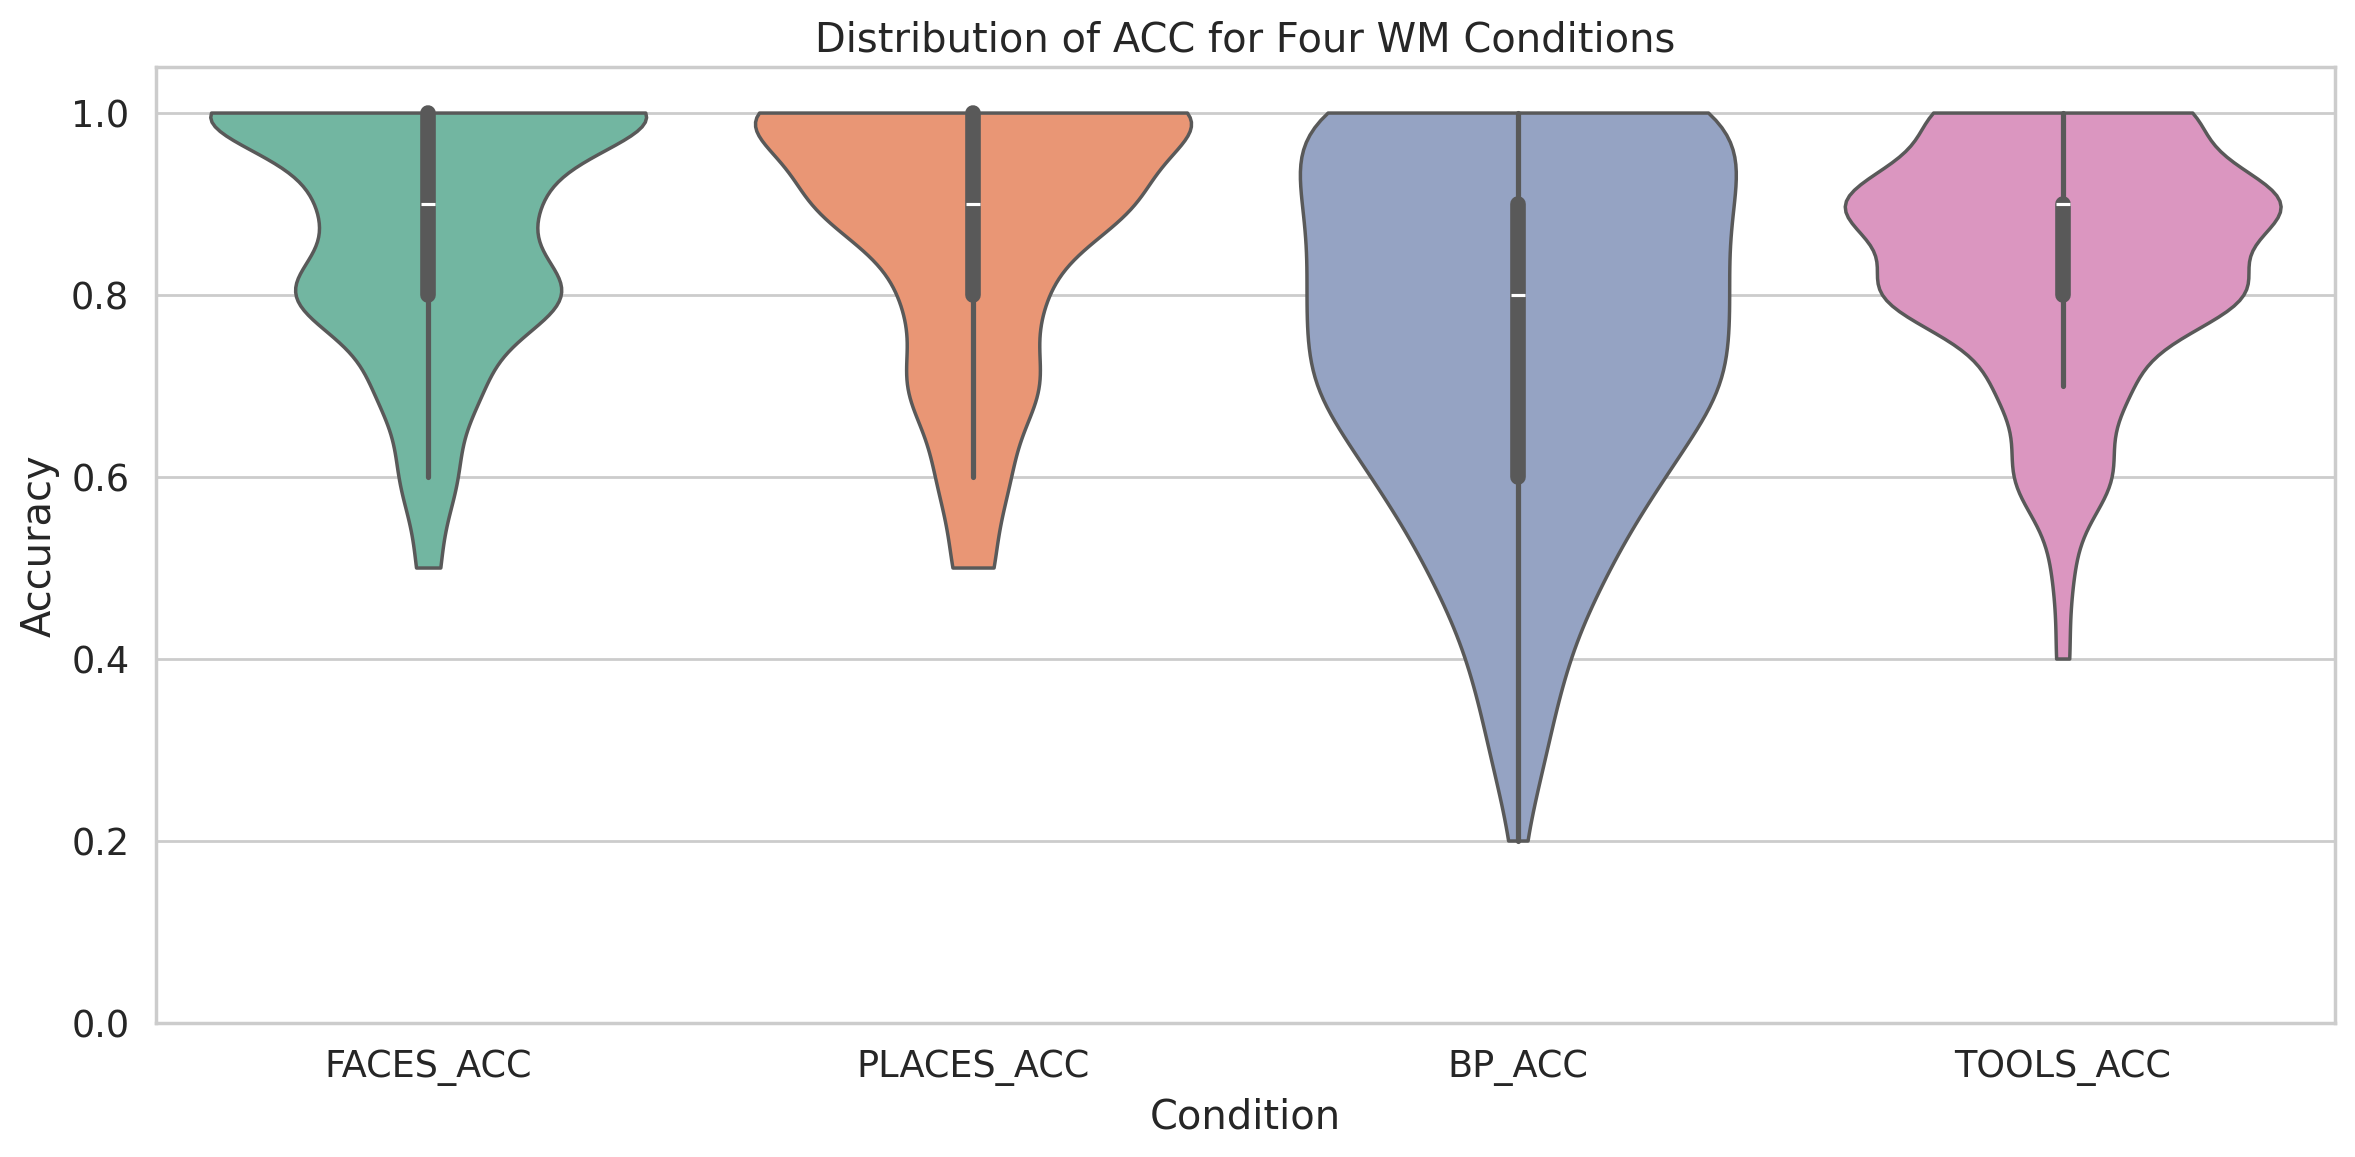

In [19]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

df_acc = pd.read_csv('wm_2back_accuracies.csv')

acc_cols = ['FACES_ACC', 'PLACES_ACC', 'BP_ACC', 'TOOLS_ACC']

plt.figure(figsize=(12, 6))
sns.set(style="whitegrid", font_scale=1.2)

df_long = df_acc.melt(value_vars=acc_cols,
                      var_name='Condition',
                      value_name='ACC')

sns.violinplot(x='Condition', y='ACC', data=df_long, inner='box', cut=0, palette="Set2")
plt.title('Distribution of ACC for Four WM Conditions')
plt.ylim(0, 1.05)
plt.ylabel('Accuracy')
plt.xlabel('Condition')

plt.tight_layout()
plt.show()



======= BP_ACC | Threshold method: median (thr: 0.775) =======
PCA n_components: 34 | Explained Var: 0.95
[SVM]               precision    recall  f1-score   support

           0      0.538     0.700     0.609        10
           1      0.571     0.400     0.471        10

    accuracy                          0.550        20
   macro avg      0.555     0.550     0.540        20
weighted avg      0.555     0.550     0.540        20
 Acc: 0.55, AUC: 0.66
[LR]               precision    recall  f1-score   support

           0      0.615     0.800     0.696        10
           1      0.714     0.500     0.588        10

    accuracy                          0.650        20
   macro avg      0.665     0.650     0.642        20
weighted avg      0.665     0.650     0.642        20
 Acc: 0.65, AUC: 0.76
[RF]               precision    recall  f1-score   support

           0      0.545     0.600     0.571        10
           1      0.556     0.500     0.526        10

    accuracy     

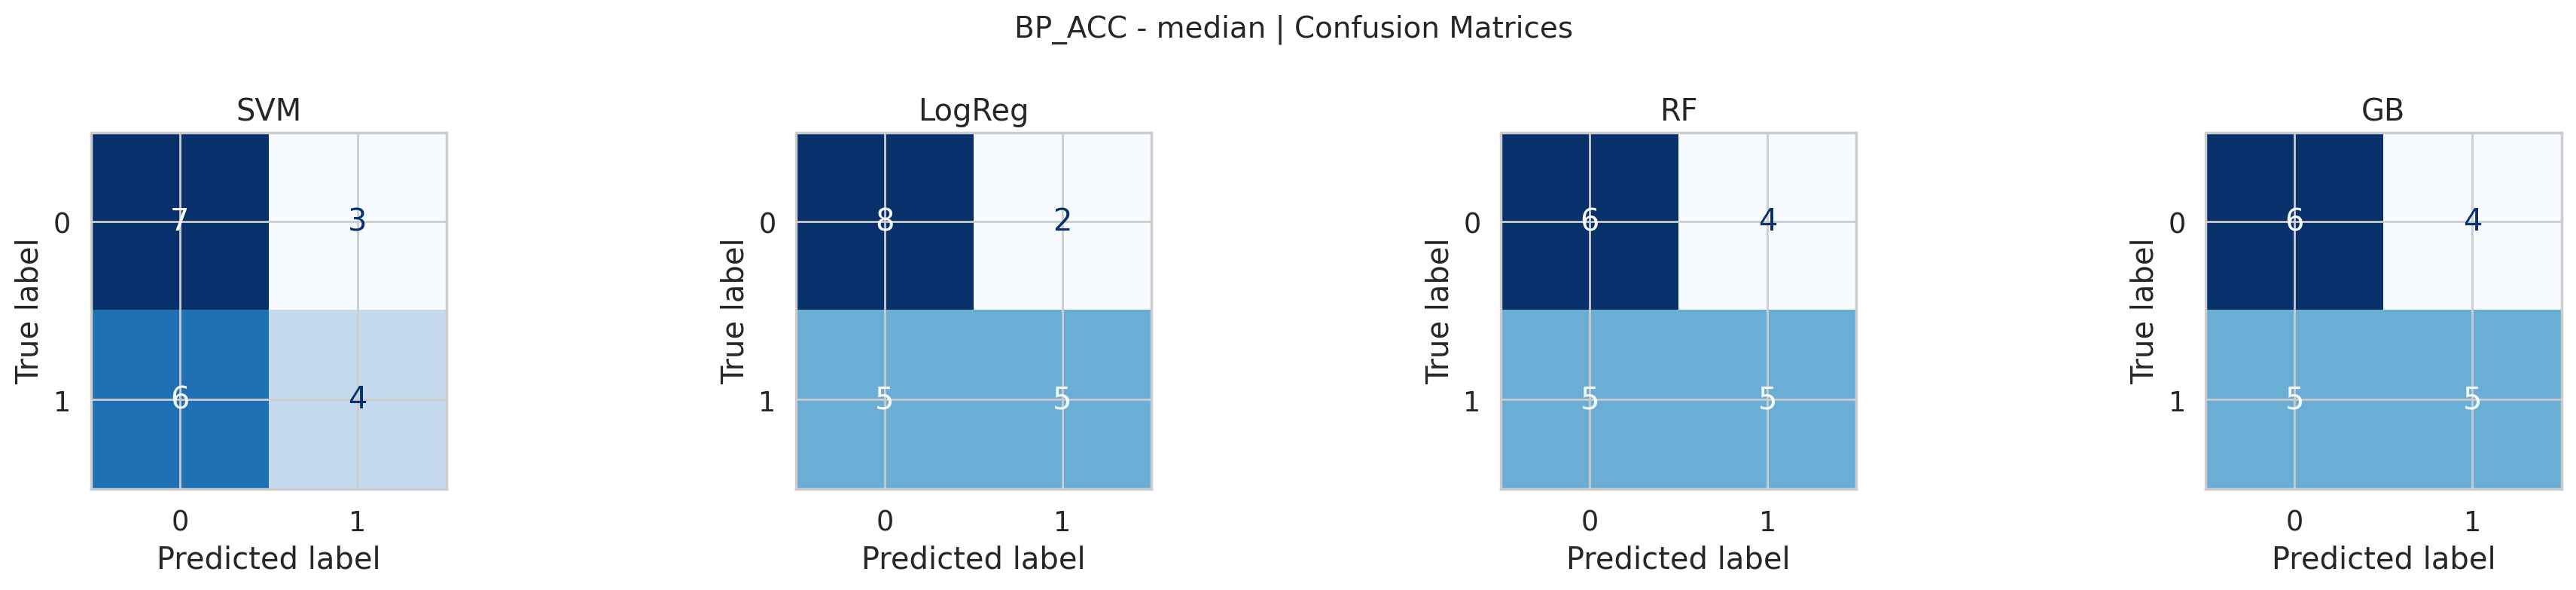

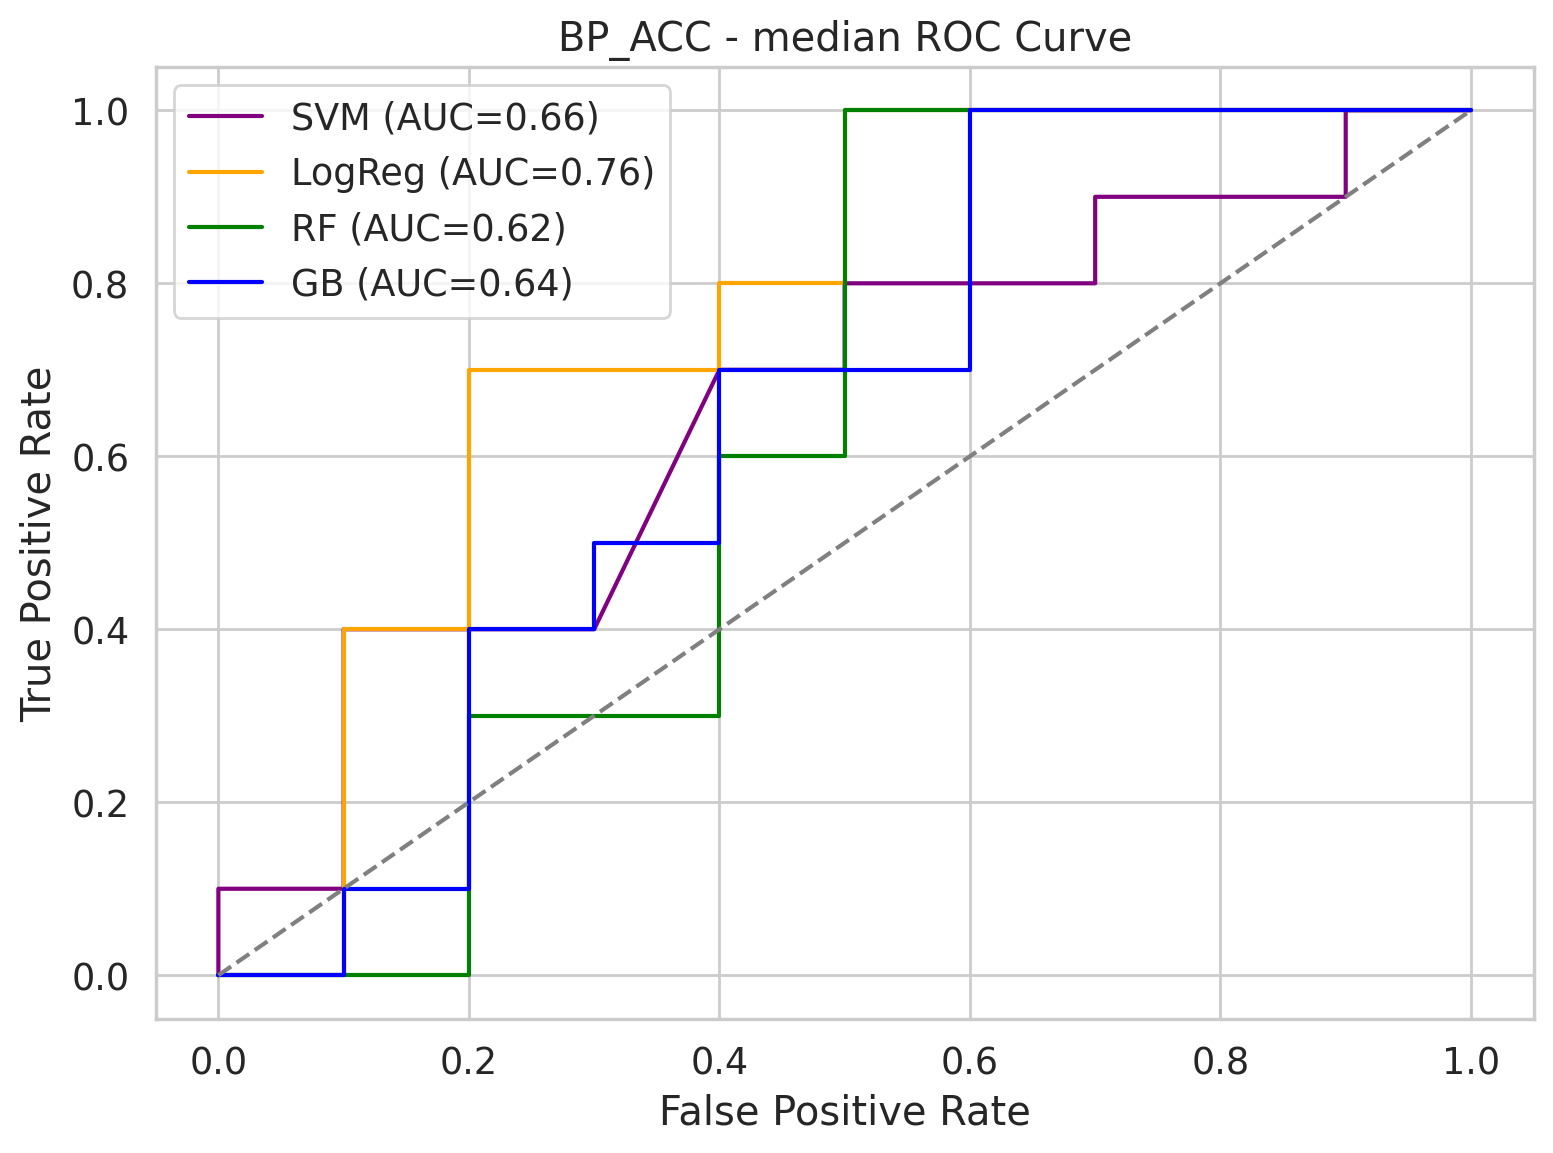


======= BP_ACC | Threshold method: percentile_67 (thr: 0.850) =======
PCA n_components: 34 | Explained Var: 0.95
[SVM]               precision    recall  f1-score   support

           0      0.818     0.692     0.750        13
           1      0.556     0.714     0.625         7

    accuracy                          0.700        20
   macro avg      0.687     0.703     0.688        20
weighted avg      0.726     0.700     0.706        20
 Acc: 0.70, AUC: 0.79
[LR]               precision    recall  f1-score   support

           0      0.818     0.692     0.750        13
           1      0.556     0.714     0.625         7

    accuracy                          0.700        20
   macro avg      0.687     0.703     0.688        20
weighted avg      0.726     0.700     0.706        20
 Acc: 0.70, AUC: 0.70
[RF]               precision    recall  f1-score   support

           0      0.800     0.923     0.857        13
           1      0.800     0.571     0.667         7

    accura

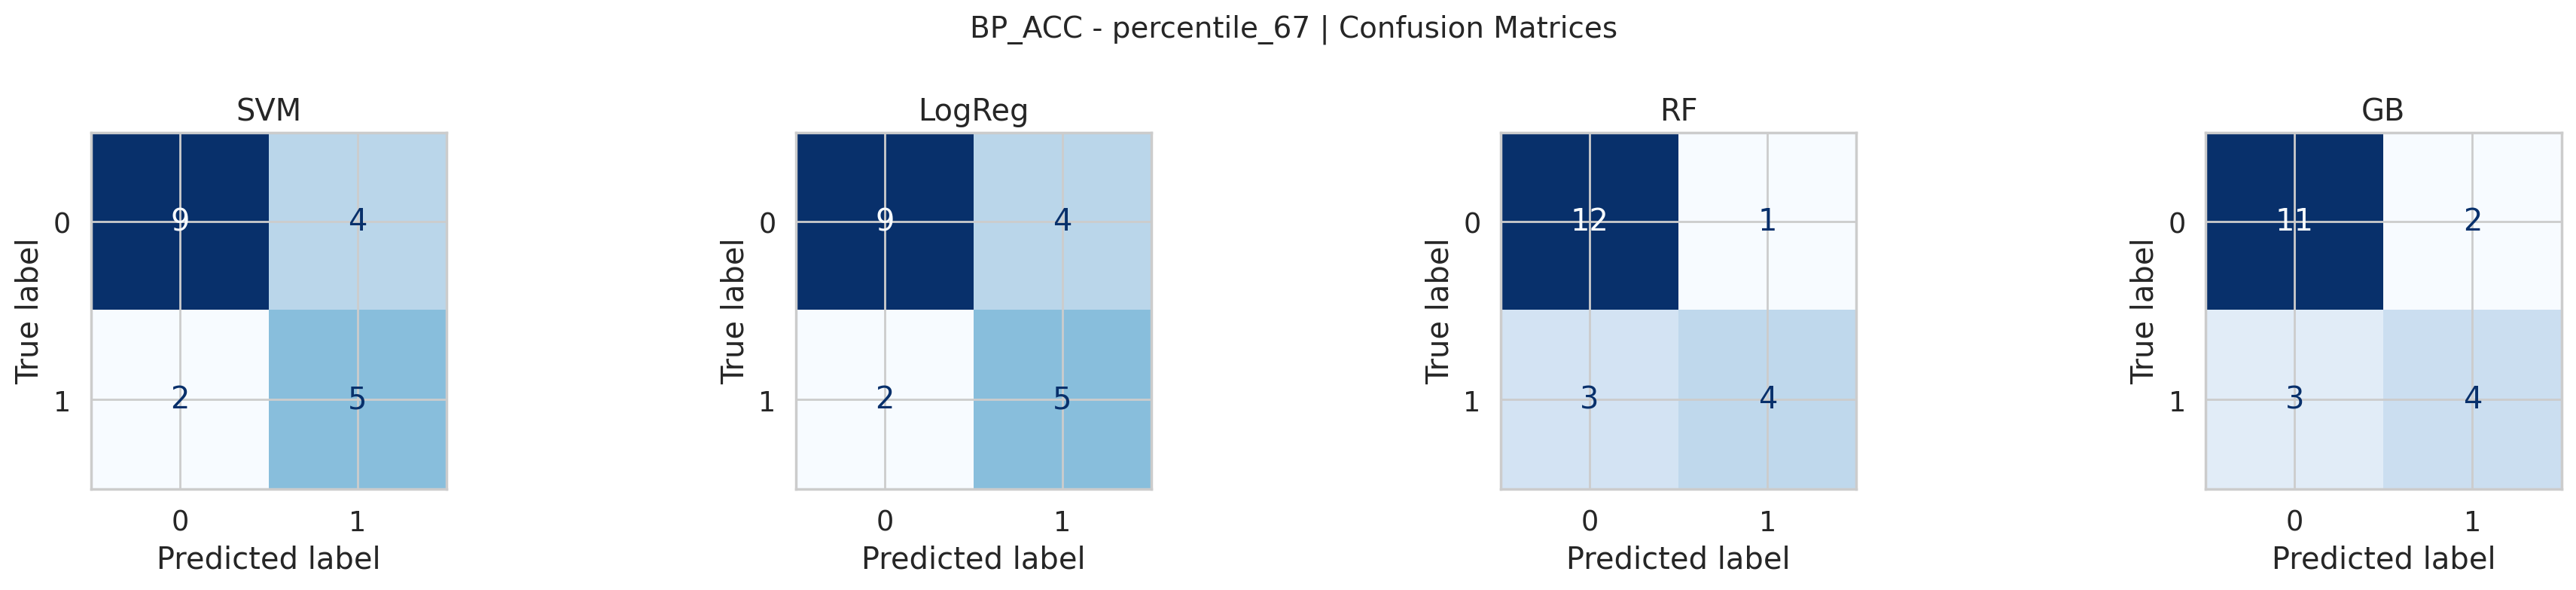

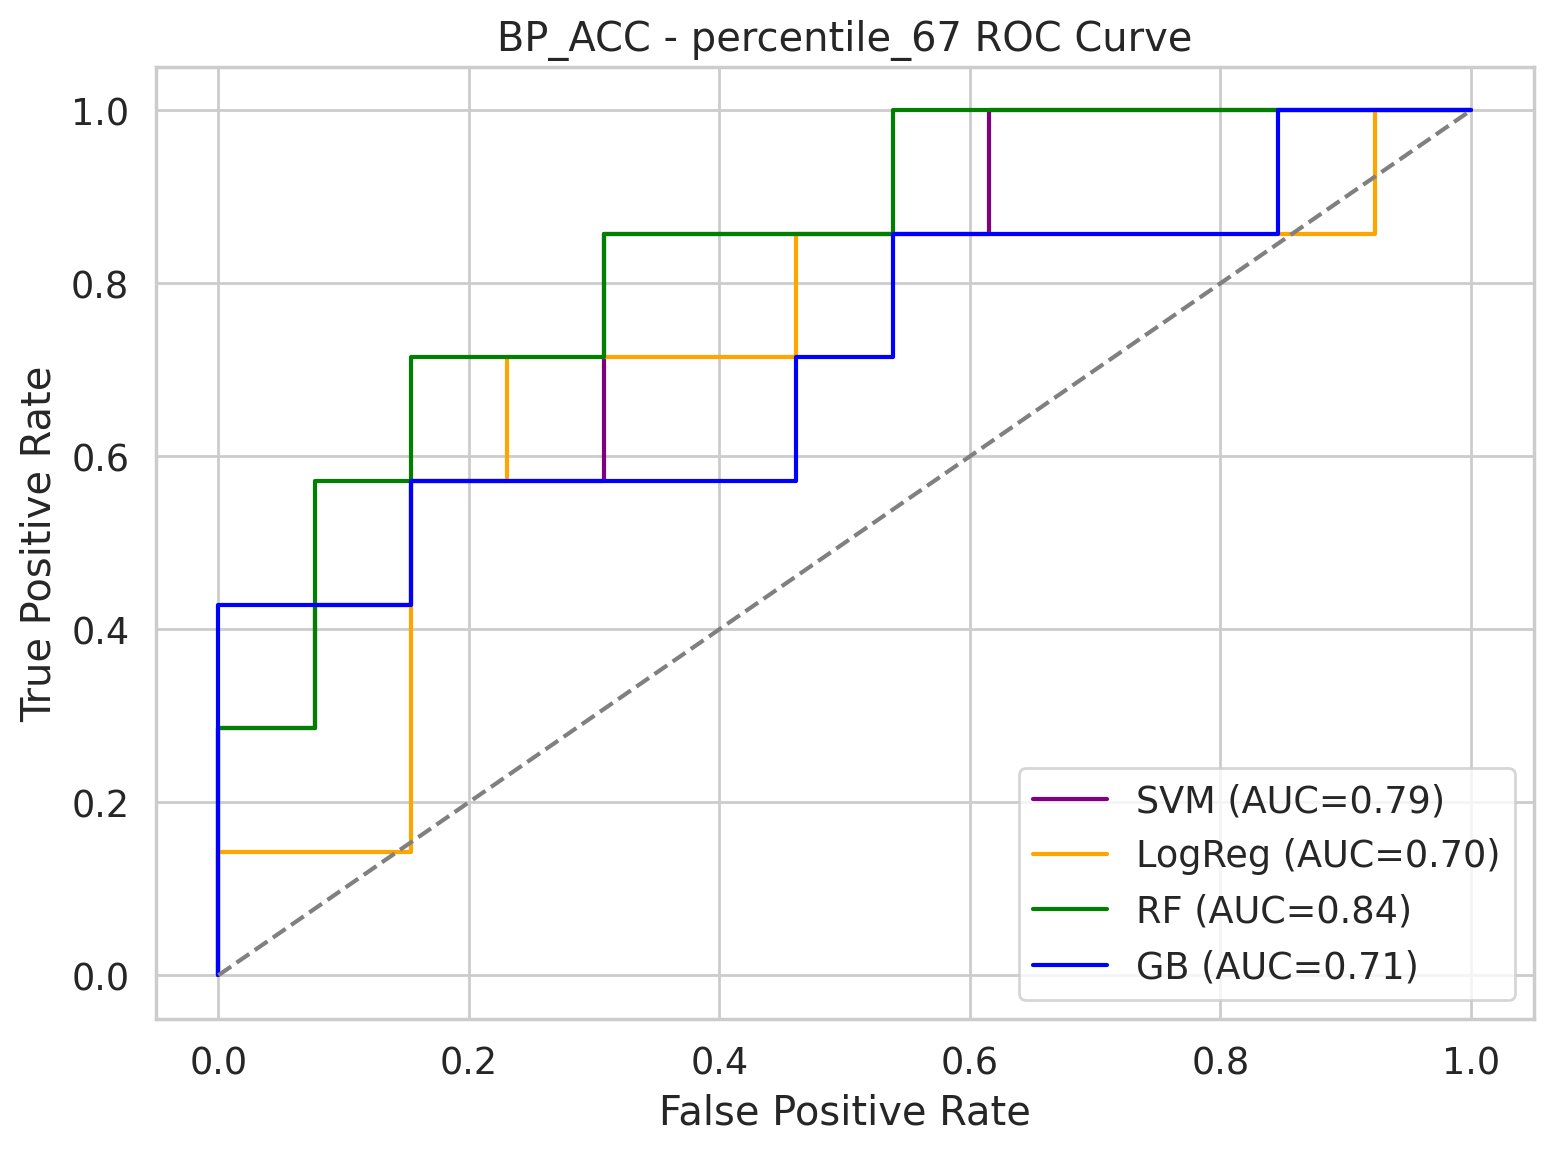


======= BP_ACC | Threshold method: gmm (thr: 0.764) =======
PCA n_components: 34 | Explained Var: 0.95
[SVM]               precision    recall  f1-score   support

           0      0.538     0.700     0.609        10
           1      0.571     0.400     0.471        10

    accuracy                          0.550        20
   macro avg      0.555     0.550     0.540        20
weighted avg      0.555     0.550     0.540        20
 Acc: 0.55, AUC: 0.66
[LR]               precision    recall  f1-score   support

           0      0.615     0.800     0.696        10
           1      0.714     0.500     0.588        10

    accuracy                          0.650        20
   macro avg      0.665     0.650     0.642        20
weighted avg      0.665     0.650     0.642        20
 Acc: 0.65, AUC: 0.76
[RF]               precision    recall  f1-score   support

           0      0.545     0.600     0.571        10
           1      0.556     0.500     0.526        10

    accuracy        

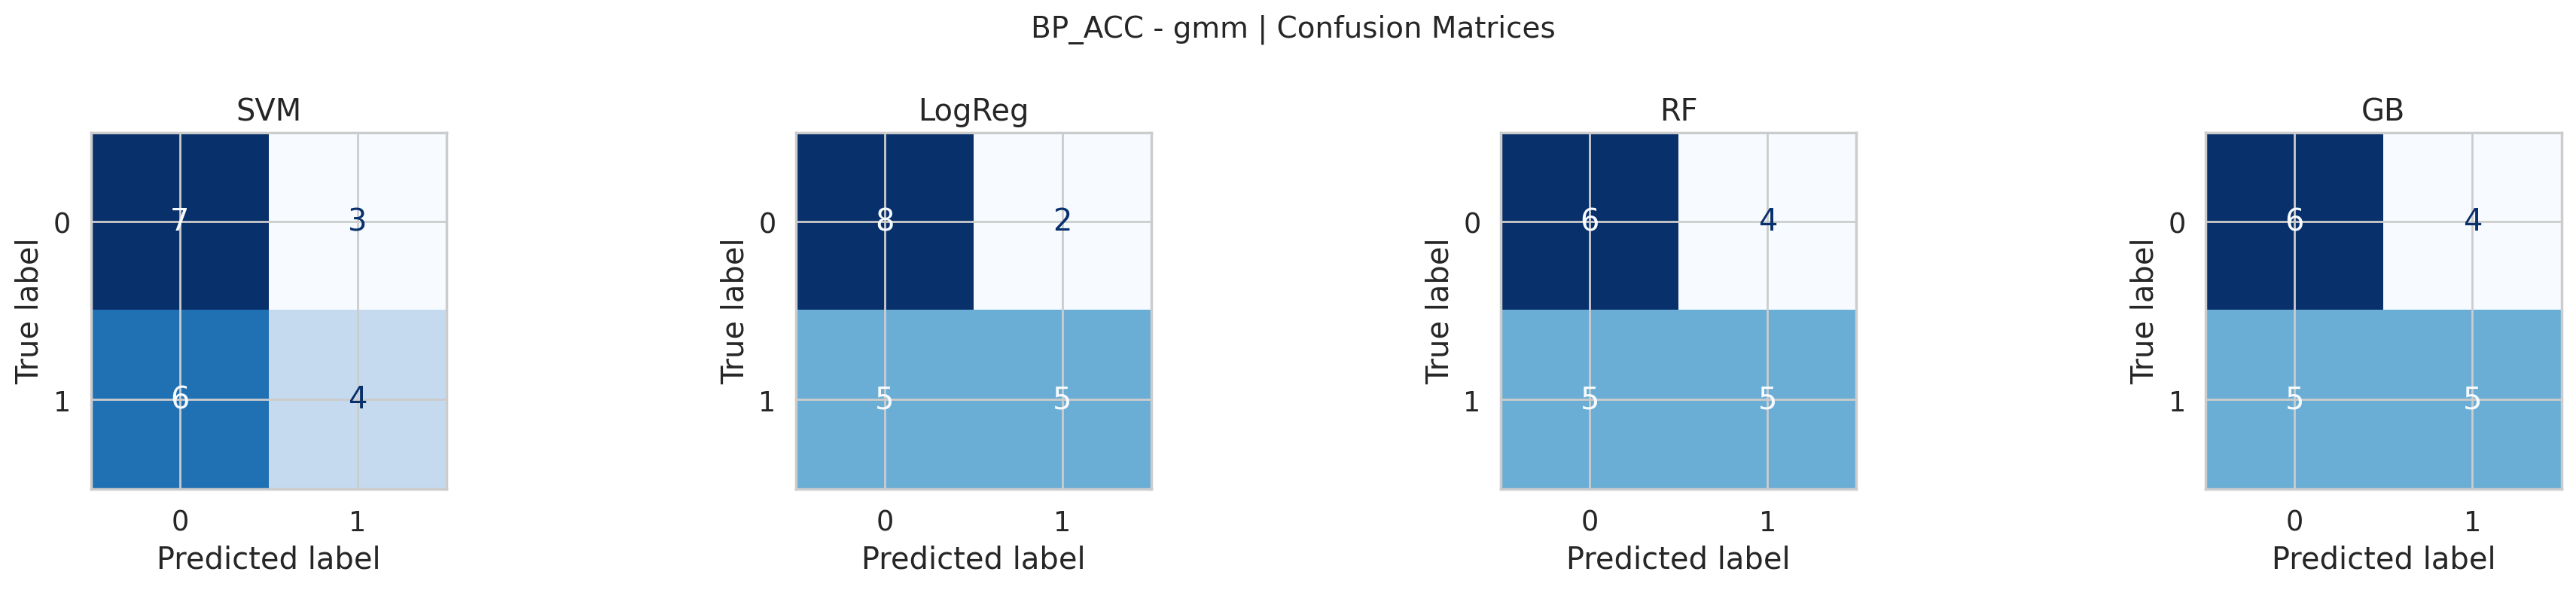

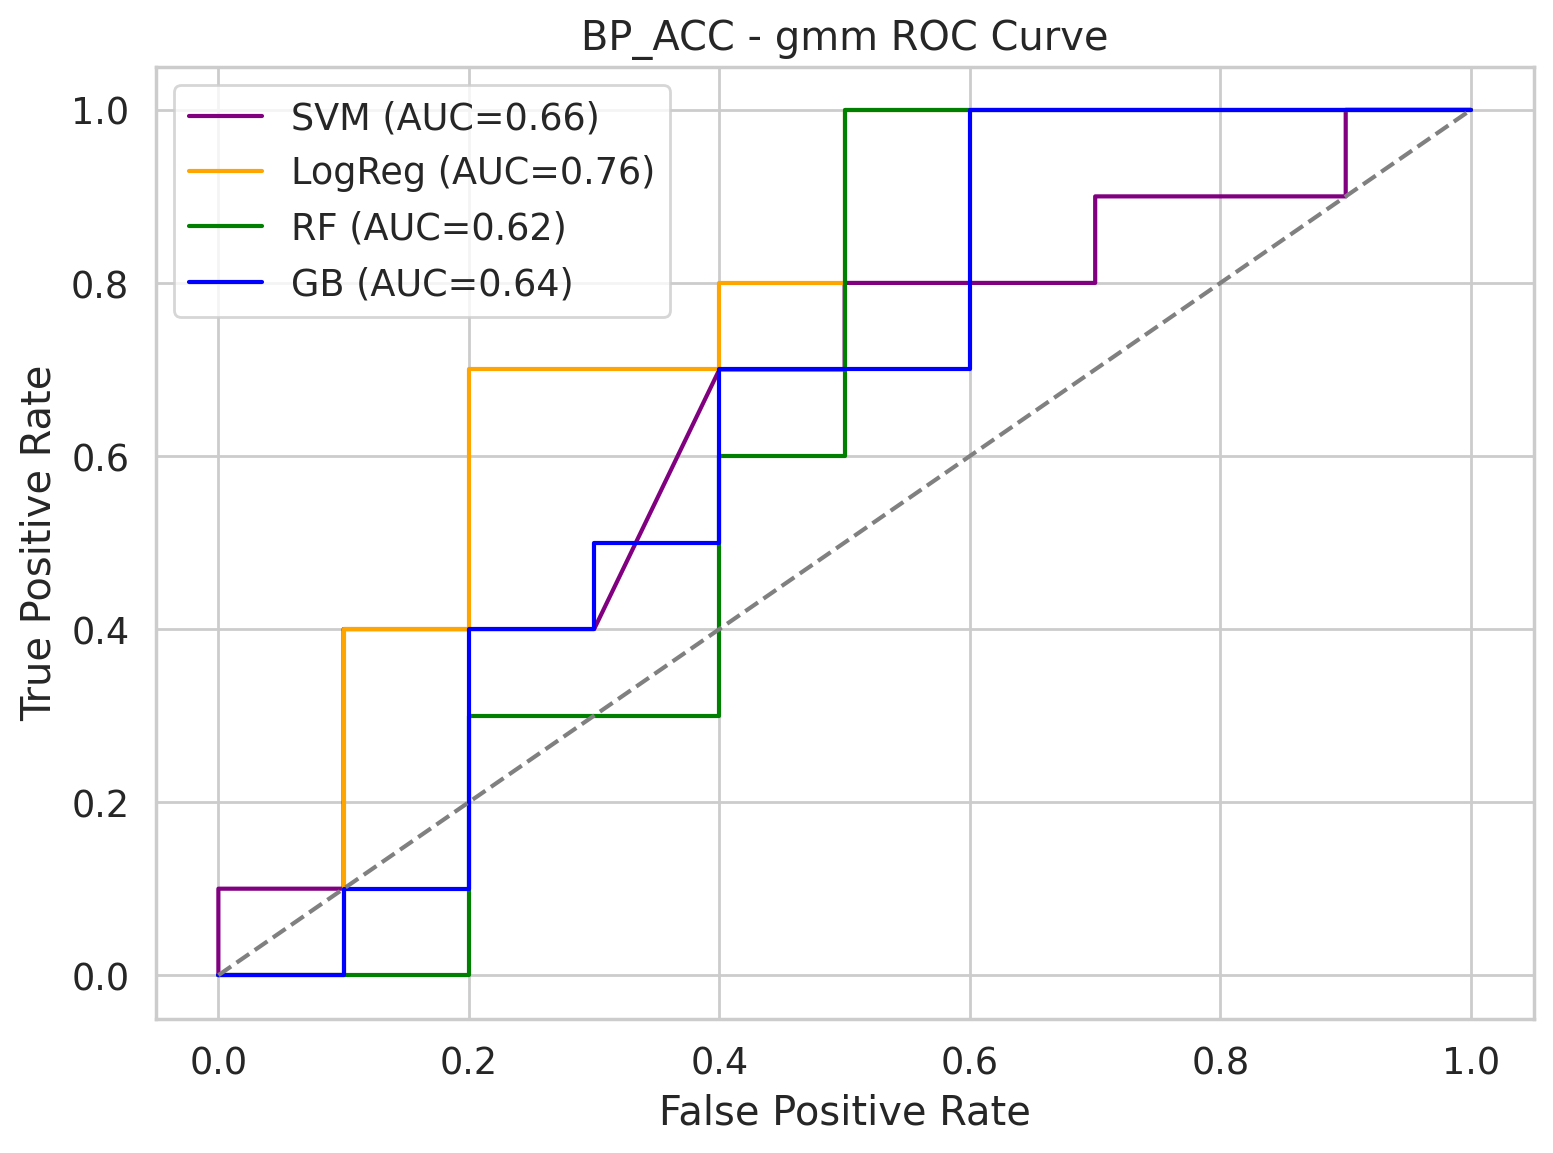


======= FACES_ACC | Threshold method: median (thr: 0.900) =======
PCA n_components: 34 | Explained Var: 0.96
[SVM]               precision    recall  f1-score   support

           0      0.400     1.000     0.571         8
           1      0.000     0.000     0.000        12

    accuracy                          0.400        20
   macro avg      0.200     0.500     0.286        20
weighted avg      0.160     0.400     0.229        20
 Acc: 0.40, AUC: 0.26
[LR]               precision    recall  f1-score   support

           0      0.444     0.500     0.471         8
           1      0.636     0.583     0.609        12

    accuracy                          0.550        20
   macro avg      0.540     0.542     0.540        20
weighted avg      0.560     0.550     0.553        20
 Acc: 0.55, AUC: 0.50
[RF]               precision    recall  f1-score   support

           0      0.400     0.250     0.308         8
           1      0.600     0.750     0.667        12

    accuracy  

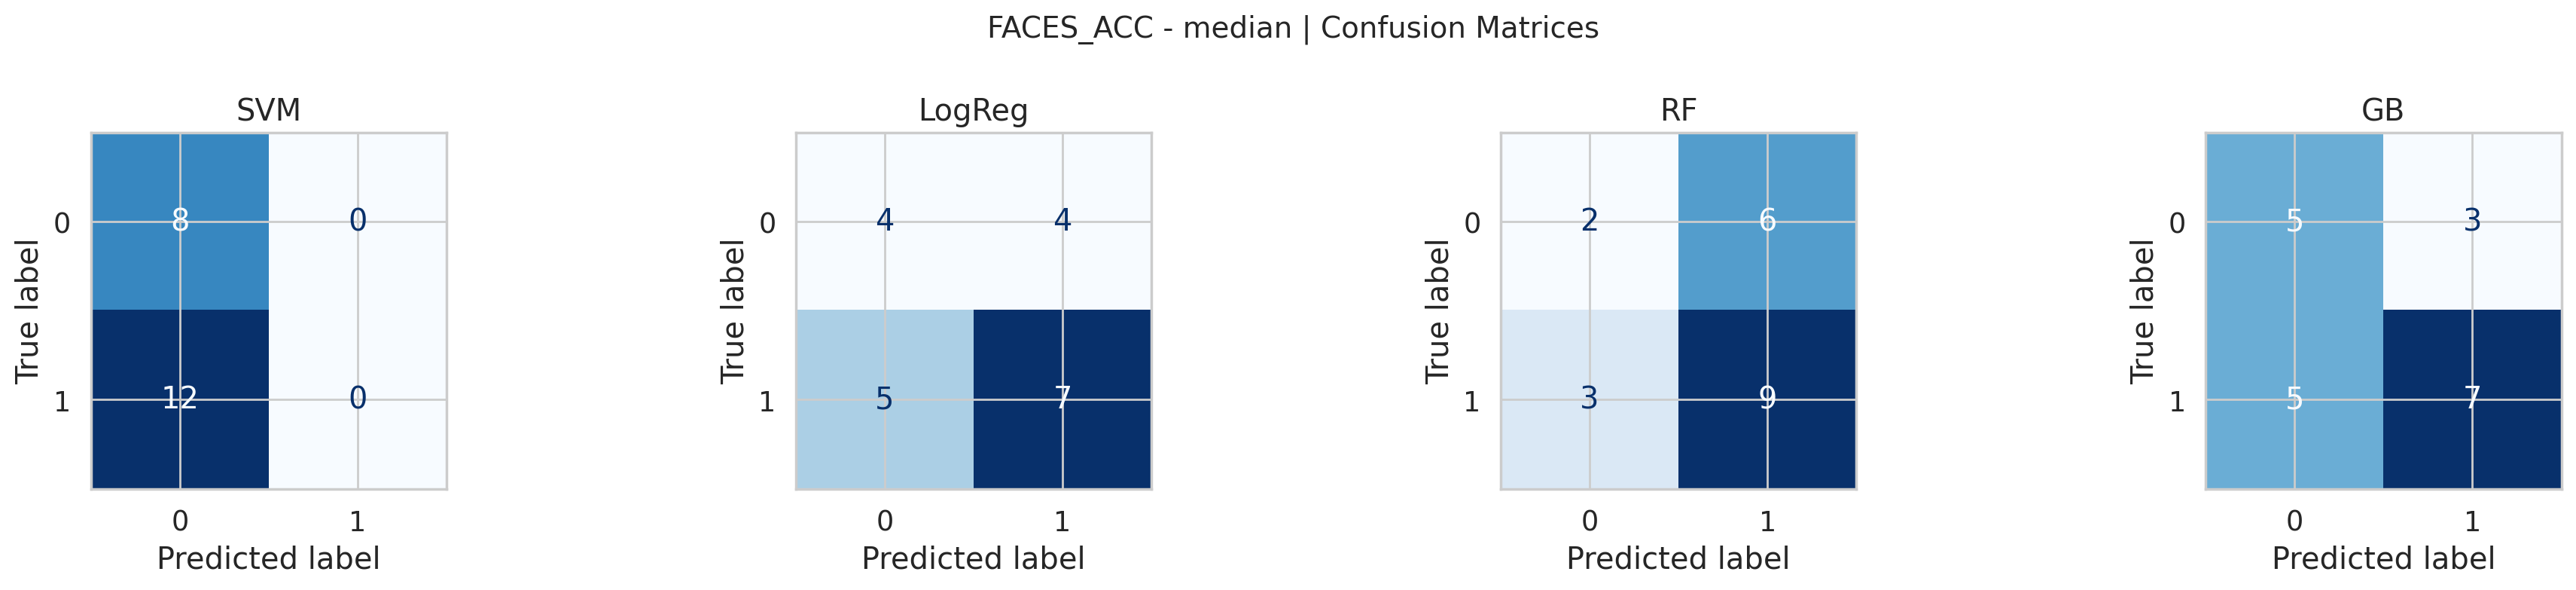

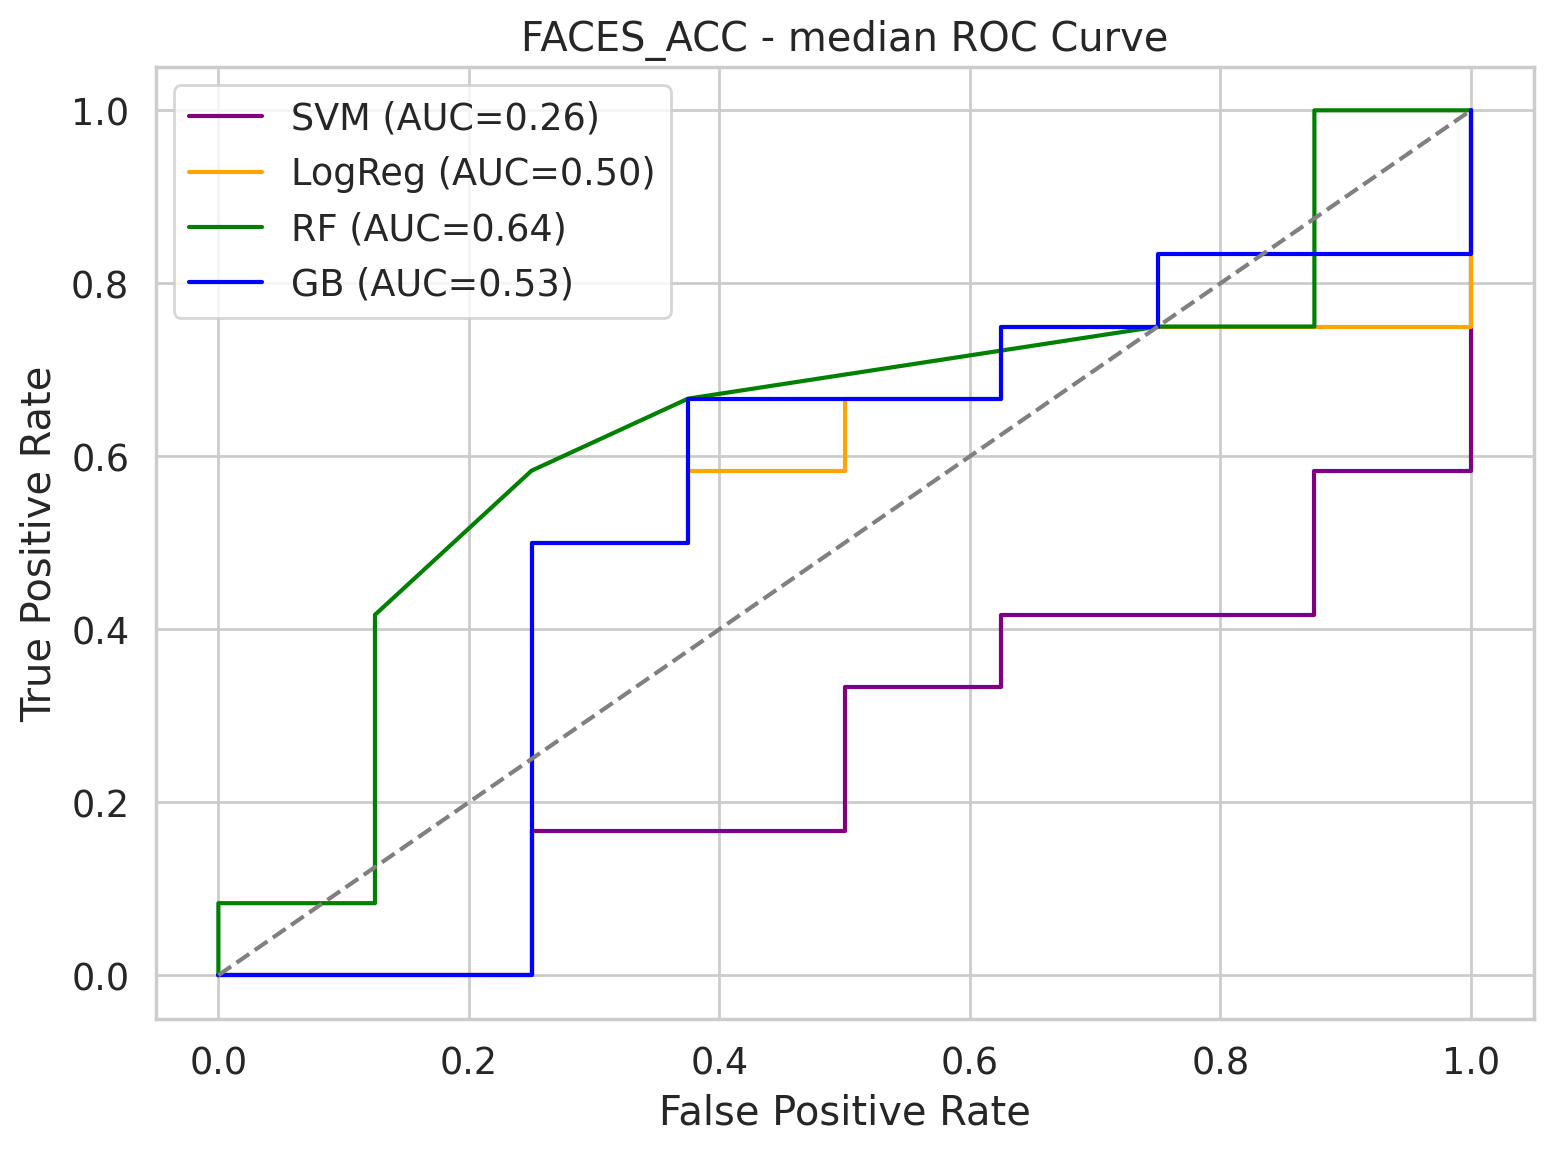


======= FACES_ACC | Threshold method: percentile_67 (thr: 0.950) =======
PCA n_components: 34 | Explained Var: 0.95
[SVM]               precision    recall  f1-score   support

           0      0.600     1.000     0.750        12
           1      0.000     0.000     0.000         8

    accuracy                          0.600        20
   macro avg      0.300     0.500     0.375        20
weighted avg      0.360     0.600     0.450        20
 Acc: 0.60, AUC: 0.49
[LR]               precision    recall  f1-score   support

           0      0.500     0.333     0.400        12
           1      0.333     0.500     0.400         8

    accuracy                          0.400        20
   macro avg      0.417     0.417     0.400        20
weighted avg      0.433     0.400     0.400        20
 Acc: 0.40, AUC: 0.49
[RF]               precision    recall  f1-score   support

           0      0.562     0.750     0.643        12
           1      0.250     0.125     0.167         8

    acc

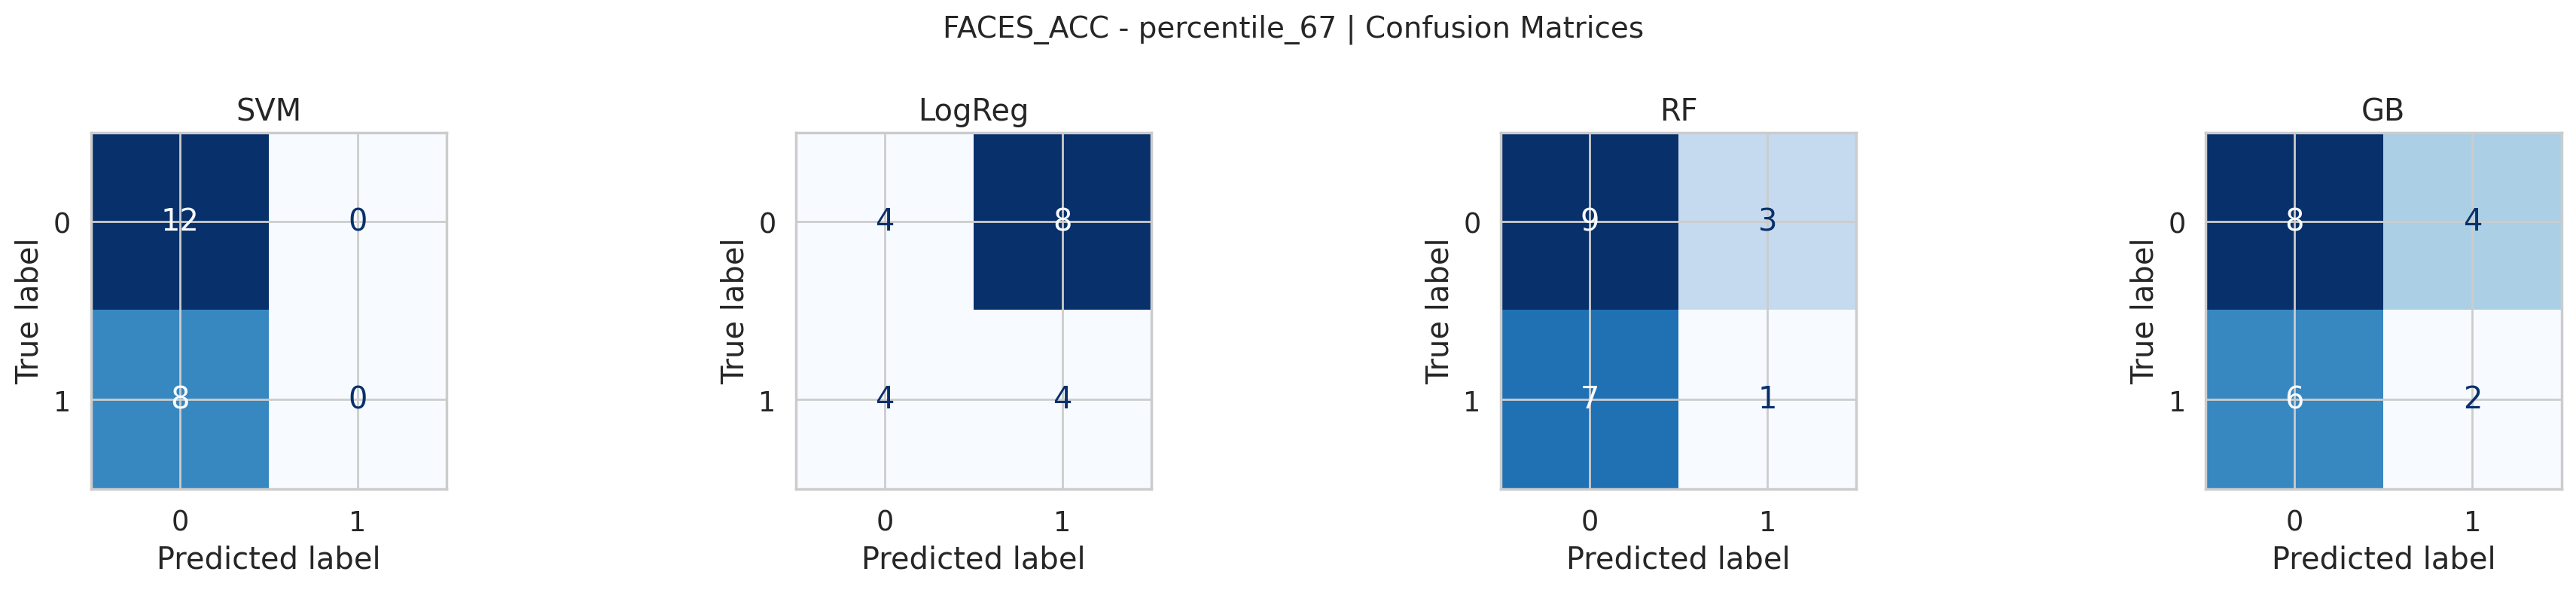

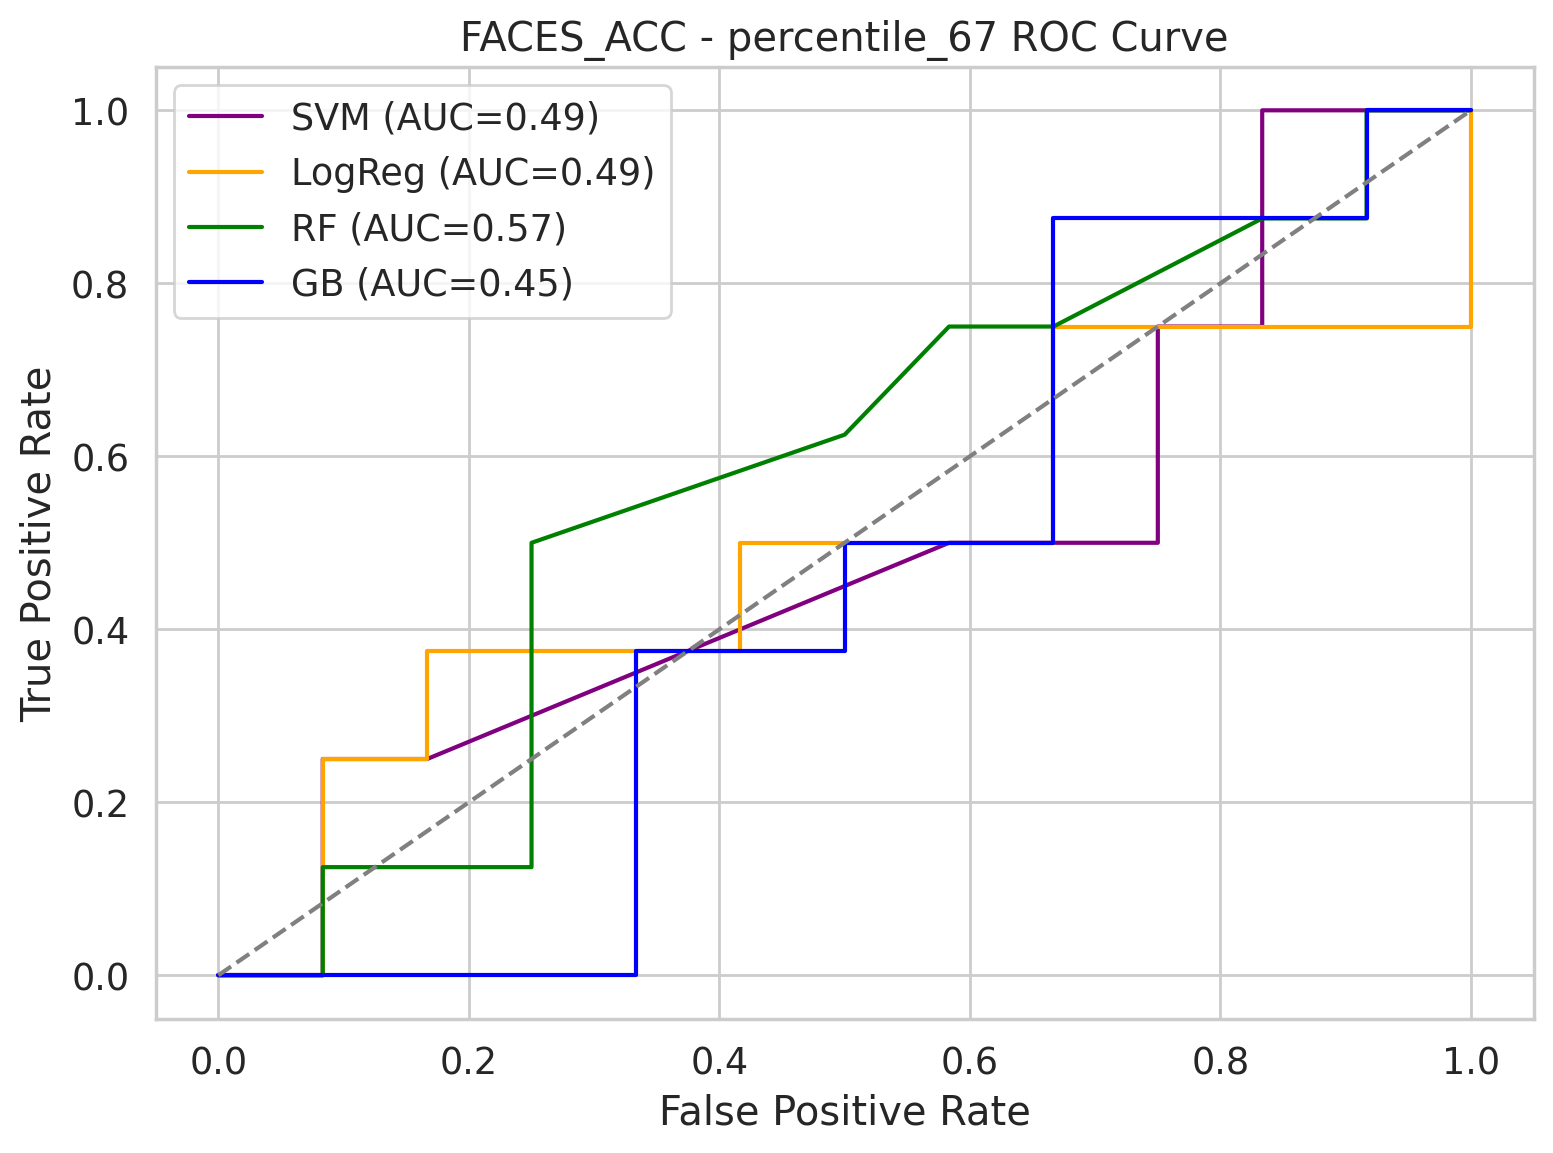


======= FACES_ACC | Threshold method: gmm (thr: 0.842) =======
PCA n_components: 35 | Explained Var: 0.95
[SVM]               precision    recall  f1-score   support

           0      0.000     0.000     0.000         5
           1      0.737     0.933     0.824        15

    accuracy                          0.700        20
   macro avg      0.368     0.467     0.412        20
weighted avg      0.553     0.700     0.618        20
 Acc: 0.70, AUC: 0.57
[LR]               precision    recall  f1-score   support

           0      0.222     0.400     0.286         5
           1      0.727     0.533     0.615        15

    accuracy                          0.500        20
   macro avg      0.475     0.467     0.451        20
weighted avg      0.601     0.500     0.533        20
 Acc: 0.50, AUC: 0.57
[RF]               precision    recall  f1-score   support

           0      0.000     0.000     0.000         5
           1      0.750     1.000     0.857        15

    accuracy     

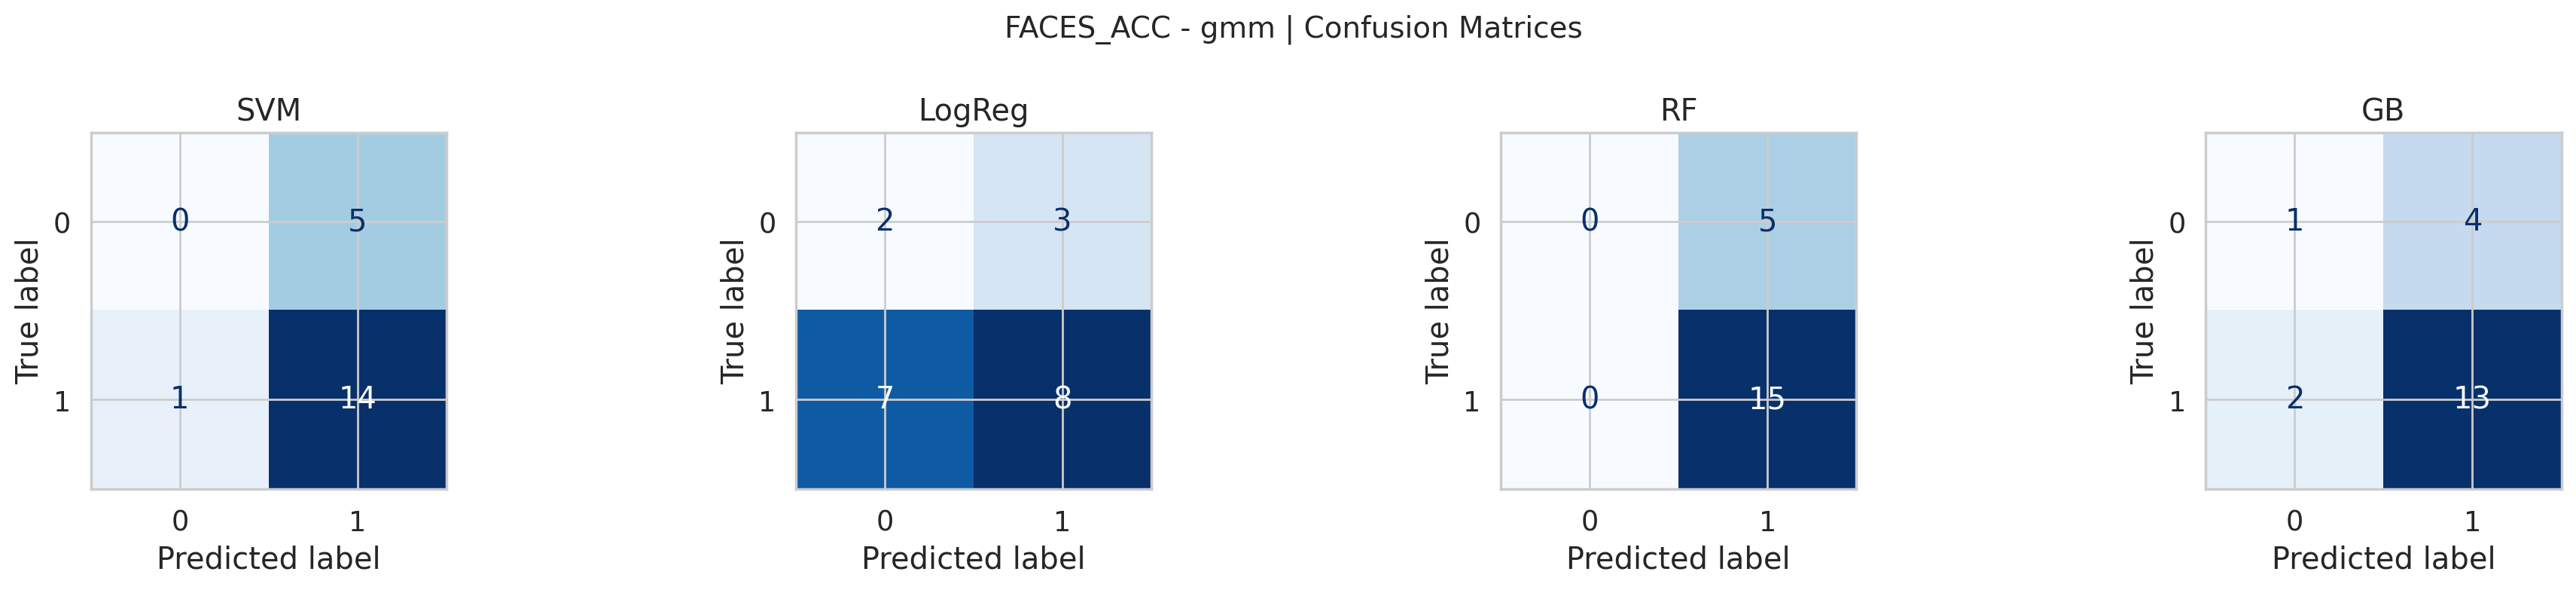

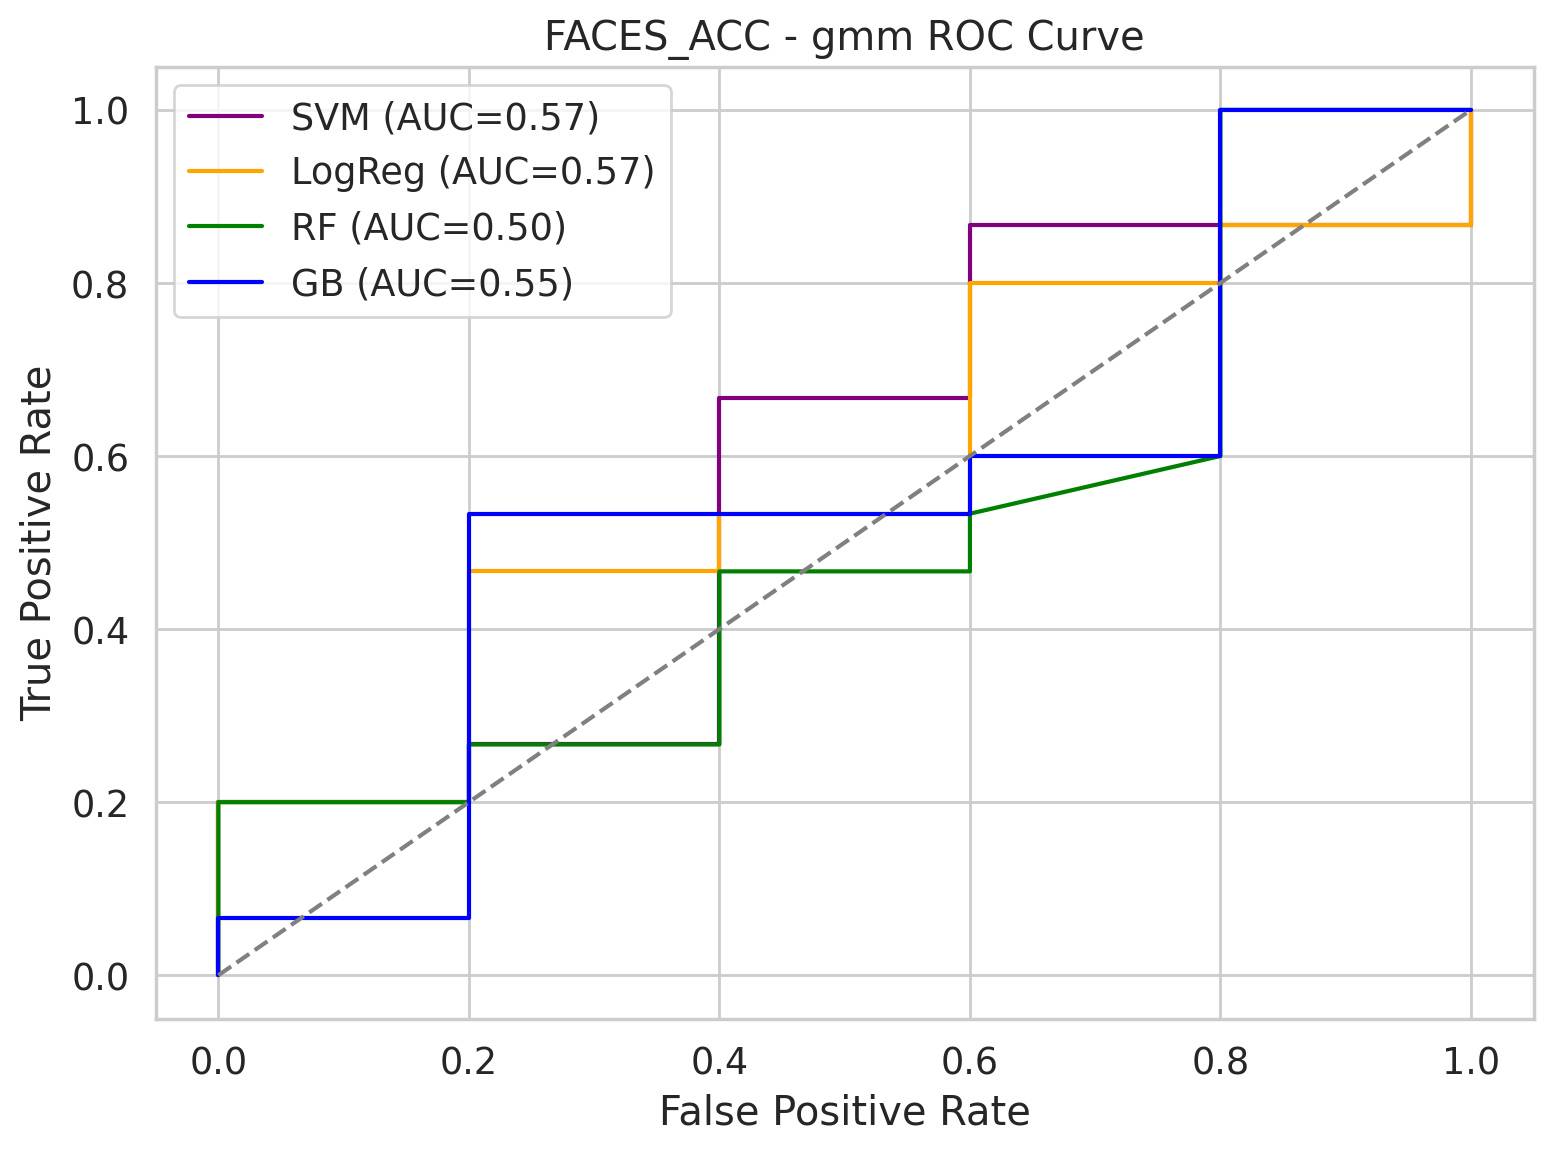


======= PLACES_ACC | Threshold method: median (thr: 0.900) =======
PCA n_components: 33 | Explained Var: 0.95
[SVM]               precision    recall  f1-score   support

           0      0.400     0.250     0.308         8
           1      0.600     0.750     0.667        12

    accuracy                          0.550        20
   macro avg      0.500     0.500     0.487        20
weighted avg      0.520     0.550     0.523        20
 Acc: 0.55, AUC: 0.55
[LR]               precision    recall  f1-score   support

           0      0.333     0.500     0.400         8
           1      0.500     0.333     0.400        12

    accuracy                          0.400        20
   macro avg      0.417     0.417     0.400        20
weighted avg      0.433     0.400     0.400        20
 Acc: 0.40, AUC: 0.28
[RF]               precision    recall  f1-score   support

           0      0.200     0.125     0.154         8
           1      0.533     0.667     0.593        12

    accuracy 

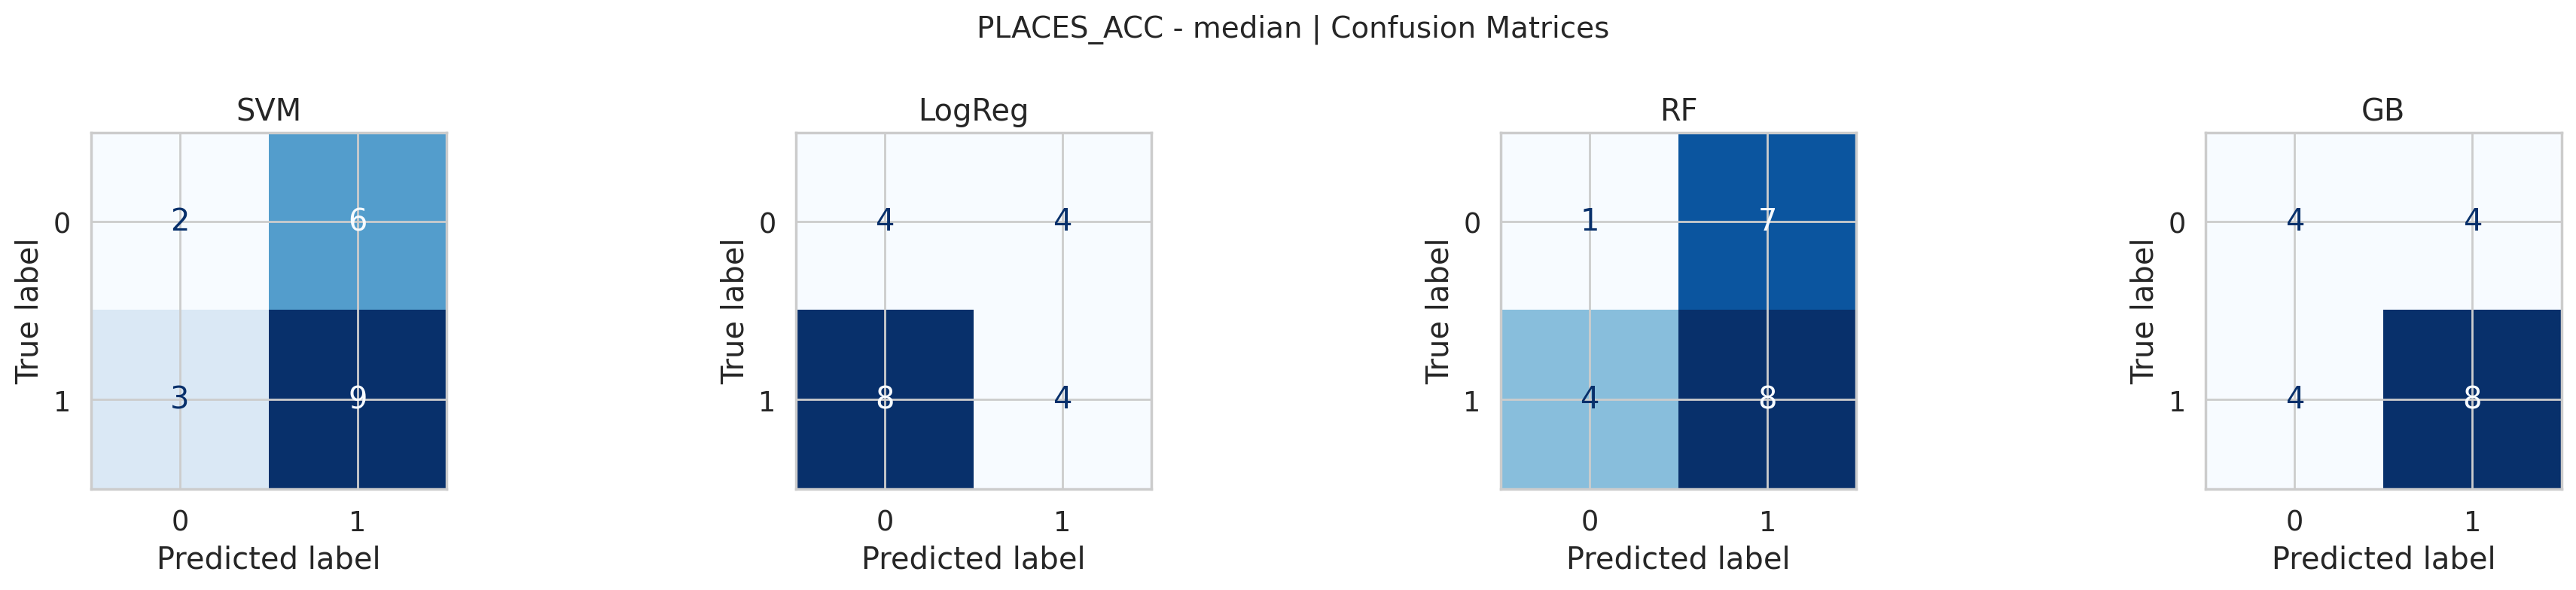

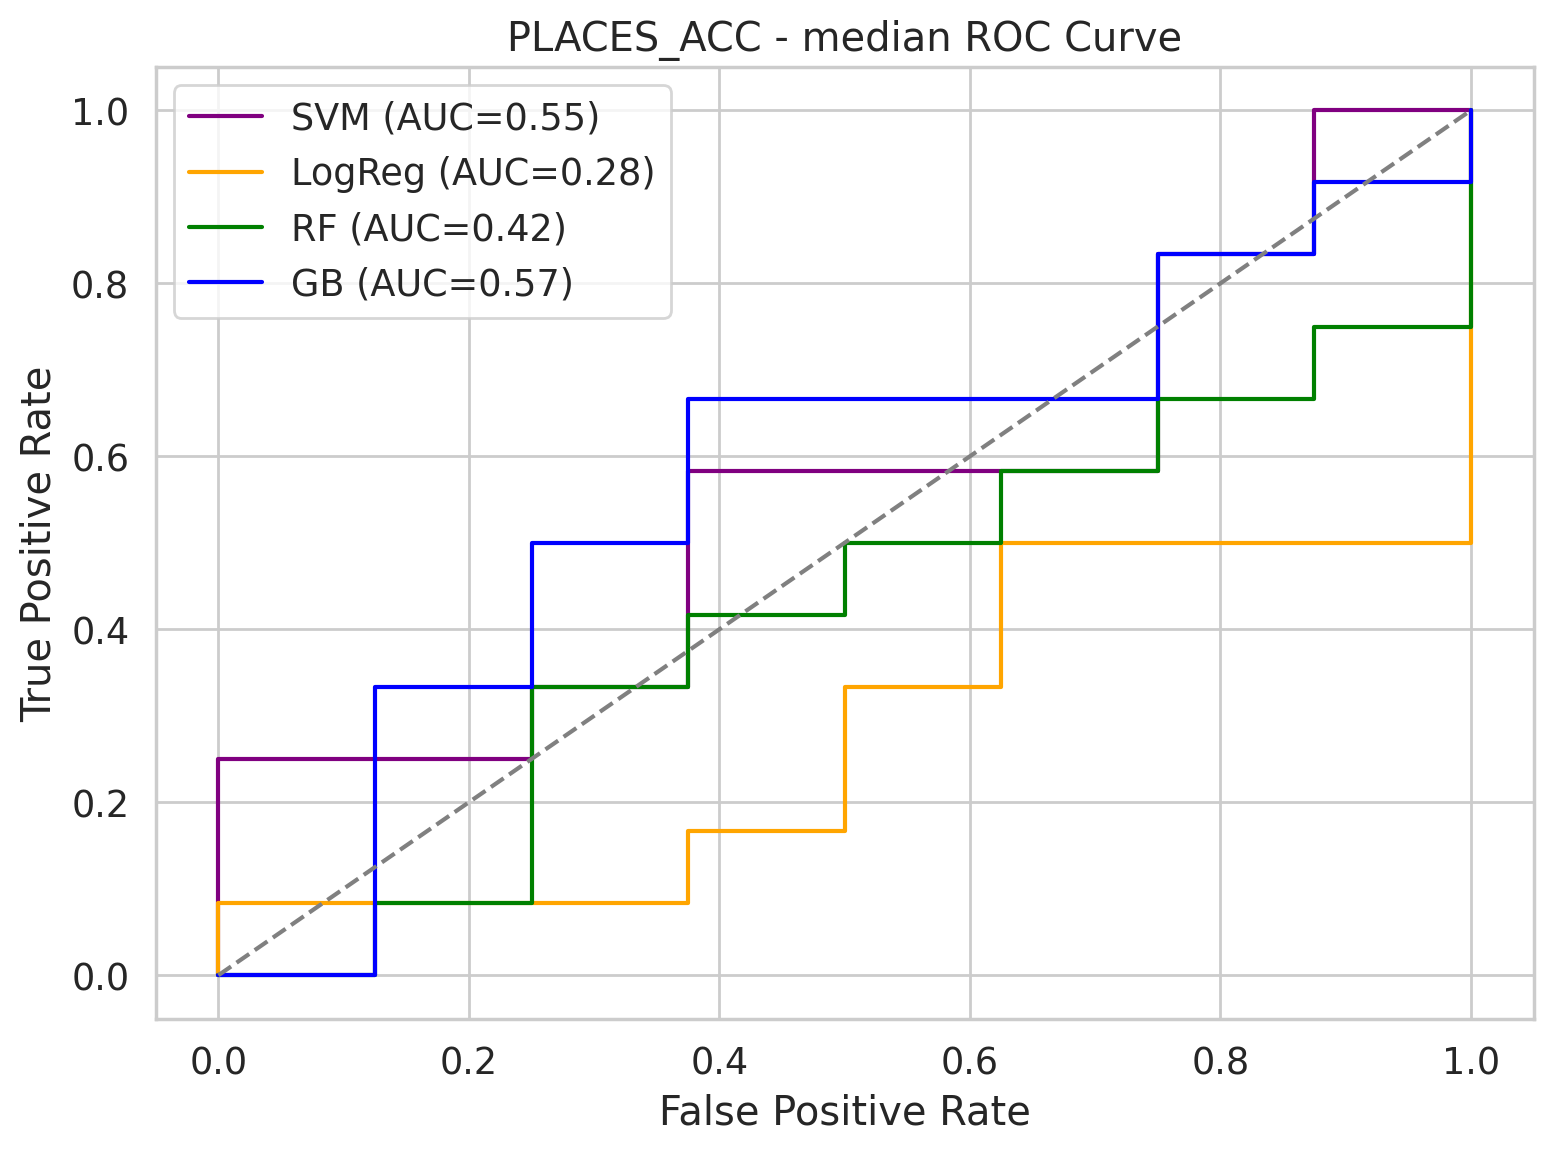


======= PLACES_ACC | Threshold method: percentile_67 (thr: 0.950) =======
PCA n_components: 35 | Explained Var: 0.95
[SVM]               precision    recall  f1-score   support

           0      0.550     1.000     0.710        11
           1      0.000     0.000     0.000         9

    accuracy                          0.550        20
   macro avg      0.275     0.500     0.355        20
weighted avg      0.303     0.550     0.390        20
 Acc: 0.55, AUC: 0.36
[LR]               precision    recall  f1-score   support

           0      0.545     0.545     0.545        11
           1      0.444     0.444     0.444         9

    accuracy                          0.500        20
   macro avg      0.495     0.495     0.495        20
weighted avg      0.500     0.500     0.500        20
 Acc: 0.50, AUC: 0.51
[RF]               precision    recall  f1-score   support

           0      0.562     0.818     0.667        11
           1      0.500     0.222     0.308         9

    ac

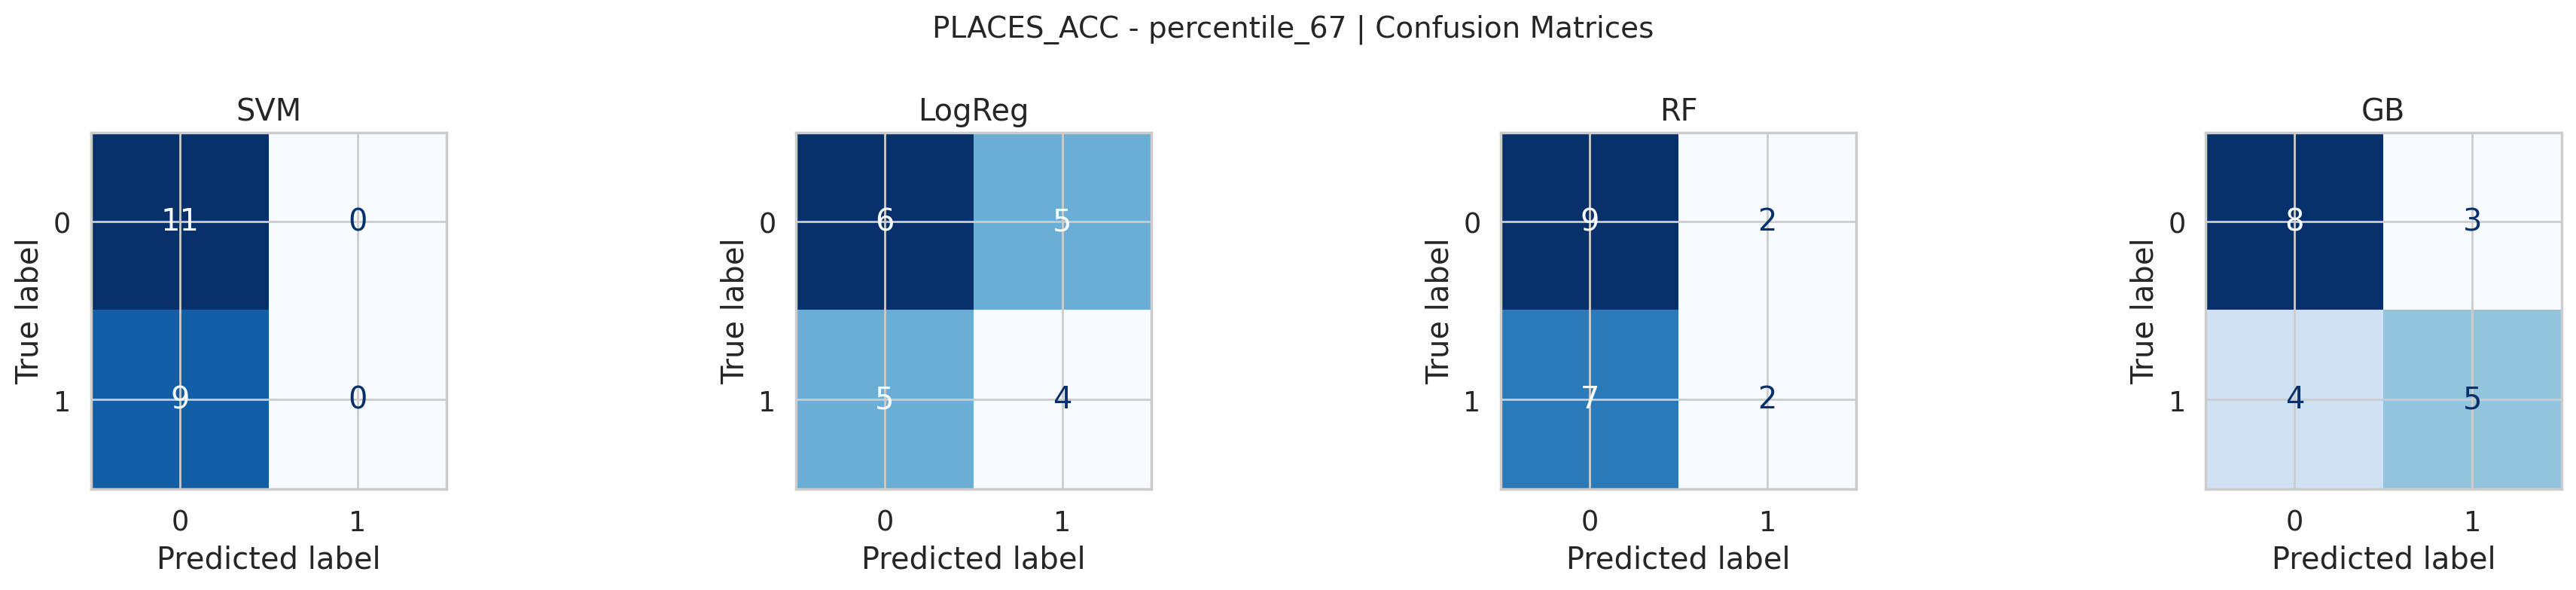

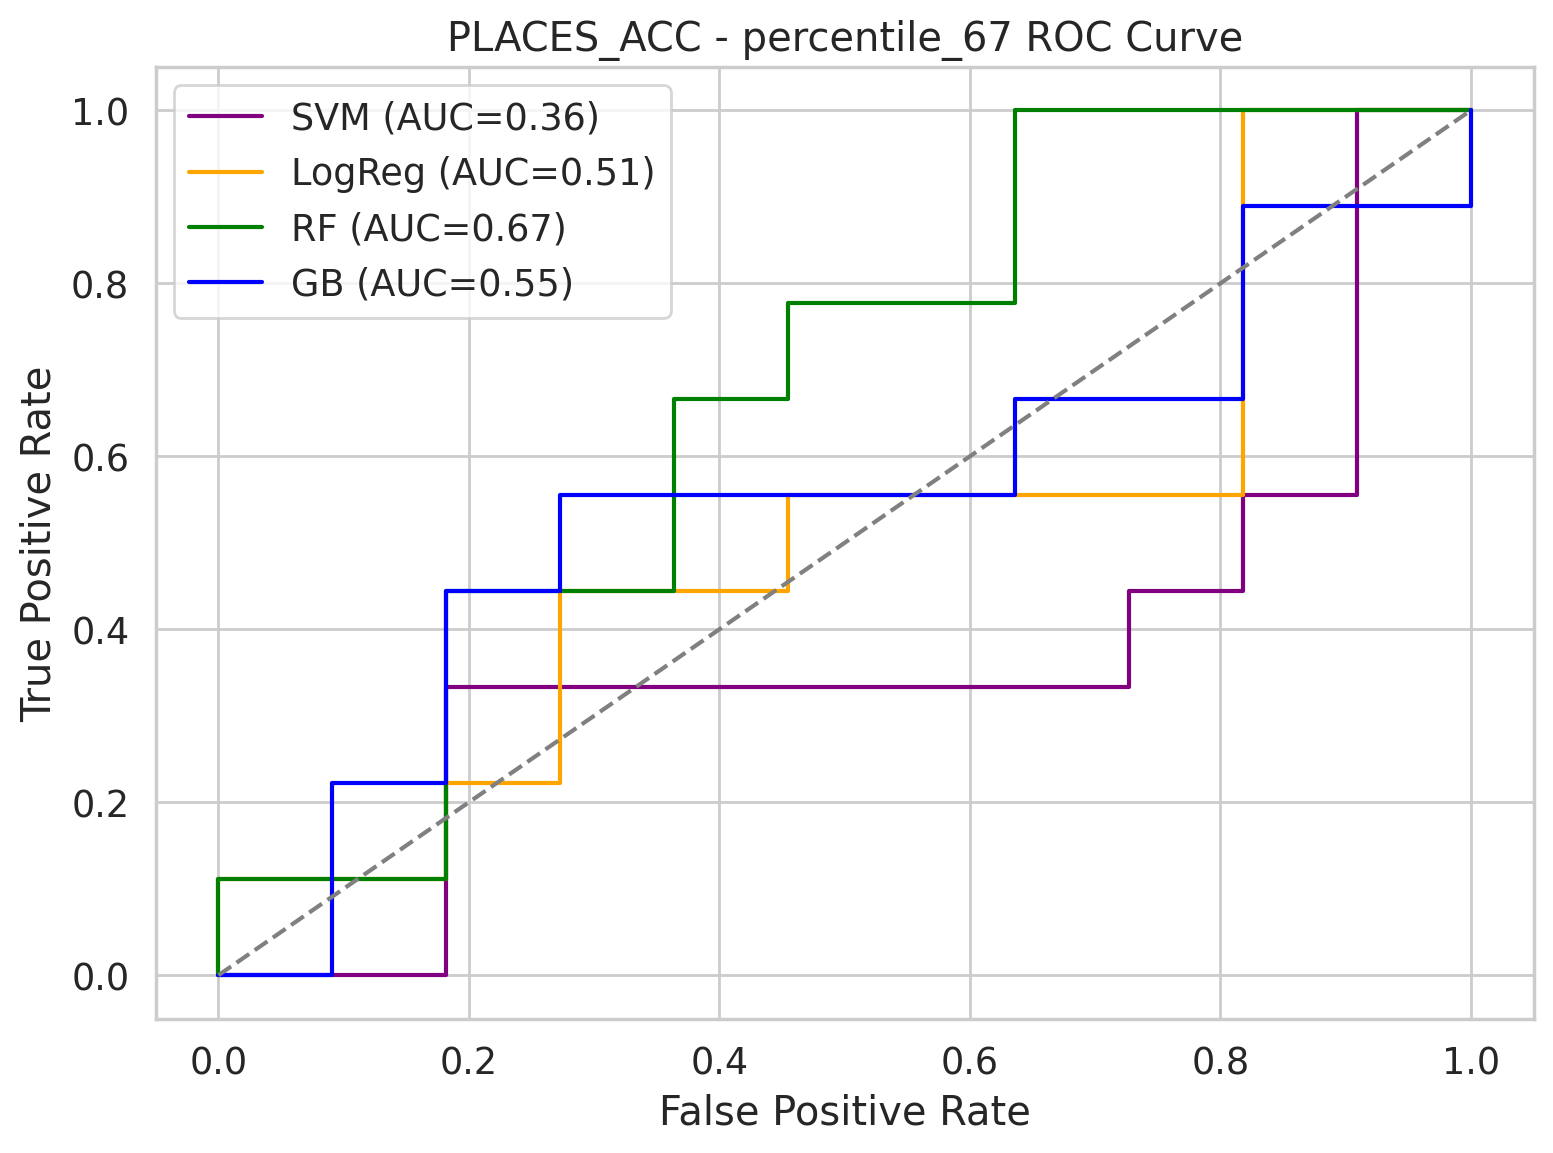


======= PLACES_ACC | Threshold method: gmm (thr: 0.856) =======
PCA n_components: 33 | Explained Var: 0.95
[SVM]               precision    recall  f1-score   support

           0      0.400     0.250     0.308         8
           1      0.600     0.750     0.667        12

    accuracy                          0.550        20
   macro avg      0.500     0.500     0.487        20
weighted avg      0.520     0.550     0.523        20
 Acc: 0.55, AUC: 0.55
[LR]               precision    recall  f1-score   support

           0      0.333     0.500     0.400         8
           1      0.500     0.333     0.400        12

    accuracy                          0.400        20
   macro avg      0.417     0.417     0.400        20
weighted avg      0.433     0.400     0.400        20
 Acc: 0.40, AUC: 0.28
[RF]               precision    recall  f1-score   support

           0      0.200     0.125     0.154         8
           1      0.533     0.667     0.593        12

    accuracy    

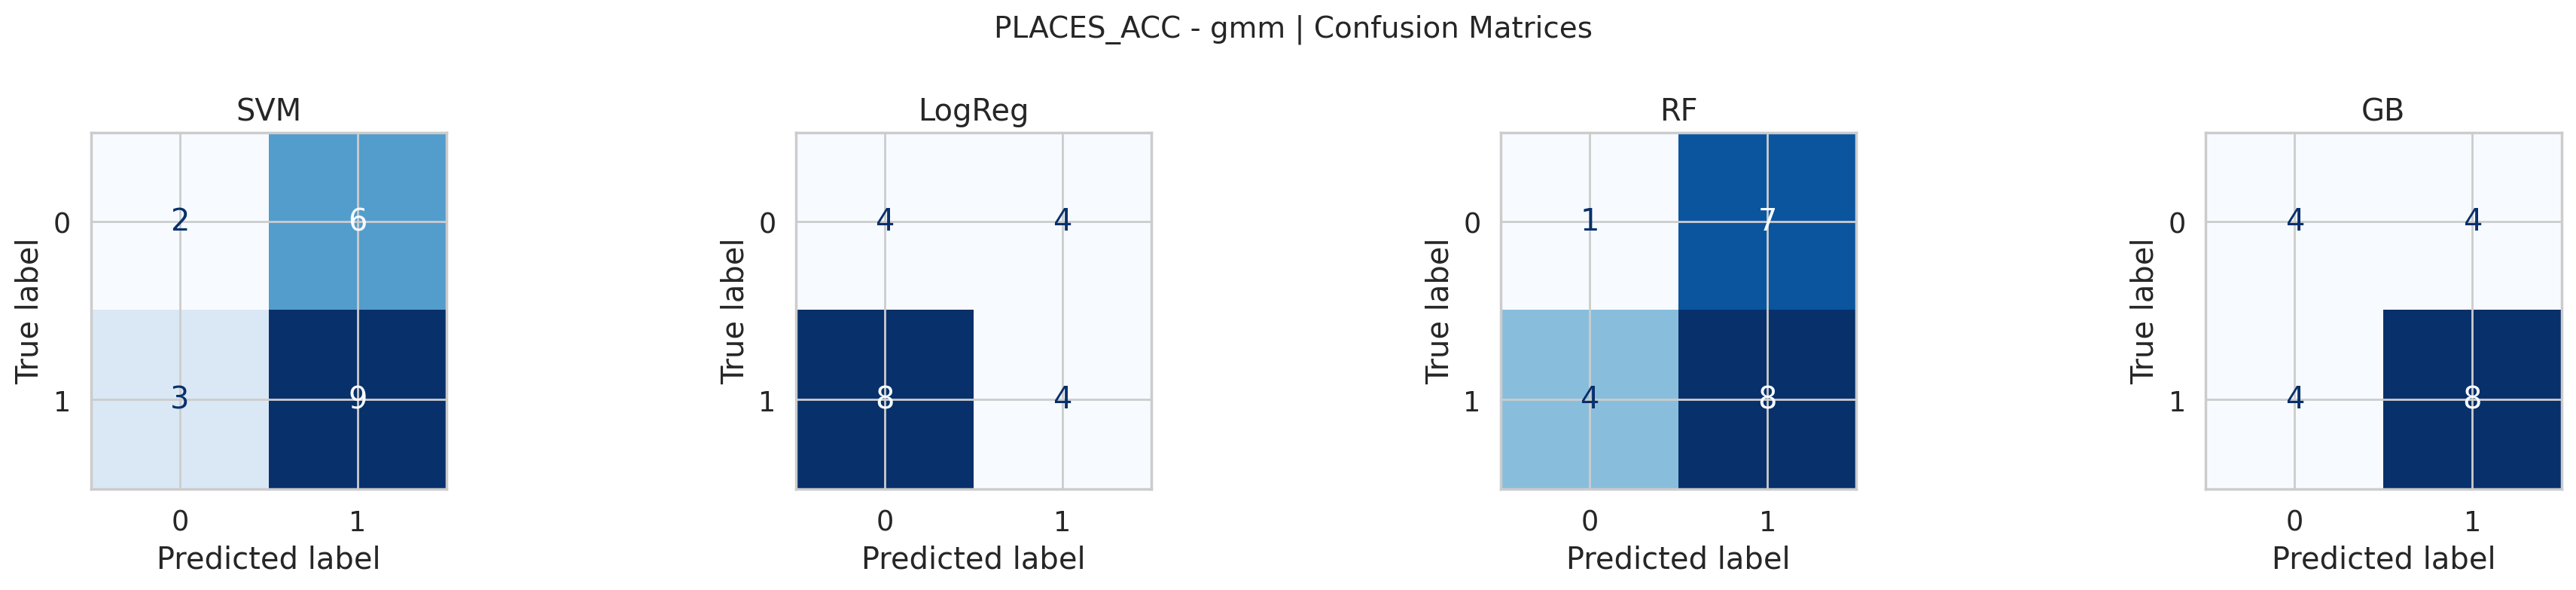

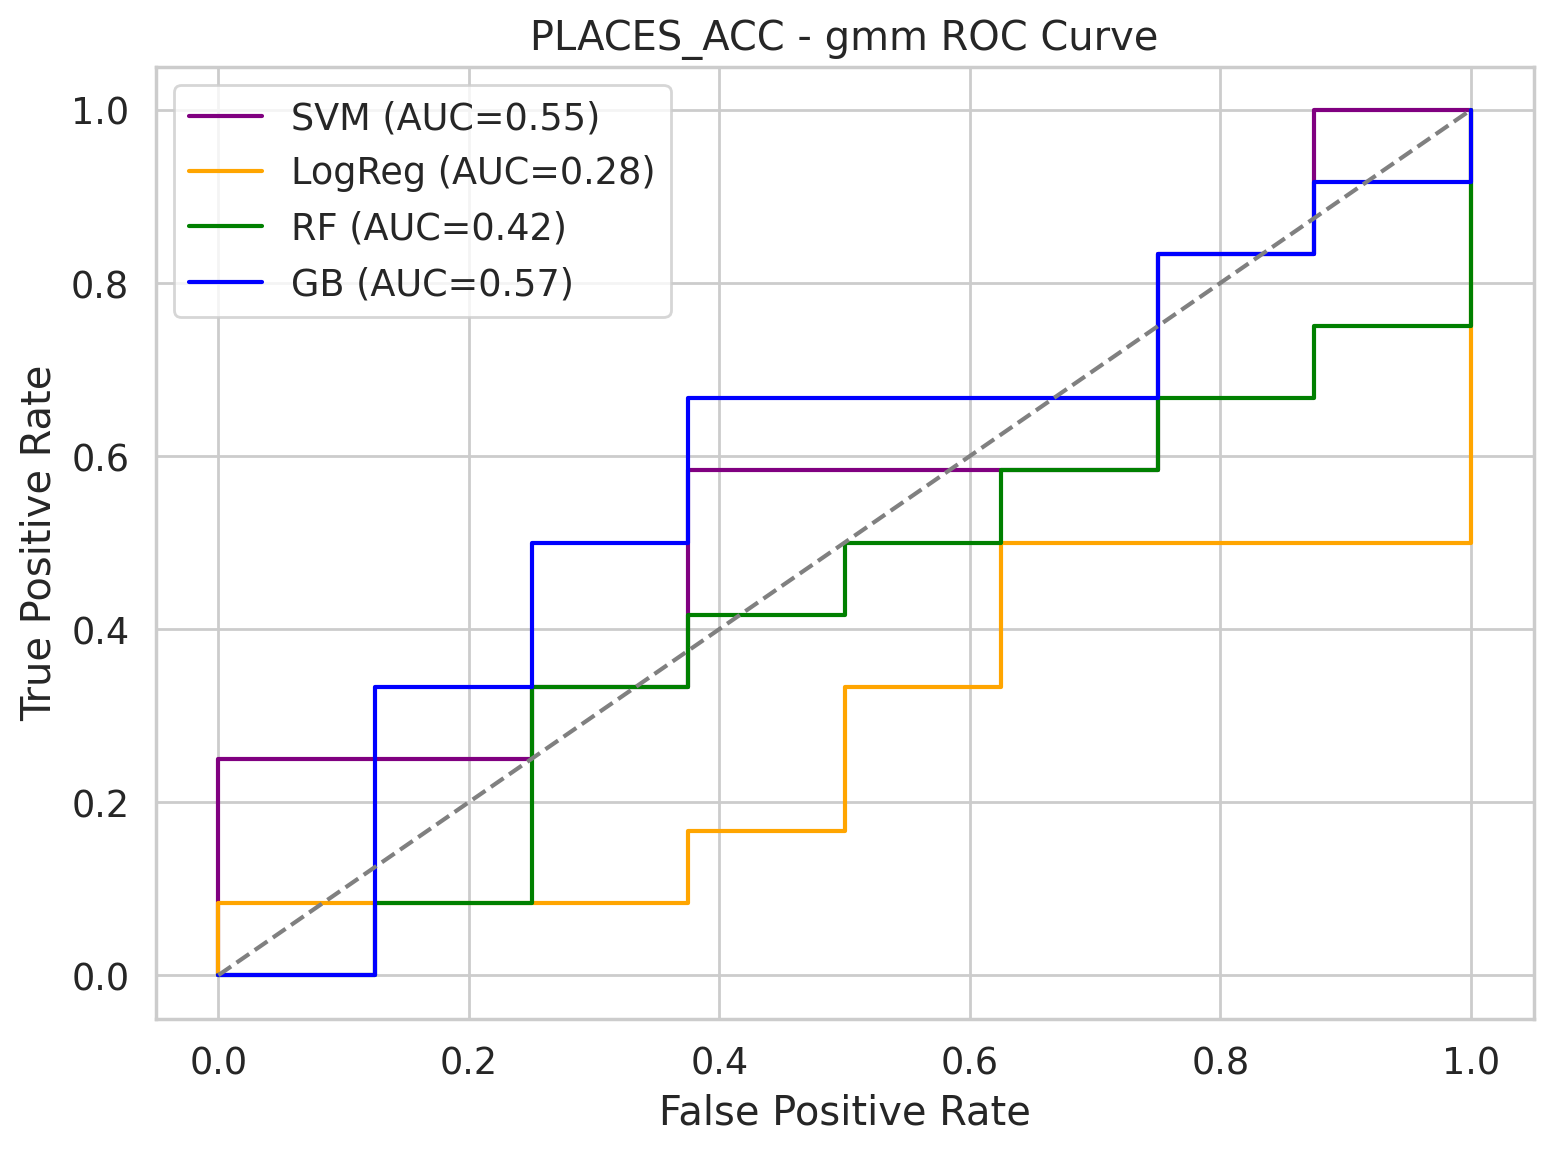


======= TOOLS_ACC | Threshold method: median (thr: 0.850) =======
PCA n_components: 35 | Explained Var: 0.95
[SVM]               precision    recall  f1-score   support

           0      0.800     0.500     0.615         8
           1      0.733     0.917     0.815        12

    accuracy                          0.750        20
   macro avg      0.767     0.708     0.715        20
weighted avg      0.760     0.750     0.735        20
 Acc: 0.75, AUC: 0.66
[LR]               precision    recall  f1-score   support

           0      0.800     0.500     0.615         8
           1      0.733     0.917     0.815        12

    accuracy                          0.750        20
   macro avg      0.767     0.708     0.715        20
weighted avg      0.760     0.750     0.735        20
 Acc: 0.75, AUC: 0.73
[RF]               precision    recall  f1-score   support

           0      0.500     0.125     0.200         8
           1      0.611     0.917     0.733        12

    accuracy  

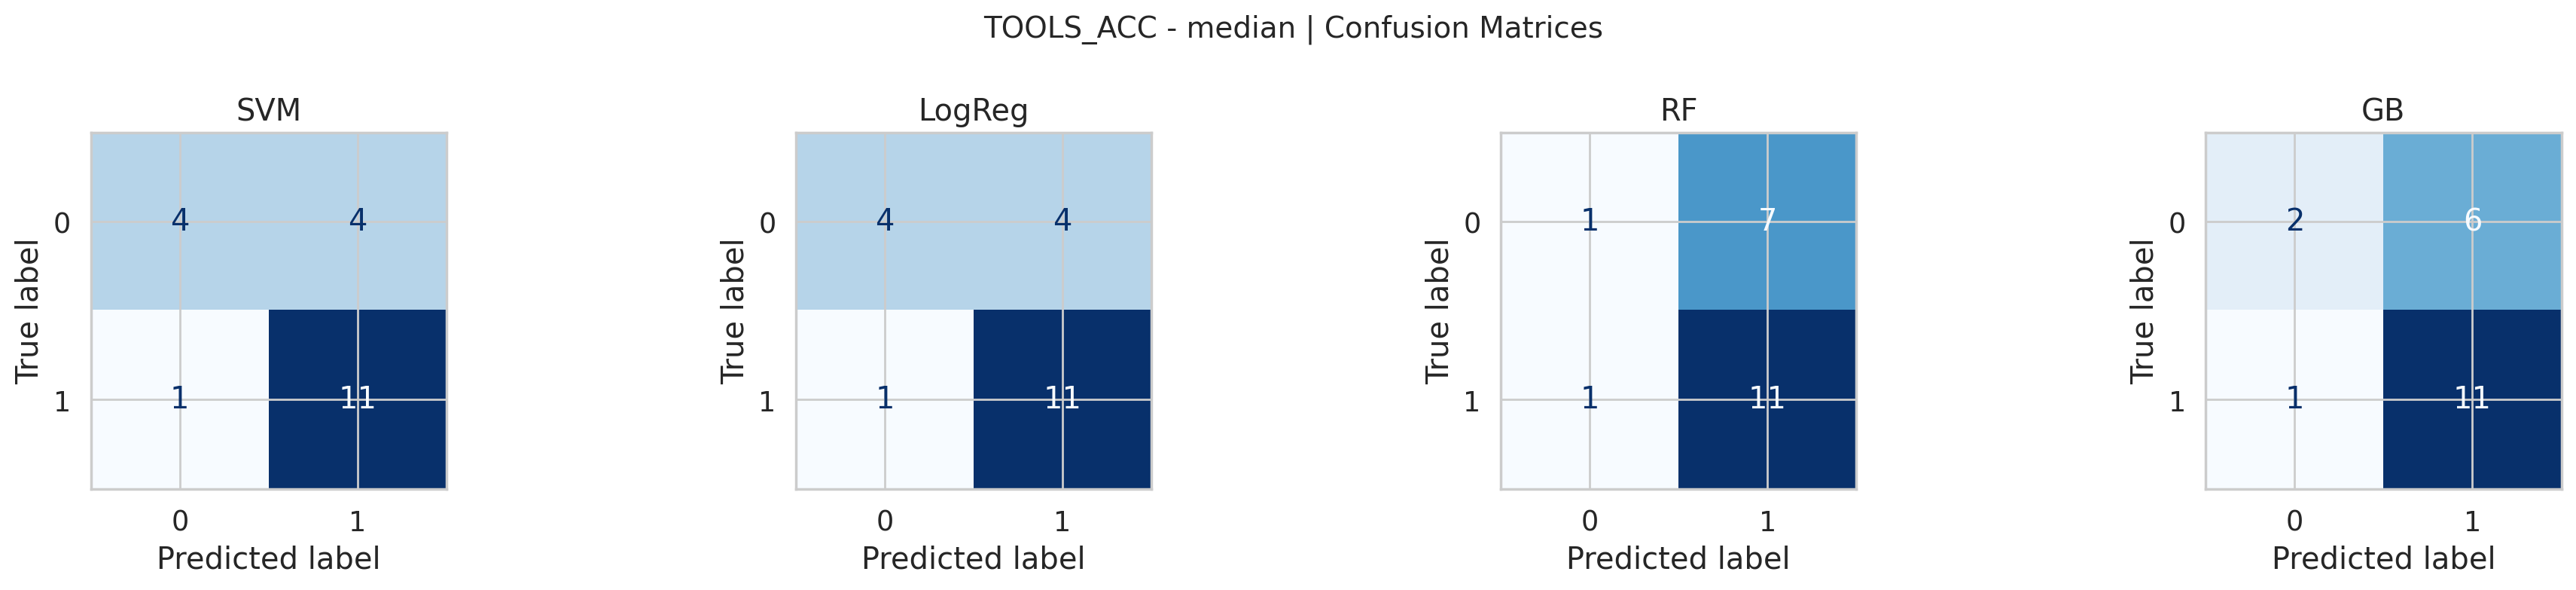

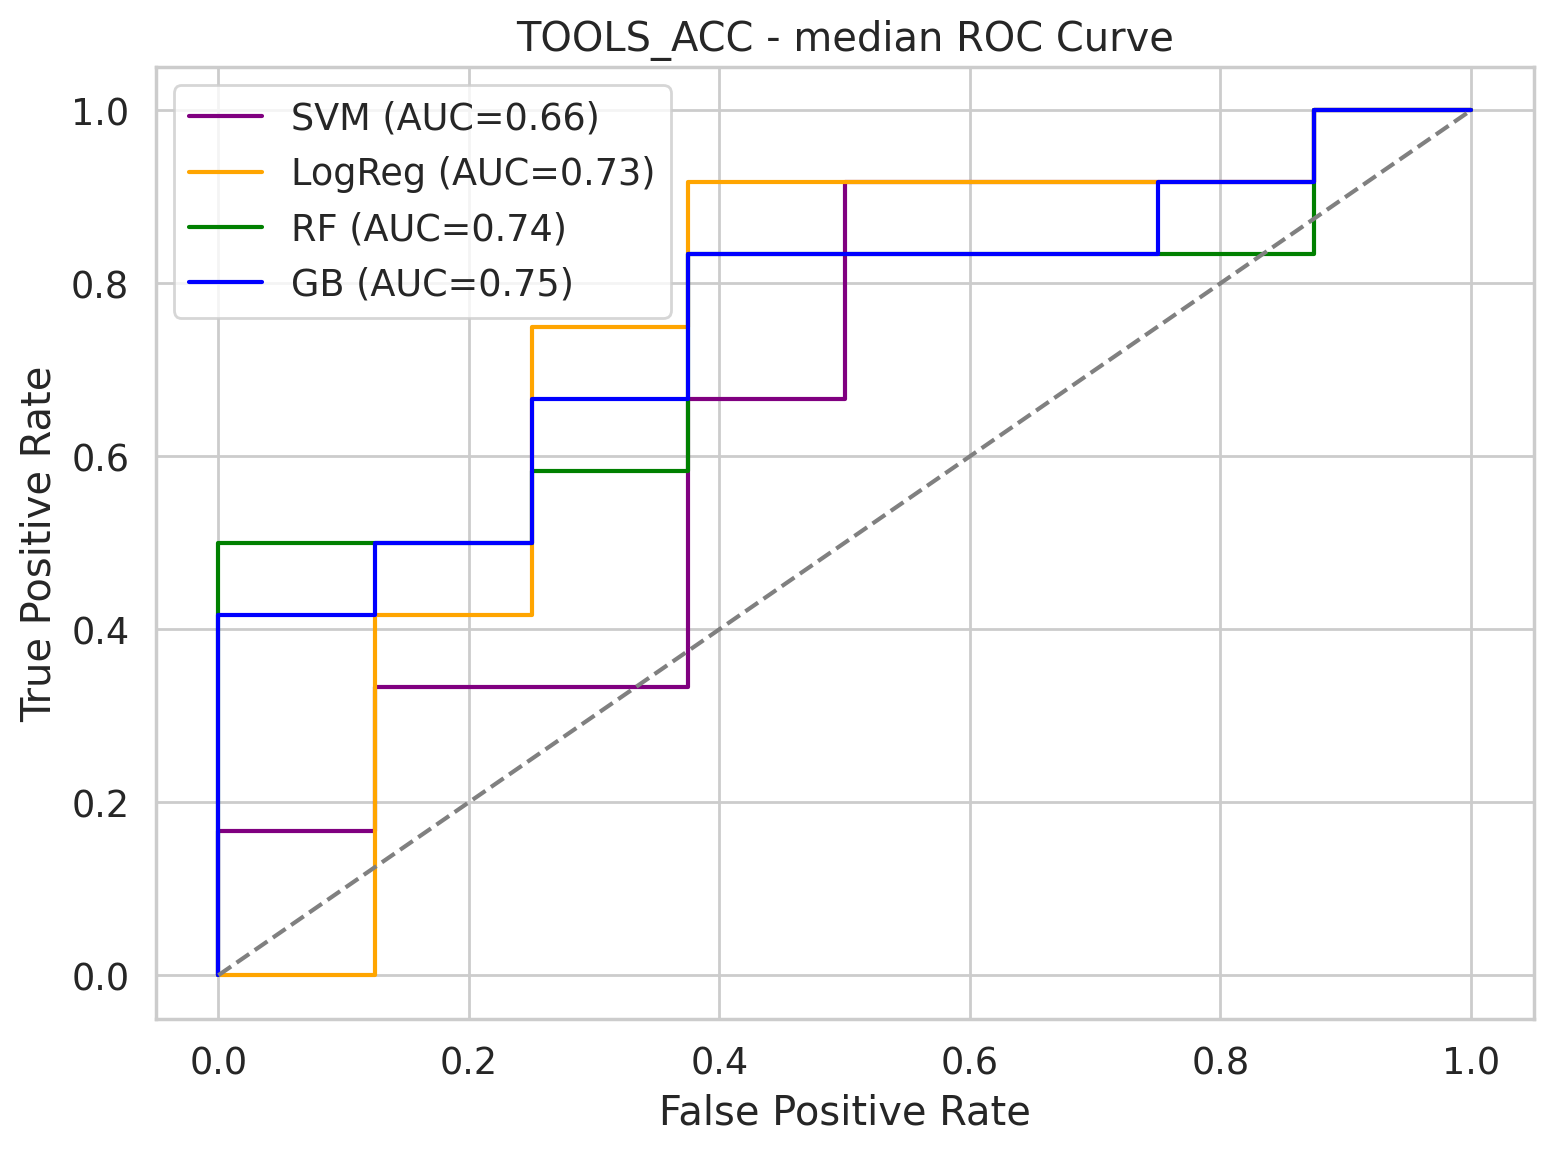


======= TOOLS_ACC | Threshold method: percentile_67 (thr: 0.900) =======
PCA n_components: 35 | Explained Var: 0.95
[SVM]               precision    recall  f1-score   support

           0      0.571     0.667     0.615        12
           1      0.333     0.250     0.286         8

    accuracy                          0.500        20
   macro avg      0.452     0.458     0.451        20
weighted avg      0.476     0.500     0.484        20
 Acc: 0.50, AUC: 0.40
[LR]               precision    recall  f1-score   support

           0      0.583     0.583     0.583        12
           1      0.375     0.375     0.375         8

    accuracy                          0.500        20
   macro avg      0.479     0.479     0.479        20
weighted avg      0.500     0.500     0.500        20
 Acc: 0.50, AUC: 0.42
[RF]               precision    recall  f1-score   support

           0      0.500     0.500     0.500        12
           1      0.250     0.250     0.250         8

    acc

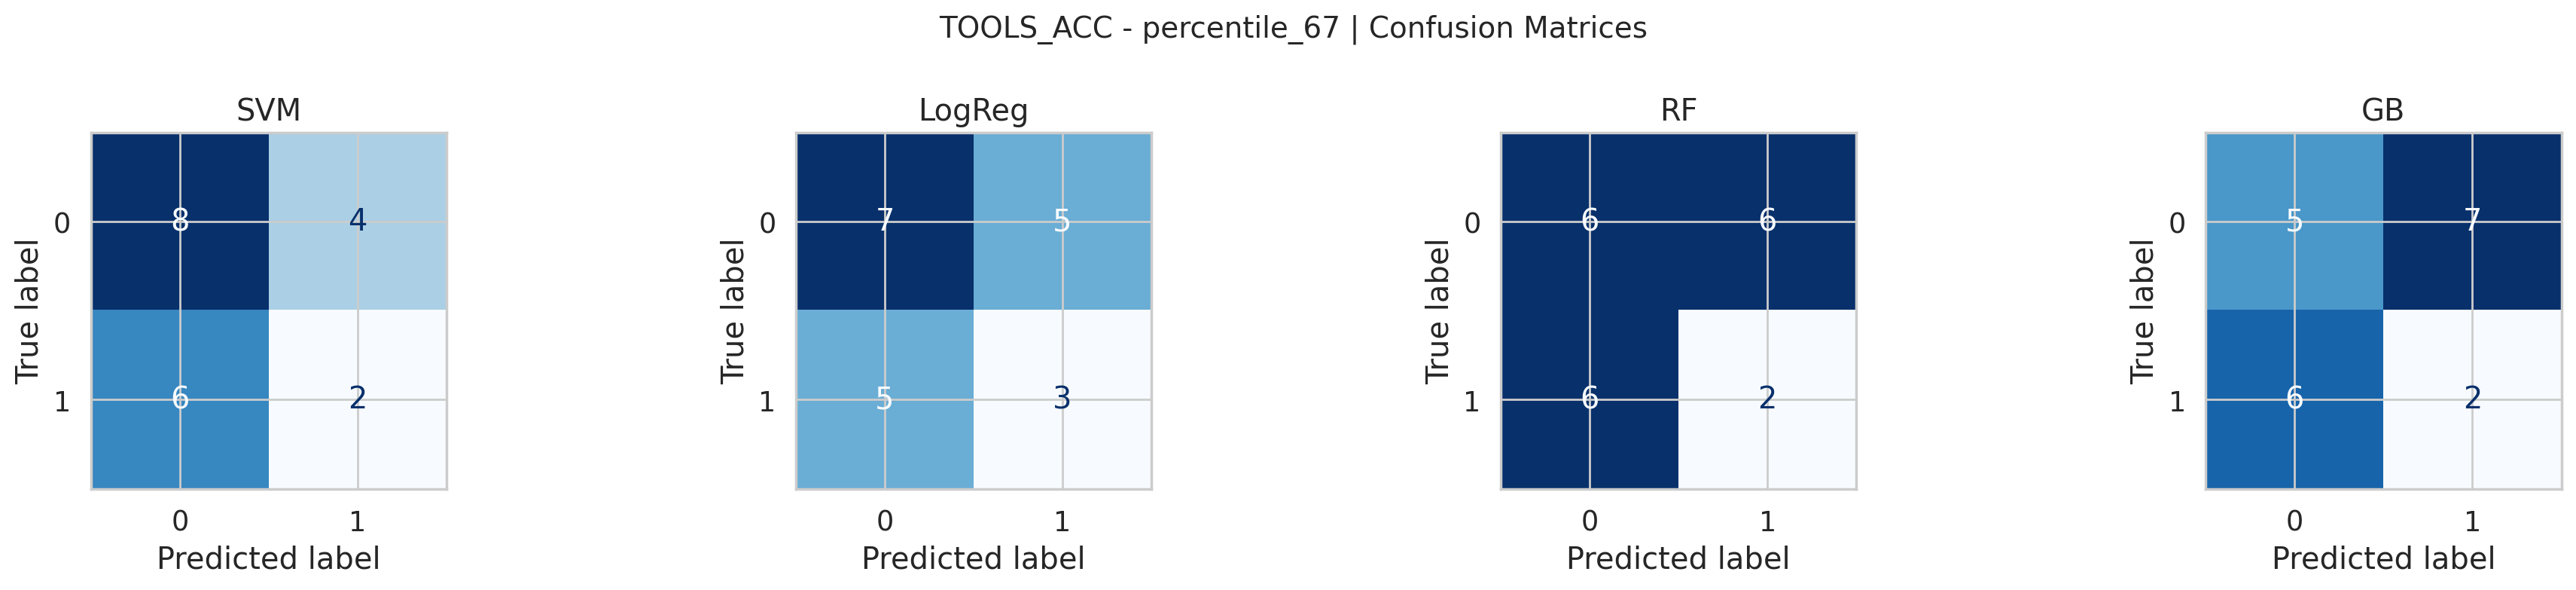

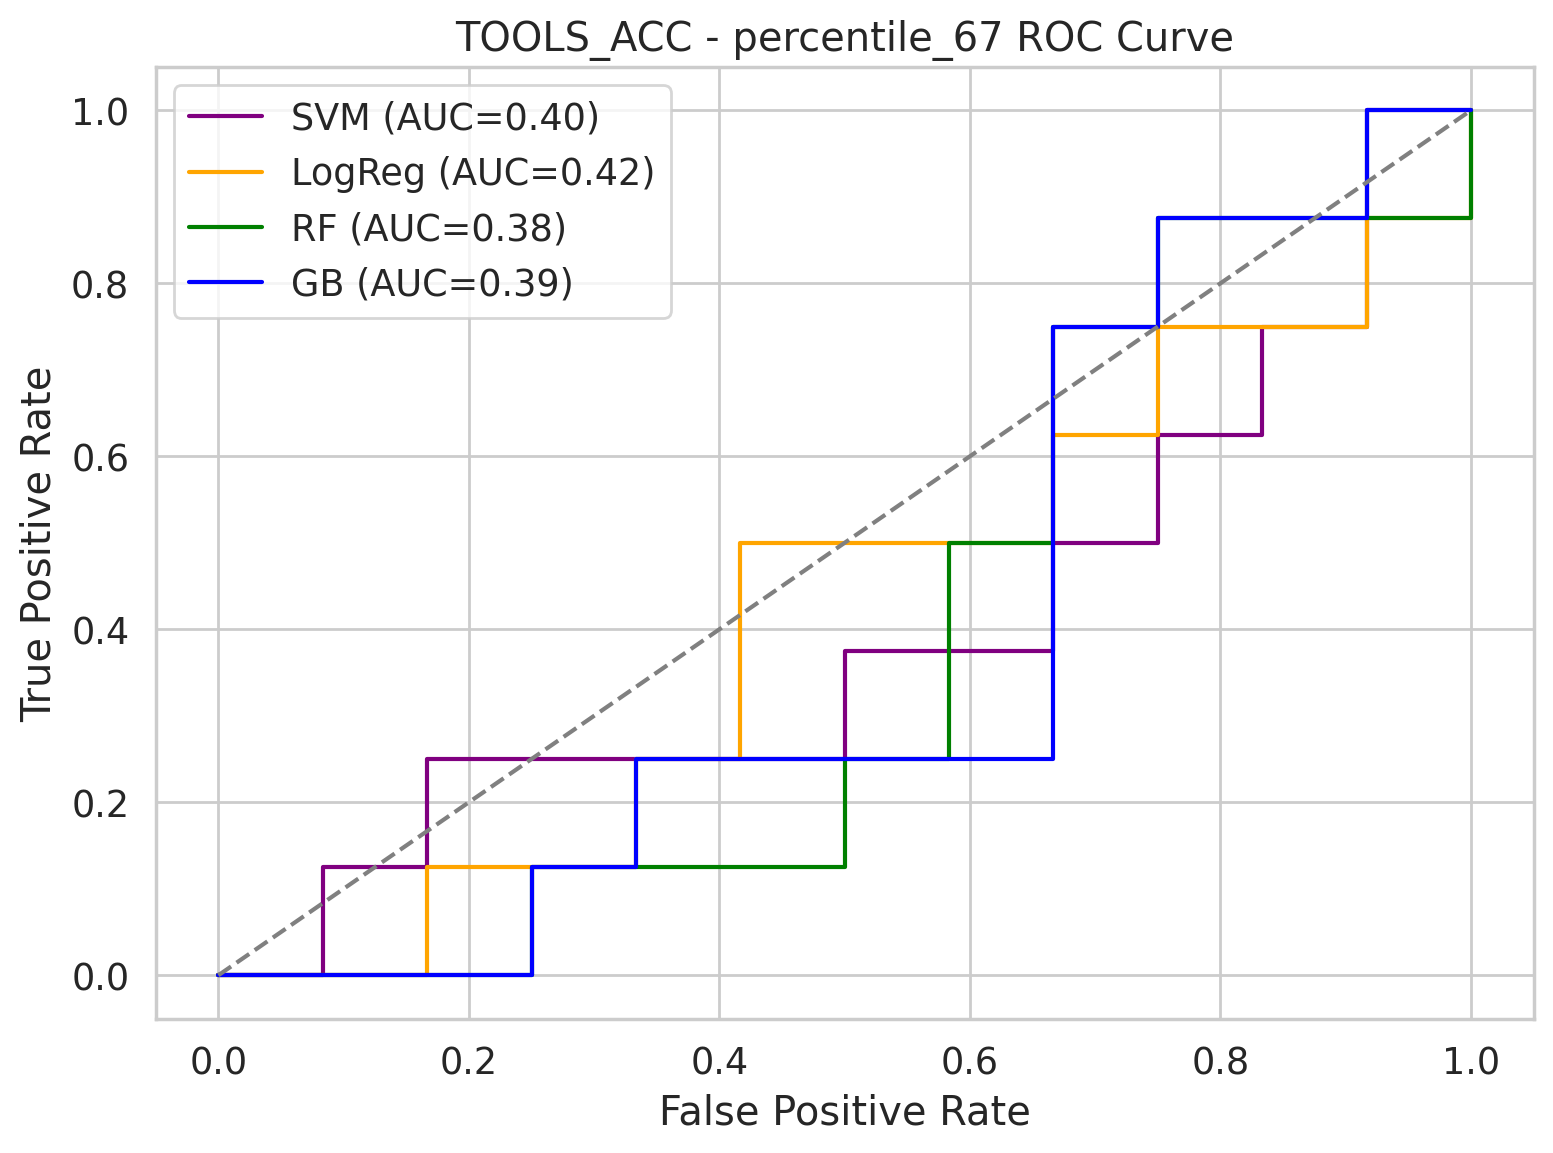


======= TOOLS_ACC | Threshold method: gmm (thr: 0.792) =======
PCA n_components: 35 | Explained Var: 0.95
[SVM]               precision    recall  f1-score   support

           0      0.500     0.200     0.286         5
           1      0.778     0.933     0.848        15

    accuracy                          0.750        20
   macro avg      0.639     0.567     0.567        20
weighted avg      0.708     0.750     0.708        20
 Acc: 0.75, AUC: 0.37
[LR]               precision    recall  f1-score   support

           0      0.000     0.000     0.000         5
           1      0.643     0.600     0.621        15

    accuracy                          0.450        20
   macro avg      0.321     0.300     0.310        20
weighted avg      0.482     0.450     0.466        20
 Acc: 0.45, AUC: 0.31
[RF]               precision    recall  f1-score   support

           0      0.000     0.000     0.000         5
           1      0.750     1.000     0.857        15

    accuracy     

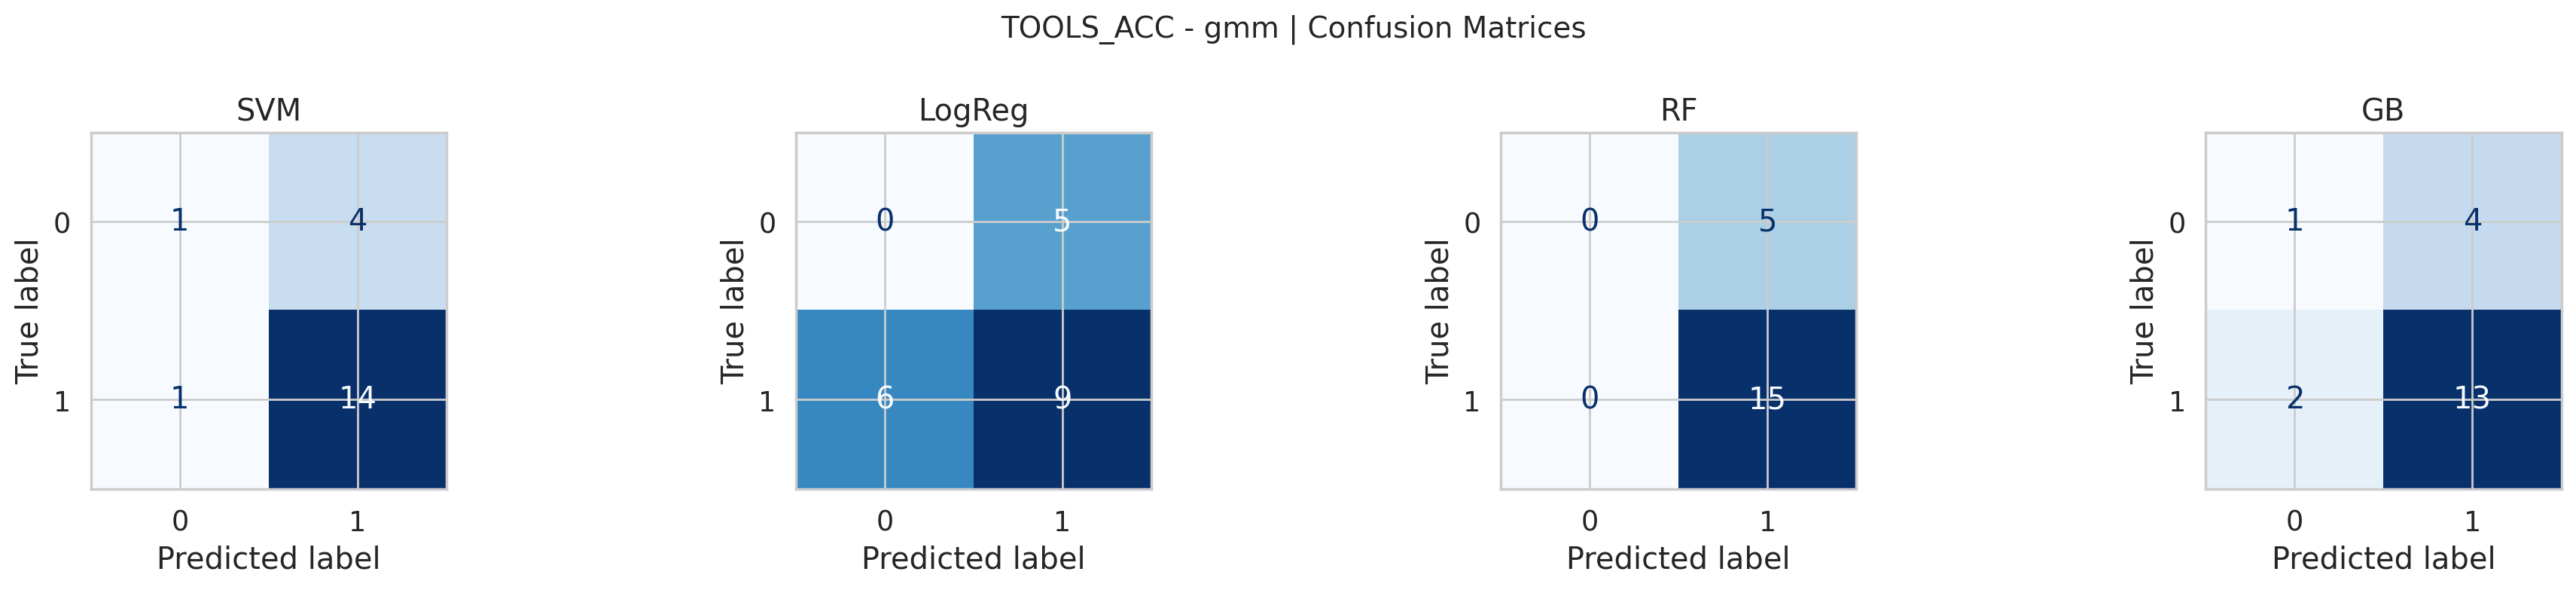

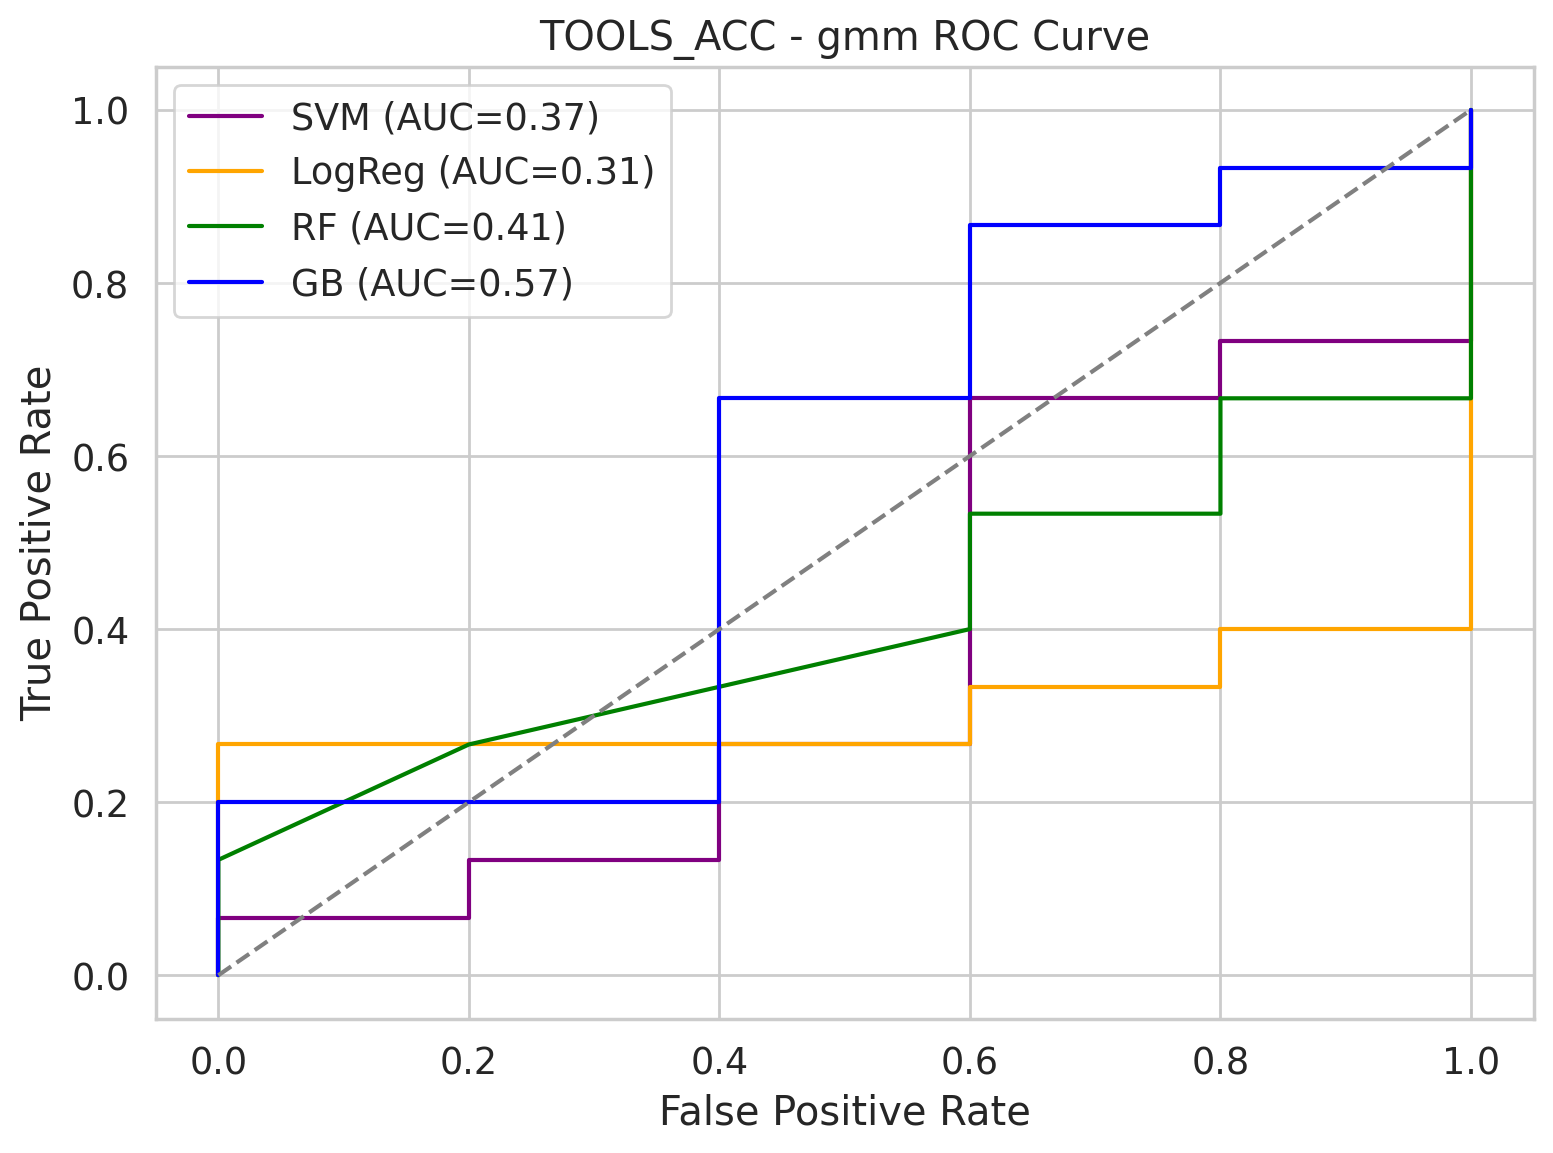


========== Model Comparison Across All Tasks & Thresholds ==========
          Task   ThreshMethod  SVM_Acc  LR_Acc  RF_Acc  GB_Acc   SVM_AUC  \
0       BP_ACC         median     0.55    0.60    0.40    0.60  0.520000   
1       BP_ACC  percentile_67     0.65    0.35    0.55    0.70  0.500000   
2       BP_ACC            gmm     0.55    0.60    0.40    0.60  0.520000   
3    FACES_ACC         median     0.60    0.40    0.60    0.40  0.500000   
4    FACES_ACC  percentile_67     0.60    0.55    0.55    0.45  0.500000   
5    FACES_ACC            gmm     0.75    0.70    0.75    0.75  0.500000   
6   PLACES_ACC         median     0.60    0.35    0.45    0.50  0.500000   
7   PLACES_ACC  percentile_67     0.55    0.45    0.25    0.35  0.500000   
8   PLACES_ACC            gmm     0.60    0.35    0.45    0.50  0.500000   
9    TOOLS_ACC         median     0.60    0.45    0.60    0.70  0.500000   
10   TOOLS_ACC  percentile_67     0.60    0.45    0.60    0.65  0.500000   
11   TOOLS_ACC    

In [ ]:
from sklearn.ensemble import GradientBoostingClassifier  # جدید
from sklearn.metrics import (
    classification_report, confusion_matrix, ConfusionMatrixDisplay,
    roc_auc_score, roc_curve
)
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.mixture import GaussianMixture
import warnings
warnings.filterwarnings('ignore')


for task in tasks:
    X = z_FC_upper[task]
    acc = grouped[task].values

    for method in THRESHOLD_METHODS:
        y, threshold = get_labels(acc, method=method, percentile=PERCENTILE)
        if len(np.unique(y)) != 2:
            print(f"Skipping {task}-{method} because binary split failed (all one class).")
            continue

        print(f"\n======= {task} | Threshold method: {method} (thr: {threshold:.3f}) =======")
        X_train, X_test, y_train, y_test = train_test_split(
            X, y, test_size=0.2, random_state=42, stratify=y
        )

        scaler = StandardScaler()
        X_train_std = scaler.fit_transform(X_train)
        X_test_std = scaler.transform(X_test)

        pca = PCA(n_components=PCA_VAR, svd_solver="full", random_state=42)
        X_train_pca = pca.fit_transform(X_train_std)
        X_test_pca = pca.transform(X_test_std)
        print(f"PCA n_components: {X_train_pca.shape[1]} | Explained Var: {np.sum(pca.explained_variance_ratio_):.2f}")

        cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=1)

        # --- SVM ---
        svm = SVC(class_weight='balanced', probability=True, random_state=42)
        svm_grid = GridSearchCV(svm, svm_param_grid, cv=cv, scoring='accuracy', n_jobs=-1)
        svm_grid.fit(X_train_pca, y_train)
        y_pred_svm = svm_grid.predict(X_test_pca)
        y_prob_svm = svm_grid.predict_proba(X_test_pca)[:,1]
        acc_svm = np.mean(y_pred_svm == y_test)
        auc_svm = roc_auc_score(y_test, y_prob_svm)
        print('[SVM]', classification_report(y_test, y_pred_svm, digits=3), f"Acc: {acc_svm:.2f}, AUC: {auc_svm:.2f}")

        # --- LR ---
        lr = LogisticRegression(random_state=42)
        lr_grid = GridSearchCV(lr, lr_param_grid, cv=cv, scoring='accuracy', n_jobs=-1)
        lr_grid.fit(X_train_pca, y_train)
        y_pred_lr = lr_grid.predict(X_test_pca)
        y_prob_lr = lr_grid.predict_proba(X_test_pca)[:,1]
        acc_lr = np.mean(y_pred_lr == y_test)
        auc_lr = roc_auc_score(y_test, y_prob_lr)
        print('[LR]', classification_report(y_test, y_pred_lr, digits=3), f"Acc: {acc_lr:.2f}, AUC: {auc_lr:.2f}")

        # --- RF ---
        rf = RandomForestClassifier()
        rf_grid = GridSearchCV(rf, rf_param_grid, cv=cv, scoring='accuracy', n_jobs=-1)
        rf_grid.fit(X_train_pca, y_train)
        y_pred_rf = rf_grid.predict(X_test_pca)
        y_prob_rf = rf_grid.predict_proba(X_test_pca)[:,1]
        acc_rf = np.mean(y_pred_rf == y_test)
        auc_rf = roc_auc_score(y_test, y_prob_rf)
        print('[RF]', classification_report(y_test, y_pred_rf, digits=3), f"Acc: {acc_rf:.2f}, AUC: {auc_rf:.2f}")

        # --- Gradient Boosting ---
        gb = GradientBoostingClassifier(random_state=42)
        gb.fit(X_train_pca, y_train)
        y_pred_gb = gb.predict(X_test_pca)
        y_prob_gb = gb.predict_proba(X_test_pca)[:,1]
        acc_gb = np.mean(y_pred_gb == y_test)
        auc_gb = roc_auc_score(y_test, y_prob_gb)
        print('[GB]', classification_report(y_test, y_pred_gb, digits=3), f"Acc: {acc_gb:.2f}, AUC: {auc_gb:.2f}")

        results.append({
            'Task': task, 'ThreshMethod': method,
            'ThreshValue': threshold,
            'SVM_Acc': acc_svm,   'SVM_AUC': auc_svm,
            'LR_Acc': acc_lr,     'LR_AUC': auc_lr,
            'RF_Acc': acc_rf,     'RF_AUC': auc_rf,
            'GB_Acc': acc_gb,     'GB_AUC': auc_gb
        })

        # --- Confusion Matrices ---
        fig, axs = plt.subplots(1, 4, figsize=(19, 4))
        for ax, y_pred, title in zip(
            axs, [y_pred_svm, y_pred_lr, y_pred_rf, y_pred_gb], ['SVM', 'LogReg', 'RF', 'GB']
        ):
            ConfusionMatrixDisplay.from_predictions(y_test, y_pred, ax=ax, cmap="Blues", colorbar=False)
            ax.set_title(title)
        fig.suptitle(f"{task} - {method} | Confusion Matrices", fontsize=14)
        plt.tight_layout()
        plt.show()

        # --- ROC Curves ---
        fpr_svm, tpr_svm, _ = roc_curve(y_test, y_prob_svm)
        fpr_lr, tpr_lr, _ = roc_curve(y_test, y_prob_lr)
        fpr_rf, tpr_rf, _ = roc_curve(y_test, y_prob_rf)
        fpr_gb, tpr_gb, _ = roc_curve(y_test, y_prob_gb)
        plt.figure(figsize=(8, 6))
        plt.plot(fpr_svm, tpr_svm, label=f'SVM (AUC={auc_svm:.2f})', color='purple')
        plt.plot(fpr_lr, tpr_lr, label=f'LogReg (AUC={auc_lr:.2f})', color='orange')
        plt.plot(fpr_rf, tpr_rf, label=f'RF (AUC={auc_rf:.2f})', color='green')
        plt.plot(fpr_gb, tpr_gb, label=f'GB (AUC={auc_gb:.2f})', color='blue')
        plt.plot([0,1], [0,1], '--', color='gray')
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title(f'{task} - {method} ROC Curve')
        plt.legend()
        plt.grid(True)
        plt.show()

# ---- Summary Table ----
results_network_df = pd.DataFrame(results)
print("\n========== Model Comparison Across All Tasks & Thresholds ==========")
print(results_network_df[['Task','ThreshMethod','SVM_Acc','LR_Acc','RF_Acc','GB_Acc','SVM_AUC','LR_AUC','RF_AUC','GB_AUC']])


Task BestModel ThresholdMethod  Value
0      BP_ACC        RF   percentile_67   0.80
1   FACES_ACC       SVM             gmm   0.75
2  PLACES_ACC        GB   percentile_67   0.65
3   TOOLS_ACC       SVM             gmm   0.75

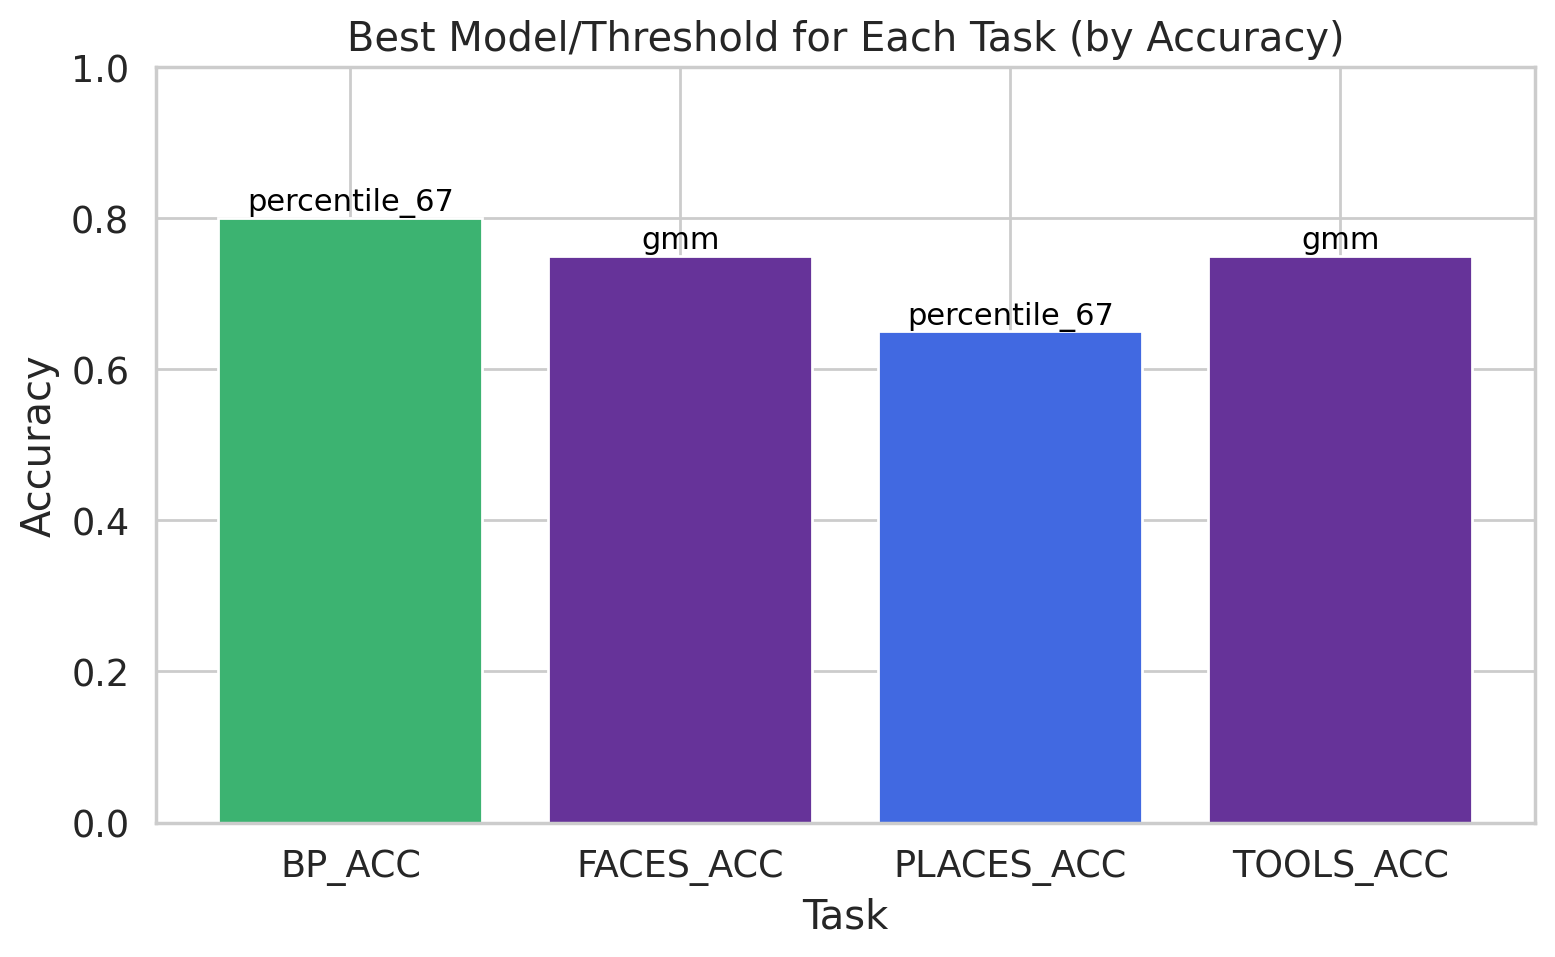

Task: BP_ACC | Best Model: RF | Threshold: percentile_67 | Accuracy: 0.80
Task: FACES_ACC | Best Model: SVM | Threshold: gmm | Accuracy: 0.75
Task: PLACES_ACC | Best Model: GB | Threshold: percentile_67 | Accuracy: 0.65
Task: TOOLS_ACC | Best Model: SVM | Threshold: gmm | Accuracy: 0.75


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

def get_best_for_each_task(df, metric='Acc'):
    records = []
    model_list = ['SVM', 'LR', 'RF', 'GB']
    for task in df['Task'].unique():
        sub = df[df['Task']==task]
        best_val = -999
        best_model = None
        best_method = None
        for mi in model_list:
            idx = sub[f'{mi}_{metric}'].idxmax()
            val = sub.loc[idx, f'{mi}_{metric}']
            if val > best_val:
                best_val = val
                best_model = mi
                best_method = sub.loc[idx, 'ThreshMethod']
        records.append(dict(Task=task, BestModel=best_model, ThresholdMethod=best_method, Value=best_val))
    return pd.DataFrame(records)

best_df = get_best_for_each_task(results_network_df, metric='Acc')
display(best_df)

plt.figure(figsize=(8,5))
colors = {
    'SVM':'rebeccapurple',
    'LR':'darkorange',
    'RF':'mediumseagreen',
    'GB':'royalblue'
}
bars = plt.bar(best_df.Task, best_df.Value, color=[colors[m] for m in best_df.BestModel])
for bar, method in zip(bars, best_df.ThresholdMethod):
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, height+0.01, f'{method}', ha='center', fontsize=11, color='black')
plt.title('Best Model/Threshold for Each Task (by Accuracy)')
plt.ylabel('Accuracy')
plt.ylim(0, 1)
plt.xlabel('Task')
plt.tight_layout()
plt.show()

for i, row in best_df.iterrows():
    print(f"Task: {row.Task} | Best Model: {row.BestModel} | Threshold: {row.ThresholdMethod} | Accuracy: {row.Value:.2f}")


In [ ]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split, KFold, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVR
from sklearn.linear_model import Ridge
from sklearn.decomposition import PCA
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
import warnings
warnings.filterwarnings('ignore')

# --- INPUTS ---
df_acc = pd.read_csv('wm_2back_accuracies.csv')
grouped = df_acc.groupby('subject')[['BP_ACC', 'FACES_ACC', 'PLACES_ACC', 'TOOLS_ACC']].mean().reset_index()
tasks = ['BP_ACC', 'FACES_ACC', 'PLACES_ACC', 'TOOLS_ACC']

# --- Parameter grids ---
svr_param_grid = {
    'C': [0.01, 0.1, 1, 10, 100],
    'kernel': ['linear', 'rbf'],
    'gamma': ['scale', 'auto']
}
ridge_param_grid = {
    'alpha': [0.01, 0.1, 1, 10, 100]
}

for task in tasks:
    print(f"\n===== {task} (Regression) =====")
    X = z_FC_upper[task]  # shape: (subjects, 66)
    y = grouped[task].values  # Actual ACCs (continuous)

    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42
    )

    scaler = StandardScaler()
    X_train_std = scaler.fit_transform(X_train)
    X_test_std = scaler.transform(X_test)

    pca = PCA(n_components=0.95, svd_solver="full", random_state=42)
    X_train_pca = pca.fit_transform(X_train_std)
    X_test_pca = pca.transform(X_test_std)
    print(f"PCA components: {X_train_pca.shape[1]} (Explained var: {np.sum(pca.explained_variance_ratio_):.2f})")

    cv = KFold(n_splits=3, shuffle=True, random_state=1)

    # SVR
    svr = SVR()
    svr_grid = GridSearchCV(svr, svr_param_grid, cv=cv, scoring='neg_mean_squared_error', n_jobs=-1, error_score='raise')
    svr_grid.fit(X_train_pca, y_train)
    y_pred_svr = svr_grid.predict(X_test_pca)
    print('\n[ SVR ]')
    print('Best Params:', svr_grid.best_params_)
    print('Test MSE:', mean_squared_error(y_test, y_pred_svr))
    print('Test MAE:', mean_absolute_error(y_test, y_pred_svr))
    print('Test R2:', r2_score(y_test, y_pred_svr))

    # Ridge Regression
    ridge = Ridge(random_state=42)
    ridge_grid = GridSearchCV(ridge, ridge_param_grid, cv=cv, scoring='neg_mean_squared_error', n_jobs=-1, error_score='raise')
    ridge_grid.fit(X_train_pca, y_train)
    y_pred_ridge = ridge_grid.predict(X_test_pca)
    print('\n[ Ridge Regression ]')
    print('Best Params:', ridge_grid.best_params_)
    print('Test MSE:', mean_squared_error(y_test, y_pred_ridge))
    print('Test MAE:', mean_absolute_error(y_test, y_pred_ridge))
    print('Test R2:', r2_score(y_test, y_pred_ridge))



===== BP_ACC (Regression) =====
PCA components: 69 (Explained var: 0.95)

[ SVR ]
Best Params: {'C': 0.01, 'gamma': 'auto', 'kernel': 'rbf'}
Test MSE: 0.012247448979591836
Test MAE: 0.09035714285714286
Test R2: -0.07729072937586223

[ Ridge Regression ]
Best Params: {'alpha': 100}
Test MSE: 0.0155032218730205
Test MAE: 0.1005879528601447
Test R2: -0.36366987338278145

===== FACES_ACC (Regression) =====
PCA components: 70 (Explained var: 0.95)

[ SVR ]
Best Params: {'C': 0.1, 'gamma': 'auto', 'kernel': 'rbf'}
Test MSE: 0.013775034293552816
Test MAE: 0.10055555555555562
Test R2: -2.489550113615735e-06

[ Ridge Regression ]
Best Params: {'alpha': 100}
Test MSE: 0.01634773464468866
Test MAE: 0.10122818783072826
Test R2: -0.1867683952587047

===== PLACES_ACC (Regression) =====
PCA components: 68 (Explained var: 0.95)

[ SVR ]
Best Params: {'C': 0.1, 'gamma': 'auto', 'kernel': 'rbf'}
Test MSE: 0.012285382231404981
Test MAE: 0.0904545454545457
Test R2: -0.021653408017046294

[ Ridge Regressi

# WHOLE BRAIN **ANALYSIS**

In [20]:
import numpy as np
import os

HCP_DIR = "hcp_task"
subjects_root = os.path.join(HCP_DIR, "subjects")
subject_list = [
    name for name in os.listdir(subjects_root)
    if os.path.isdir(os.path.join(subjects_root, name))
]
print(f"Subjects found: {subject_list}")

experiment = "WM"
runs = [0, 1]
n_frames_per_block = 39
n_parcels = 360

faces_data  = []
places_data = []
body_data   = []
tools_data  = []

for subject in subject_list:
    subject_data = {
        '2bk_faces': [],
        '2bk_places': [],
        '2bk_body': [],
        '2bk_tools': []
    }
    for run in runs:
        try:
            # ۱. بارگذاری تایم‌سریز
            ts = load_single_timeseries(subject, experiment, run, remove_mean=True)  # (360, T)
            ts = ts.T   # (T, 360)
            # ۲. بارگذاری EVs
            evs = load_evs_ours(subject, experiment, run)
            for cond in subject_data:
                block_frames = [frame for block in evs.get(cond, []) for frame in block]
                block_frames = block_frames[:n_frames_per_block]
                if len(block_frames) < n_frames_per_block:
                    print(f"Warning: Subject {subject} condition {cond} (run {run}) has only {len(block_frames)} frames.")
                    continue
                cond_frames_data = ts[block_frames, :]   # (39, 360)
                subject_data[cond].append(cond_frames_data)
        except Exception as e:
            print(f"Error processing subject {subject} run {run}: {e}")
    for cond, storage_list in zip(['2bk_faces', '2bk_places', '2bk_body', '2bk_tools'],
                                  [faces_data,   places_data,   body_data,   tools_data]):
        cond_runs = subject_data[cond]
        if len(cond_runs) == 2:  # هر دو ران موجود
            cond_bothruns = np.concatenate(cond_runs, axis=0)  # shape: (78, 360)
            storage_list.append(cond_bothruns)
        else:
            print(f" Subject {subject} condition {cond}: missed one of the runs.")

# تبدیل به numpy array
faces_data  = np.stack(faces_data)   # (n_subjects, 78, 360)
places_data = np.stack(places_data)
body_data   = np.stack(body_data)
tools_data  = np.stack(tools_data)

print(faces_data.shape, places_data.shape, body_data.shape, tools_data.shape)

np.save('wm_faces_2runs.npy',  faces_data)
np.save('wm_places_2runs.npy', places_data)
np.save('wm_body_2runs.npy',   body_data)
np.save('wm_tools_2runs.npy',  tools_data)


Subjects found: ['111312', '111514', '161731', '192540', '140824', '105216', '148032', '157336', '158540', '100307', '158035', '189450', '120212', '199655', '122317', '135932', '111716', '172332', '176542', '163129', '149337', '201111', '138231', '110411', '196144', '130316', '175439', '130922', '133827', '133625', '119833', '115320', '196750', '197550', '103414', '133928', '162733', '102816', '153025', '160123', '113215', '106319', '125525', '201414', '163432', '128632', '134324', '100408', '118932', '126325', '137128', '124422', '117122', '117324', '106016', '111009', '150524', '151223', '103818', '151627', '193239', '142828', '198451', '162329', '153429', '143325', '188347', '105115', '123117', '138534', '156233', '200614', '118730', '178950', '159340', '182739', '130013', '190031', '194140', '192439', '154431', '120111', '127933', '167743', '156637', '114924', '151526', '148335', '159239', '199150', '185139', '149539', '139637', '103515', '129028', '136833', '101915', '205119', '11

In [21]:
import numpy as np

# لود دیتای تلفیقی هر تسک:
faces_data  = np.load('wm_faces_2runs.npy')    # shape: (N, 78, 360)
places_data = np.load('wm_places_2runs.npy')
body_data   = np.load('wm_body_2runs.npy')
tools_data  = np.load('wm_tools_2runs.npy')

# کمک‌تابع ساخت FC + Fisher Z برای هر سابجکت
def build_fc_matrices(data_3d):
    n_sub = data_3d.shape[0]
    n_parc = data_3d.shape[2]
    all_conn = np.zeros((n_sub, n_parc, n_parc))
    for i in range(n_sub):
        ts = data_3d[i]   # shape: (78, 360)
        fc = np.corrcoef(ts, rowvar=False)   # shape: (360, 360)
        np.fill_diagonal(fc, 0)
        zfc = np.arctanh(fc)                 # Fisher z-transform
        all_conn[i] = zfc
    return all_conn

# ساخت ماتریس‌های FC با Z-transform
faces_fc  = build_fc_matrices(faces_data)    # (n_subjects, 360, 360)
places_fc = build_fc_matrices(places_data)
body_fc   = build_fc_matrices(body_data)
tools_fc  = build_fc_matrices(tools_data)

# استخراج Upper triangle (بدون قطر) هر ماتریس
def fc_to_upper_vec(fc_arr):
    n_subjects, n, _ = fc_arr.shape
    iu = np.triu_indices(n, k=1)  # upper-triangle بدون قطر
    out = np.zeros((n_subjects, len(iu[0])))
    for i in range(n_subjects):
        out[i,:] = fc_arr[i][iu]
    return out

# تبدیل FC هر سابجکت به وکتور feature (برای ورود به مدل ML)
faces_up  = fc_to_upper_vec(faces_fc)    # shape: (n_subjects, 64620)
places_up = fc_to_upper_vec(places_fc)
body_up   = fc_to_upper_vec(body_fc)
tools_up  = fc_to_upper_vec(tools_fc)

print("faces_up shape:", faces_up.shape)
print("places_up shape:", places_up.shape)
print("body_up shape:", body_up.shape)
print("tools_up shape:", tools_up.shape)

# اگر خواستی ذخیره کنی:
np.save("faces_fc_upper.npy",  faces_up)
np.save("places_fc_upper.npy", places_up)
np.save("body_fc_upper.npy",   body_up)
np.save("tools_fc_upper.npy",  tools_up)


faces_up shape: (100, 64620)
places_up shape: (100, 64620)
body_up shape: (100, 64620)
tools_up shape: (100, 64620)


Data loaded: {'FACES_ACC': (100, 64620), 'PLACES_ACC': (100, 64620), 'BP_ACC': (100, 64620), 'TOOLS_ACC': (100, 64620)}

======= BP_ACC | Threshold method: median (thr: 0.775) =======
PCA n_components: 69 | Explained Var: 0.95
[SVM]               precision    recall  f1-score   support

           0      0.556     0.500     0.526        10
           1      0.545     0.600     0.571        10

    accuracy                          0.550        20
   macro avg      0.551     0.550     0.549        20
weighted avg      0.551     0.550     0.549        20
 Acc: 0.55, AUC: 0.52
[LR]               precision    recall  f1-score   support

           0      0.583     0.700     0.636        10
           1      0.625     0.500     0.556        10

    accuracy                          0.600        20
   macro avg      0.604     0.600     0.596        20
weighted avg      0.604     0.600     0.596        20
 Acc: 0.60, AUC: 0.51
[RF]               precision    recall  f1-score   support

      

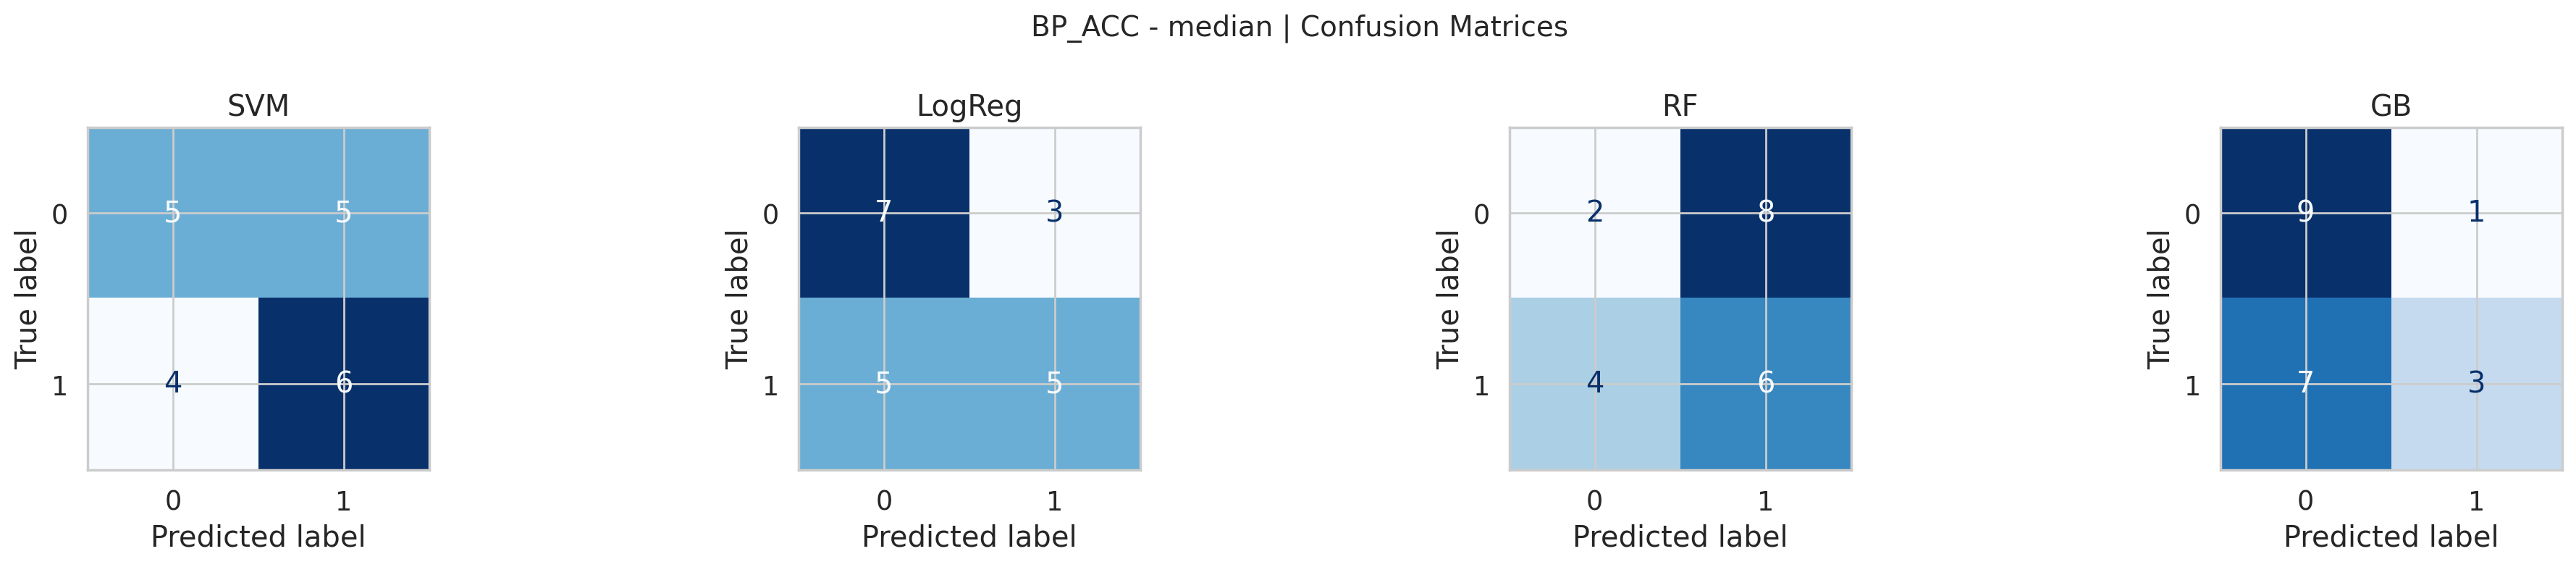

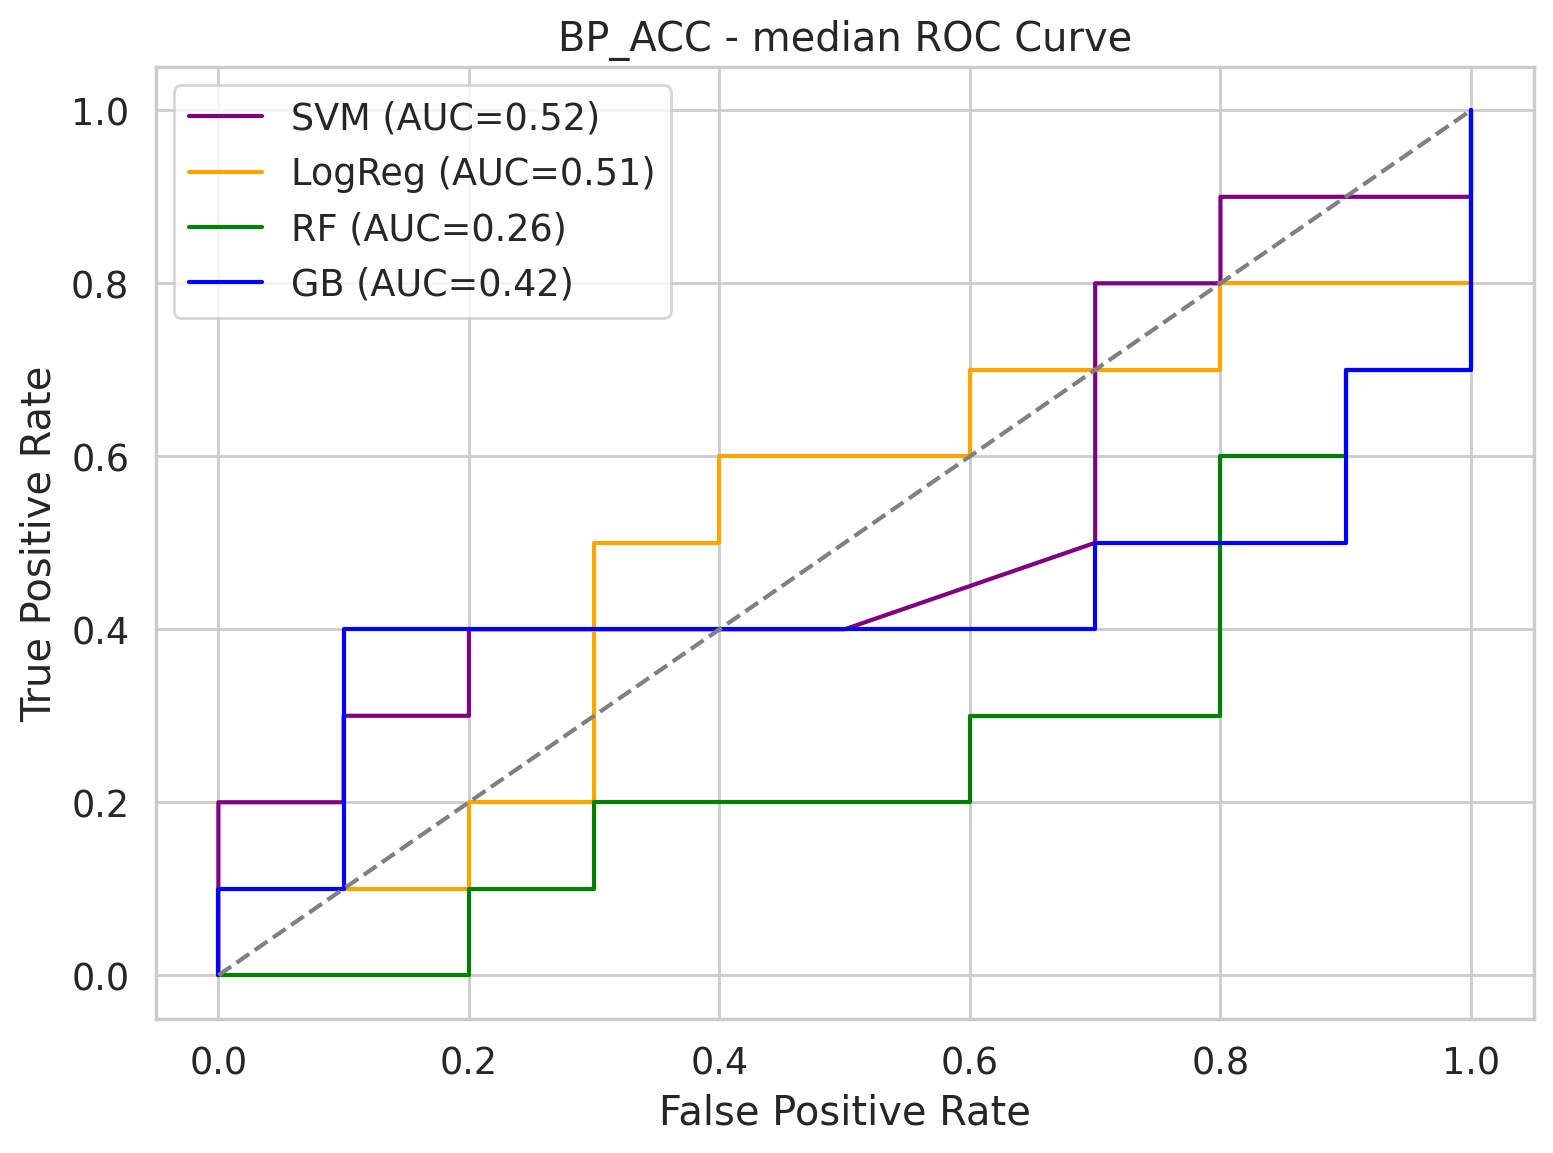


======= BP_ACC | Threshold method: percentile_67 (thr: 0.850) =======
PCA n_components: 69 | Explained Var: 0.95
[SVM]               precision    recall  f1-score   support

           0      0.650     1.000     0.788        13
           1      0.000     0.000     0.000         7

    accuracy                          0.650        20
   macro avg      0.325     0.500     0.394        20
weighted avg      0.423     0.650     0.512        20
 Acc: 0.65, AUC: 0.50
[LR]               precision    recall  f1-score   support

           0      0.500     0.385     0.435        13
           1      0.200     0.286     0.235         7

    accuracy                          0.350        20
   macro avg      0.350     0.335     0.335        20
weighted avg      0.395     0.350     0.365        20
 Acc: 0.35, AUC: 0.23
[RF]               precision    recall  f1-score   support

           0      0.625     0.769     0.690        13
           1      0.250     0.143     0.182         7

    accura

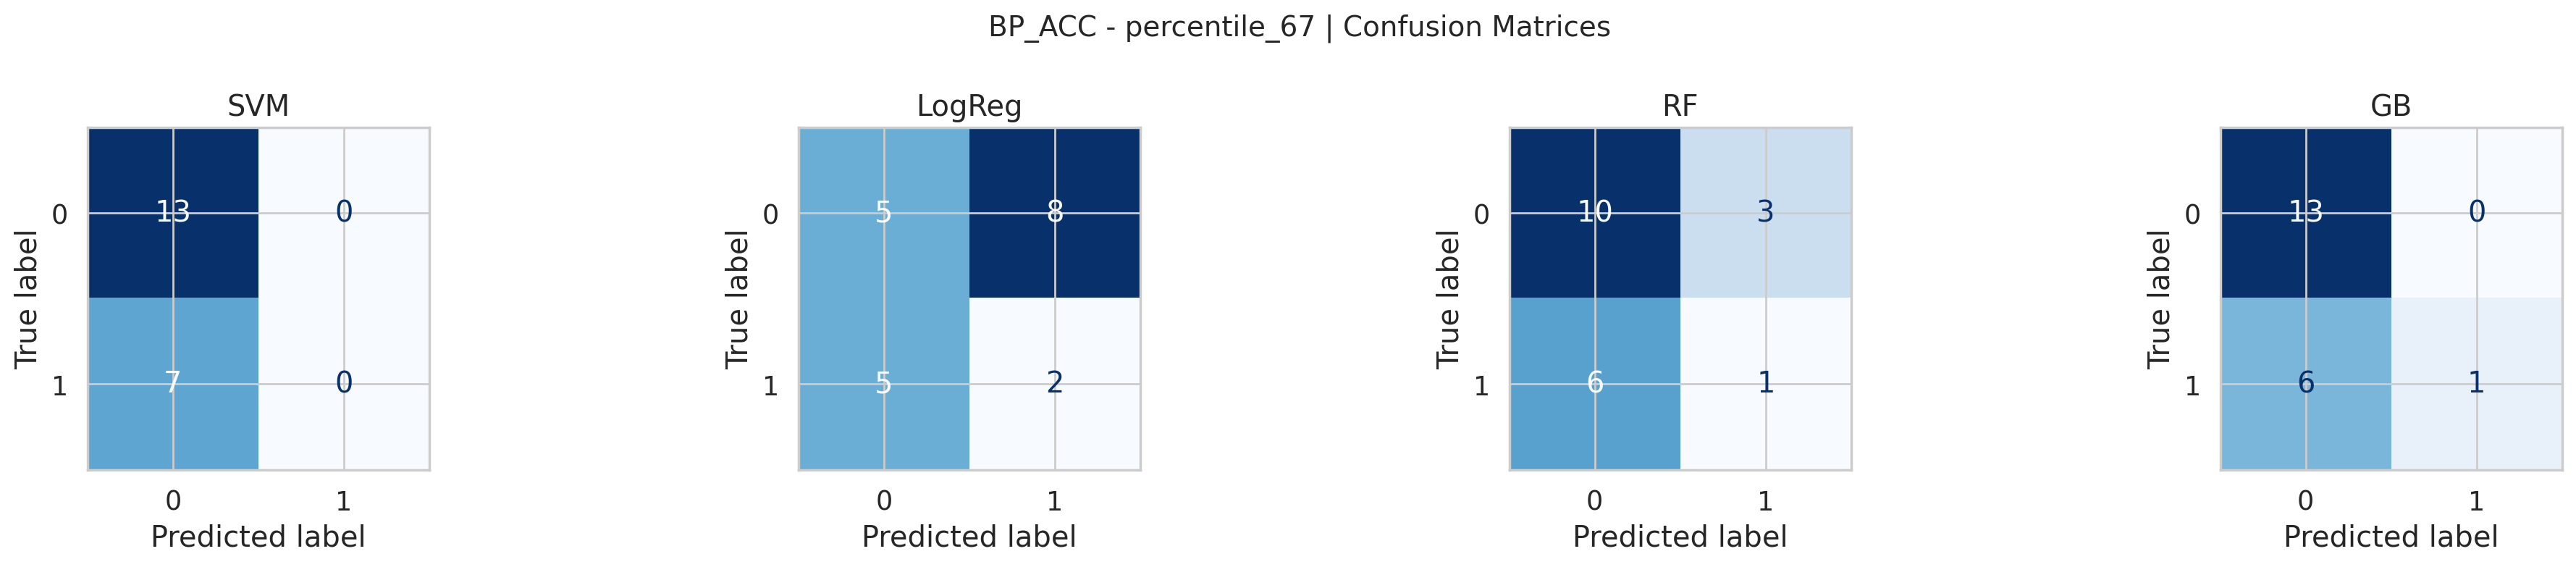

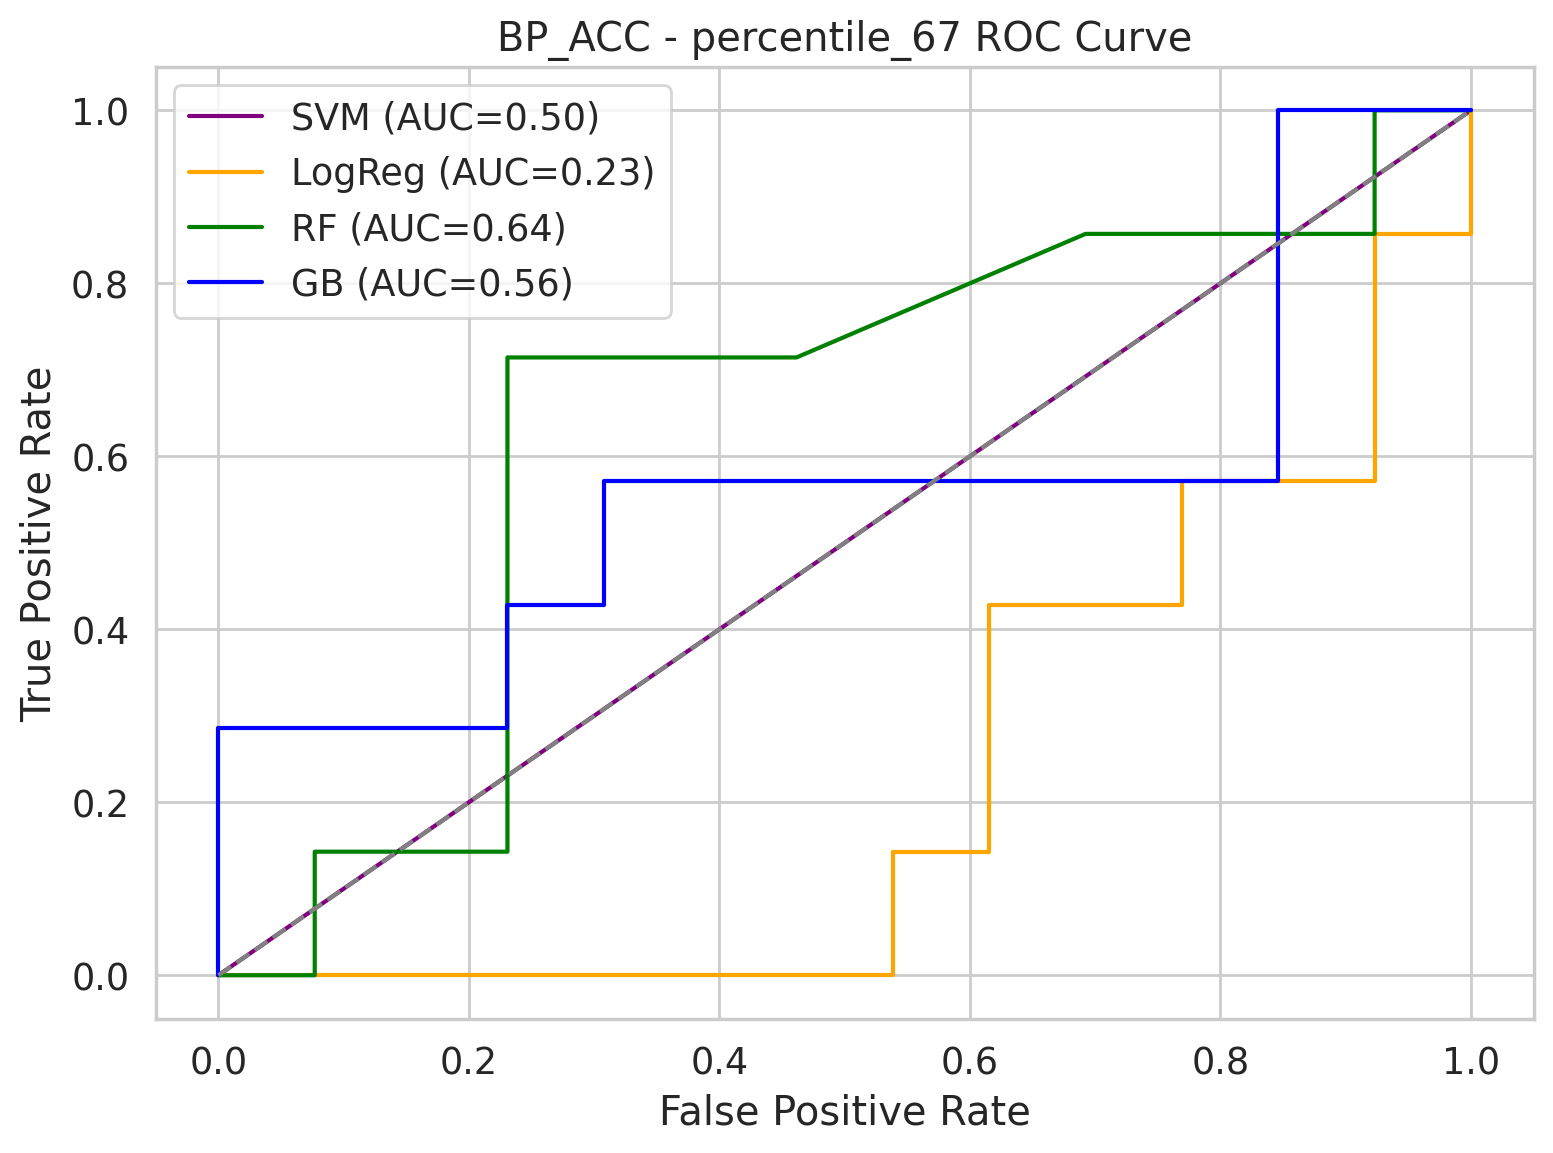


======= BP_ACC | Threshold method: gmm (thr: 0.764) =======
PCA n_components: 69 | Explained Var: 0.95
[SVM]               precision    recall  f1-score   support

           0      0.556     0.500     0.526        10
           1      0.545     0.600     0.571        10

    accuracy                          0.550        20
   macro avg      0.551     0.550     0.549        20
weighted avg      0.551     0.550     0.549        20
 Acc: 0.55, AUC: 0.52
[LR]               precision    recall  f1-score   support

           0      0.583     0.700     0.636        10
           1      0.625     0.500     0.556        10

    accuracy                          0.600        20
   macro avg      0.604     0.600     0.596        20
weighted avg      0.604     0.600     0.596        20
 Acc: 0.60, AUC: 0.51
[RF]               precision    recall  f1-score   support

           0      0.333     0.200     0.250        10
           1      0.429     0.600     0.500        10

    accuracy        

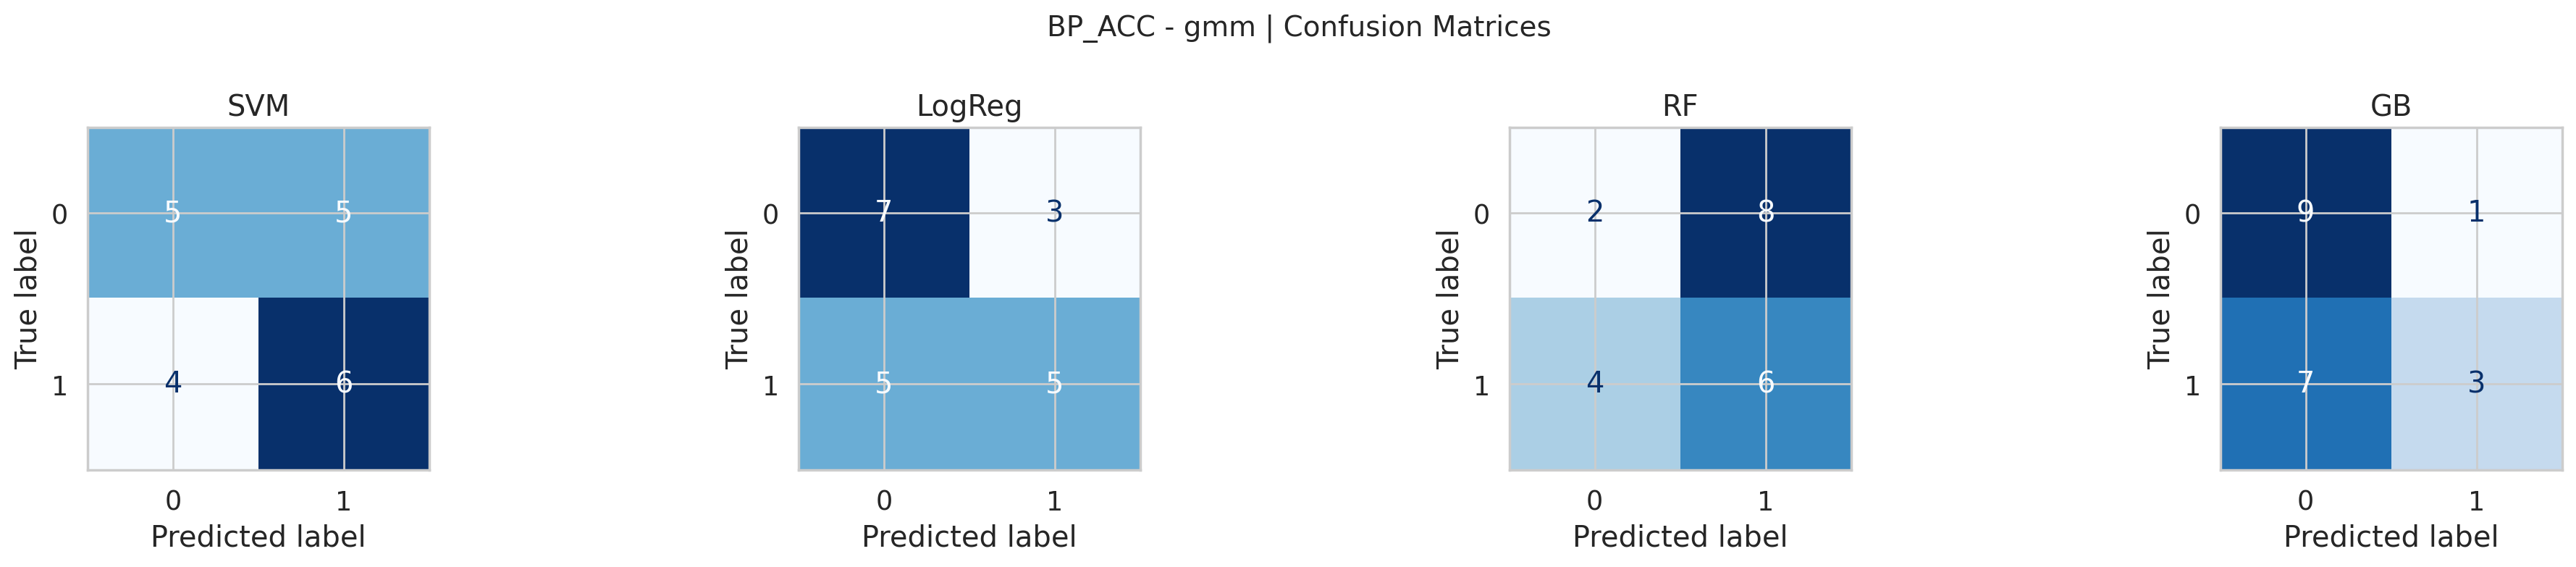

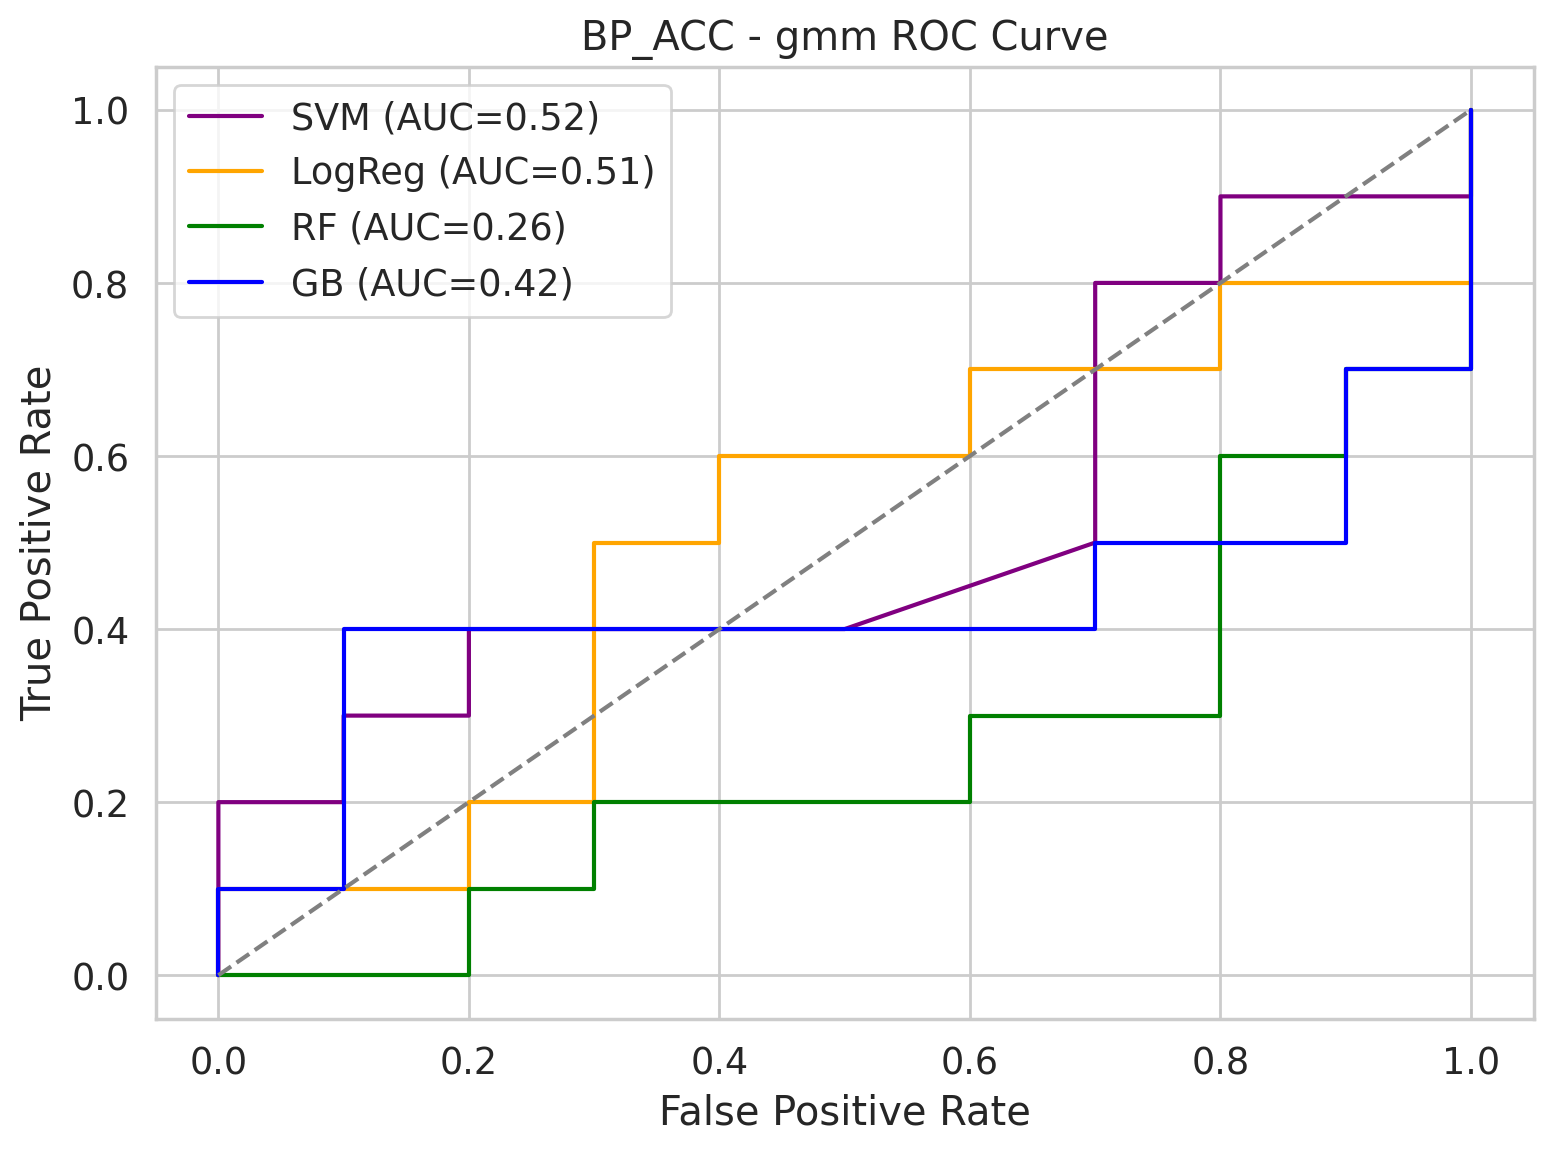


======= FACES_ACC | Threshold method: median (thr: 0.900) =======
PCA n_components: 69 | Explained Var: 0.95
[SVM]               precision    recall  f1-score   support

           0      0.000     0.000     0.000         8
           1      0.600     1.000     0.750        12

    accuracy                          0.600        20
   macro avg      0.300     0.500     0.375        20
weighted avg      0.360     0.600     0.450        20
 Acc: 0.60, AUC: 0.50
[LR]               precision    recall  f1-score   support

           0      0.333     0.500     0.400         8
           1      0.500     0.333     0.400        12

    accuracy                          0.400        20
   macro avg      0.417     0.417     0.400        20
weighted avg      0.433     0.400     0.400        20
 Acc: 0.40, AUC: 0.34
[RF]               precision    recall  f1-score   support

           0      0.000     0.000     0.000         8
           1      0.600     1.000     0.750        12

    accuracy  

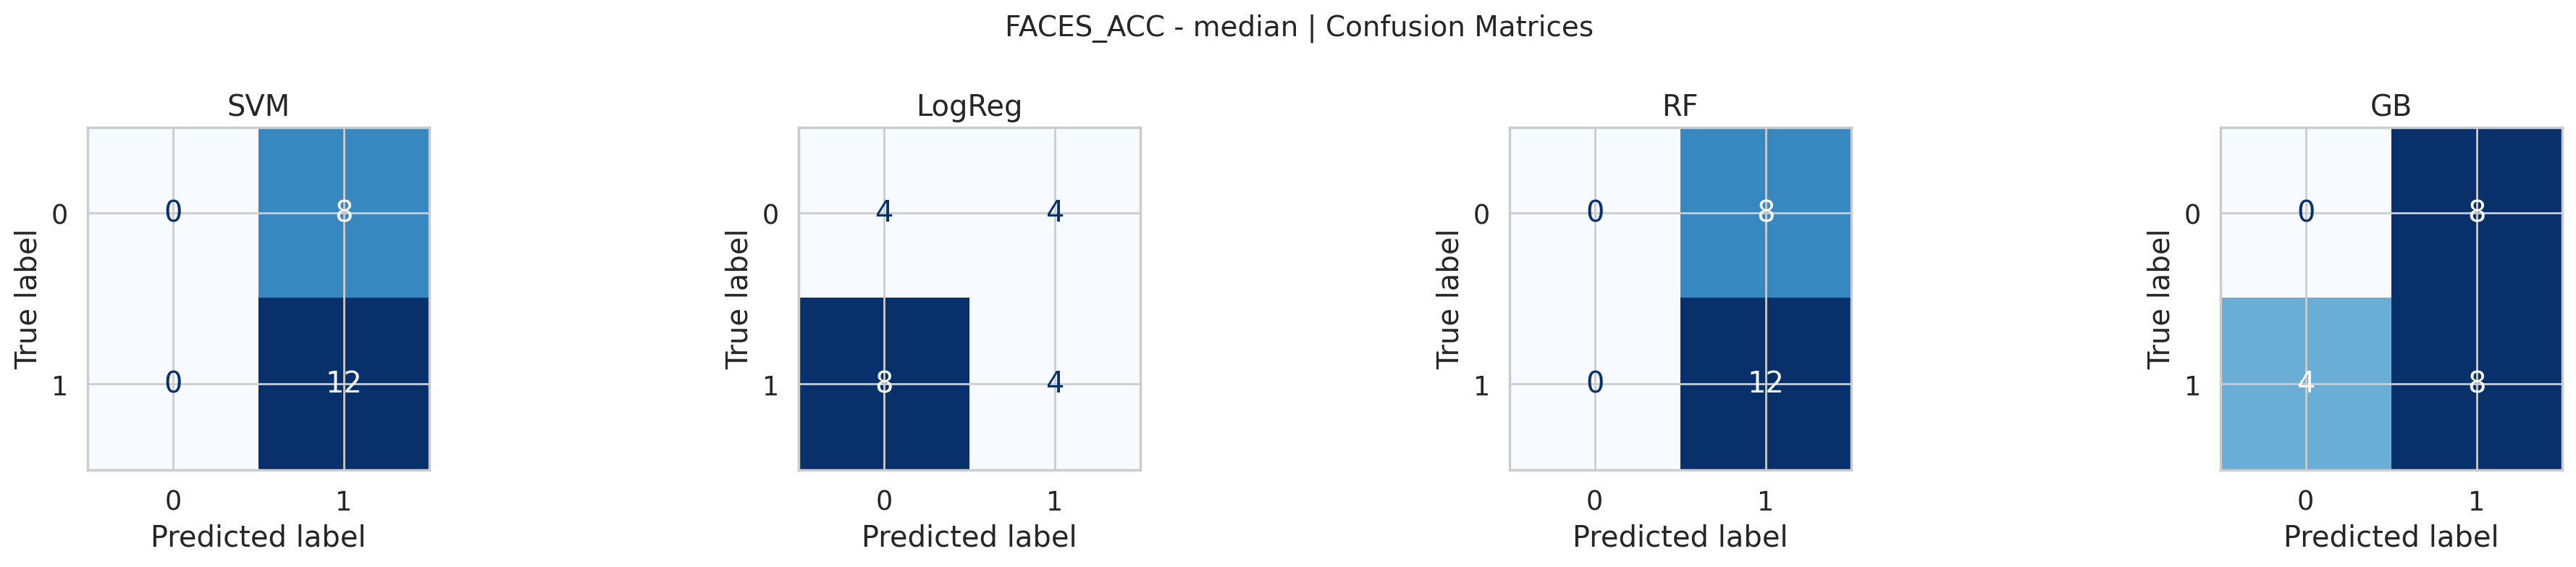

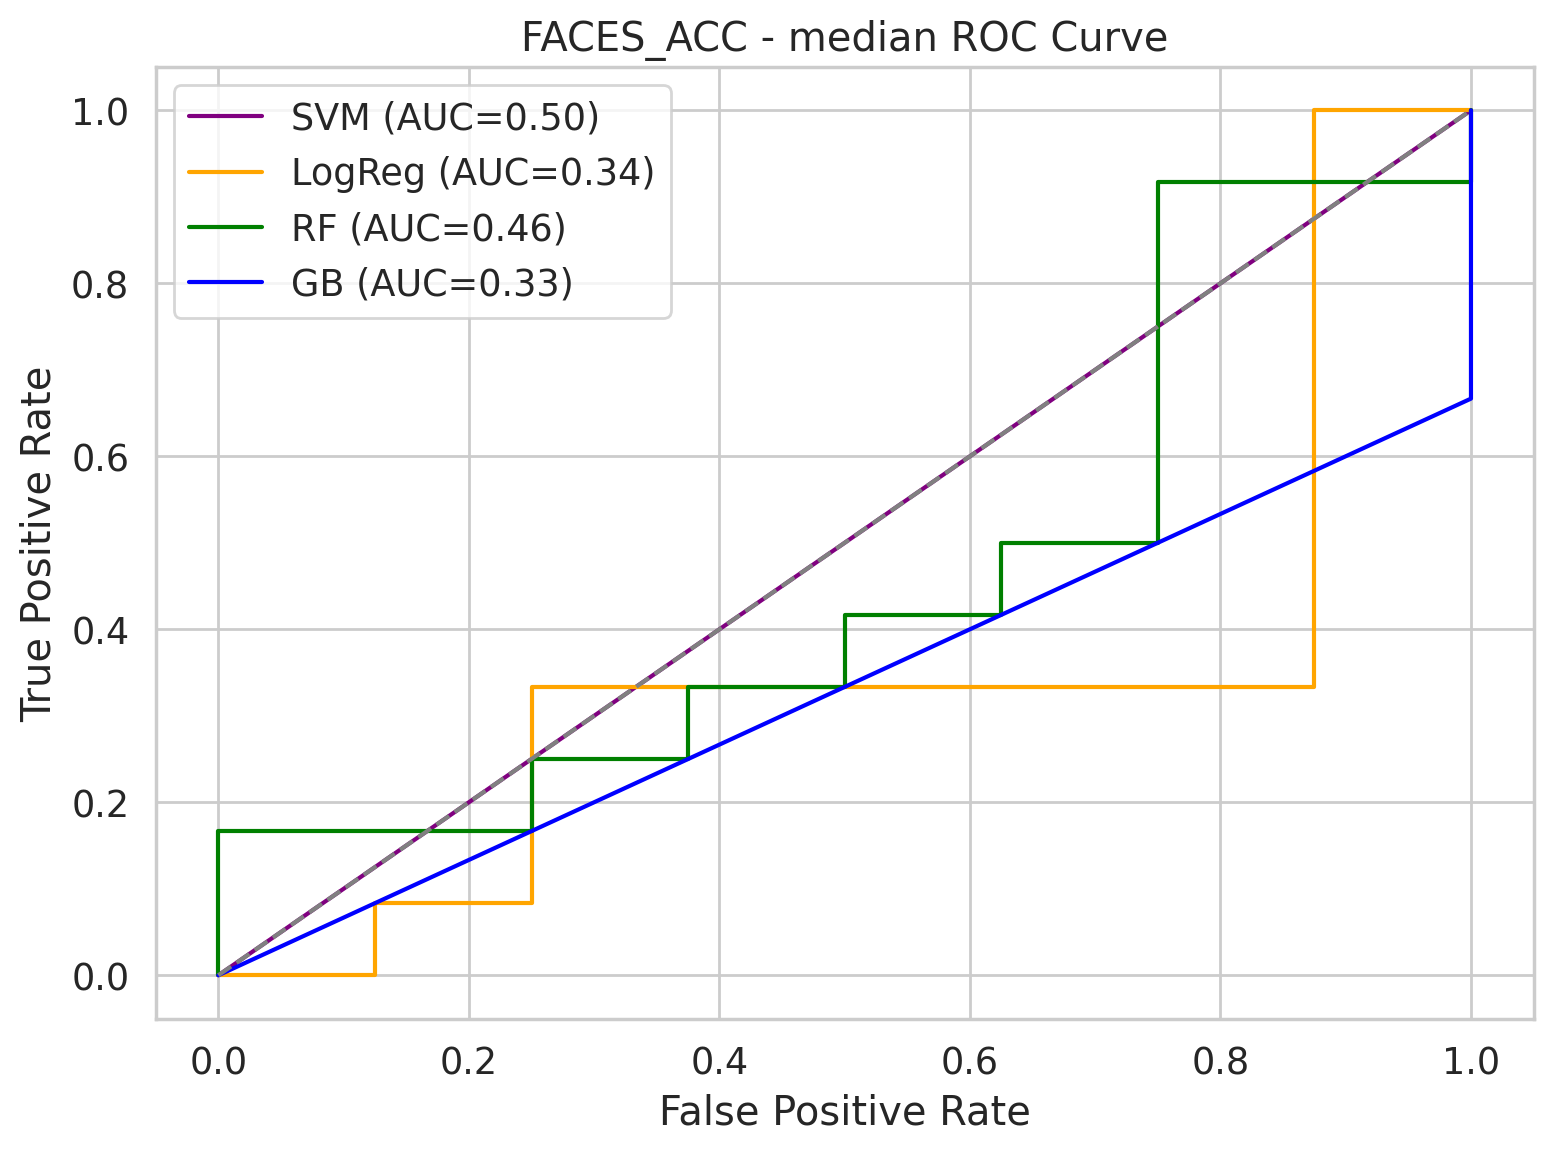


======= FACES_ACC | Threshold method: percentile_67 (thr: 0.950) =======
PCA n_components: 69 | Explained Var: 0.95
[SVM]               precision    recall  f1-score   support

           0      0.600     1.000     0.750        12
           1      0.000     0.000     0.000         8

    accuracy                          0.600        20
   macro avg      0.300     0.500     0.375        20
weighted avg      0.360     0.600     0.450        20
 Acc: 0.60, AUC: 0.50
[LR]               precision    recall  f1-score   support

           0      0.615     0.667     0.640        12
           1      0.429     0.375     0.400         8

    accuracy                          0.550        20
   macro avg      0.522     0.521     0.520        20
weighted avg      0.541     0.550     0.544        20
 Acc: 0.55, AUC: 0.52
[RF]               precision    recall  f1-score   support

           0      0.714     0.417     0.526        12
           1      0.462     0.750     0.571         8

    acc

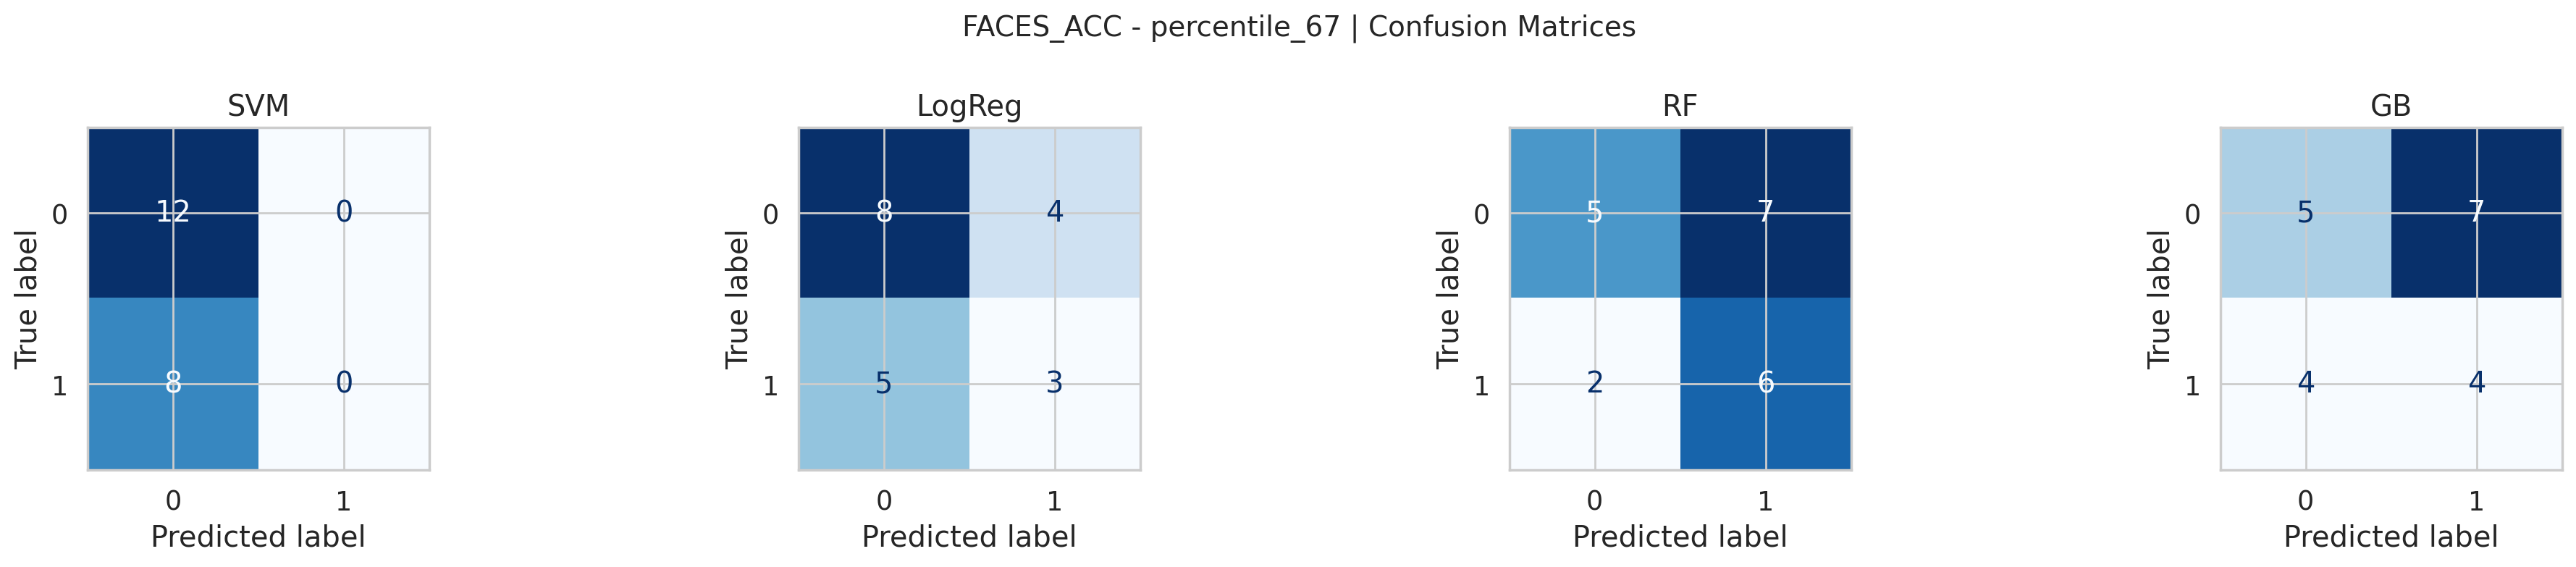

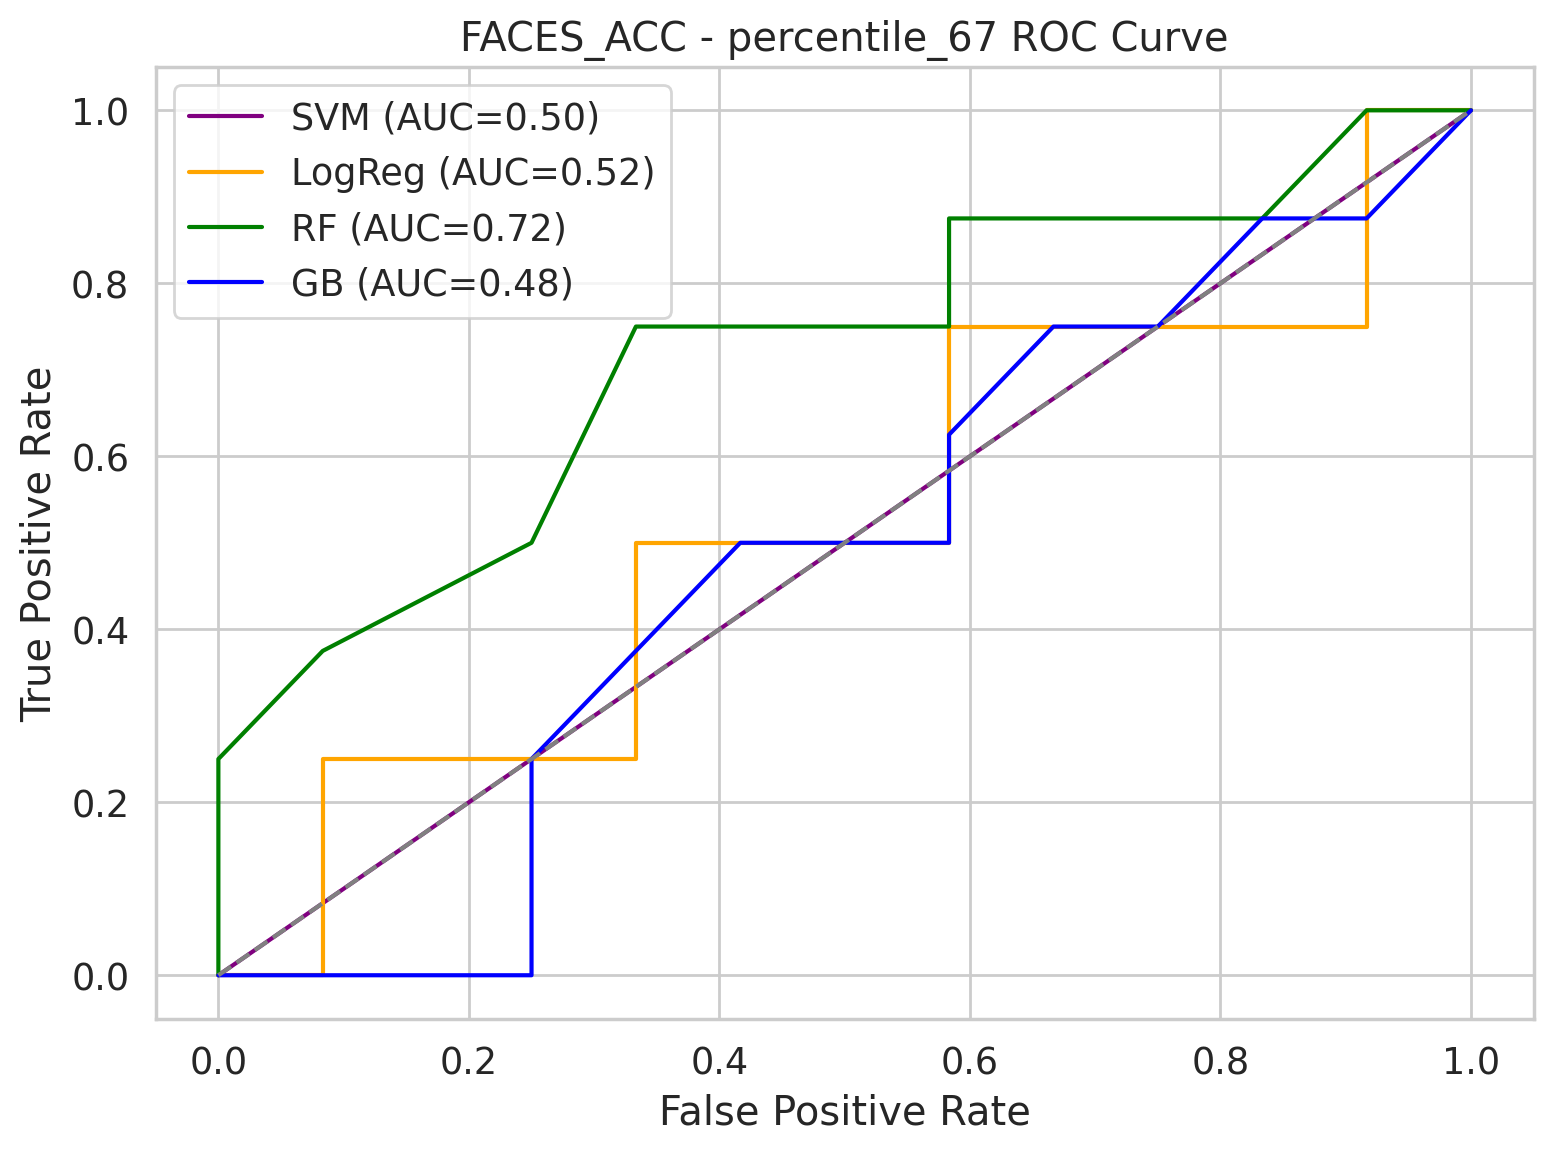


======= FACES_ACC | Threshold method: gmm (thr: 0.842) =======
PCA n_components: 71 | Explained Var: 0.96
[SVM]               precision    recall  f1-score   support

           0      0.000     0.000     0.000         5
           1      0.750     1.000     0.857        15

    accuracy                          0.750        20
   macro avg      0.375     0.500     0.429        20
weighted avg      0.562     0.750     0.643        20
 Acc: 0.75, AUC: 0.50
[LR]               precision    recall  f1-score   support

           0      0.333     0.200     0.250         5
           1      0.765     0.867     0.812        15

    accuracy                          0.700        20
   macro avg      0.549     0.533     0.531        20
weighted avg      0.657     0.700     0.672        20
 Acc: 0.70, AUC: 0.32
[RF]               precision    recall  f1-score   support

           0      0.000     0.000     0.000         5
           1      0.750     1.000     0.857        15

    accuracy     

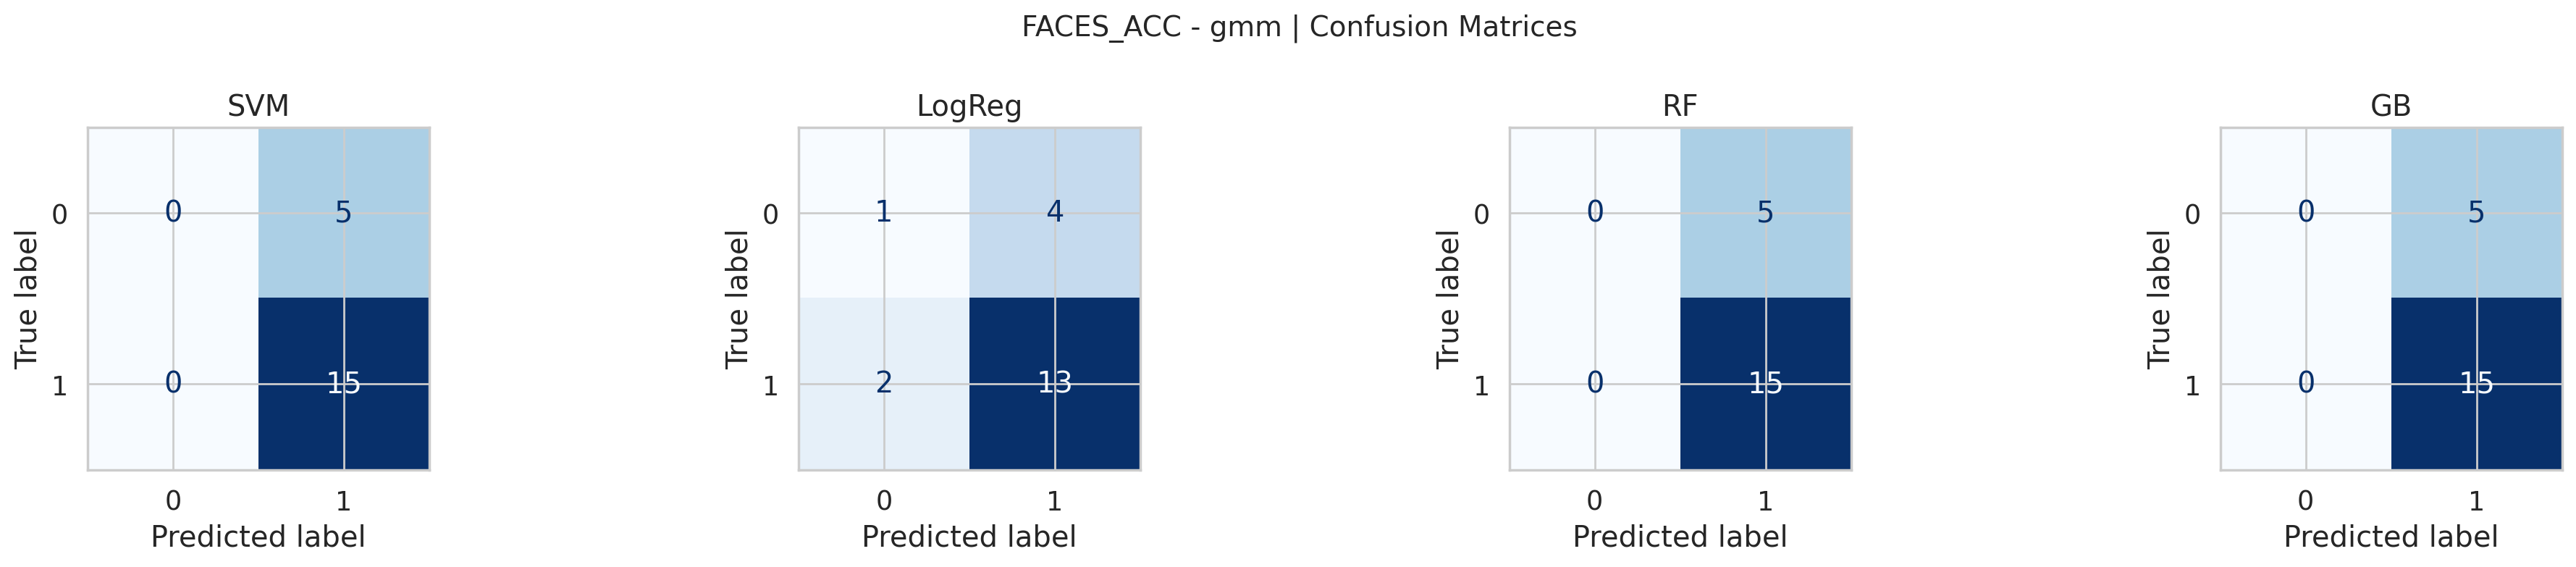

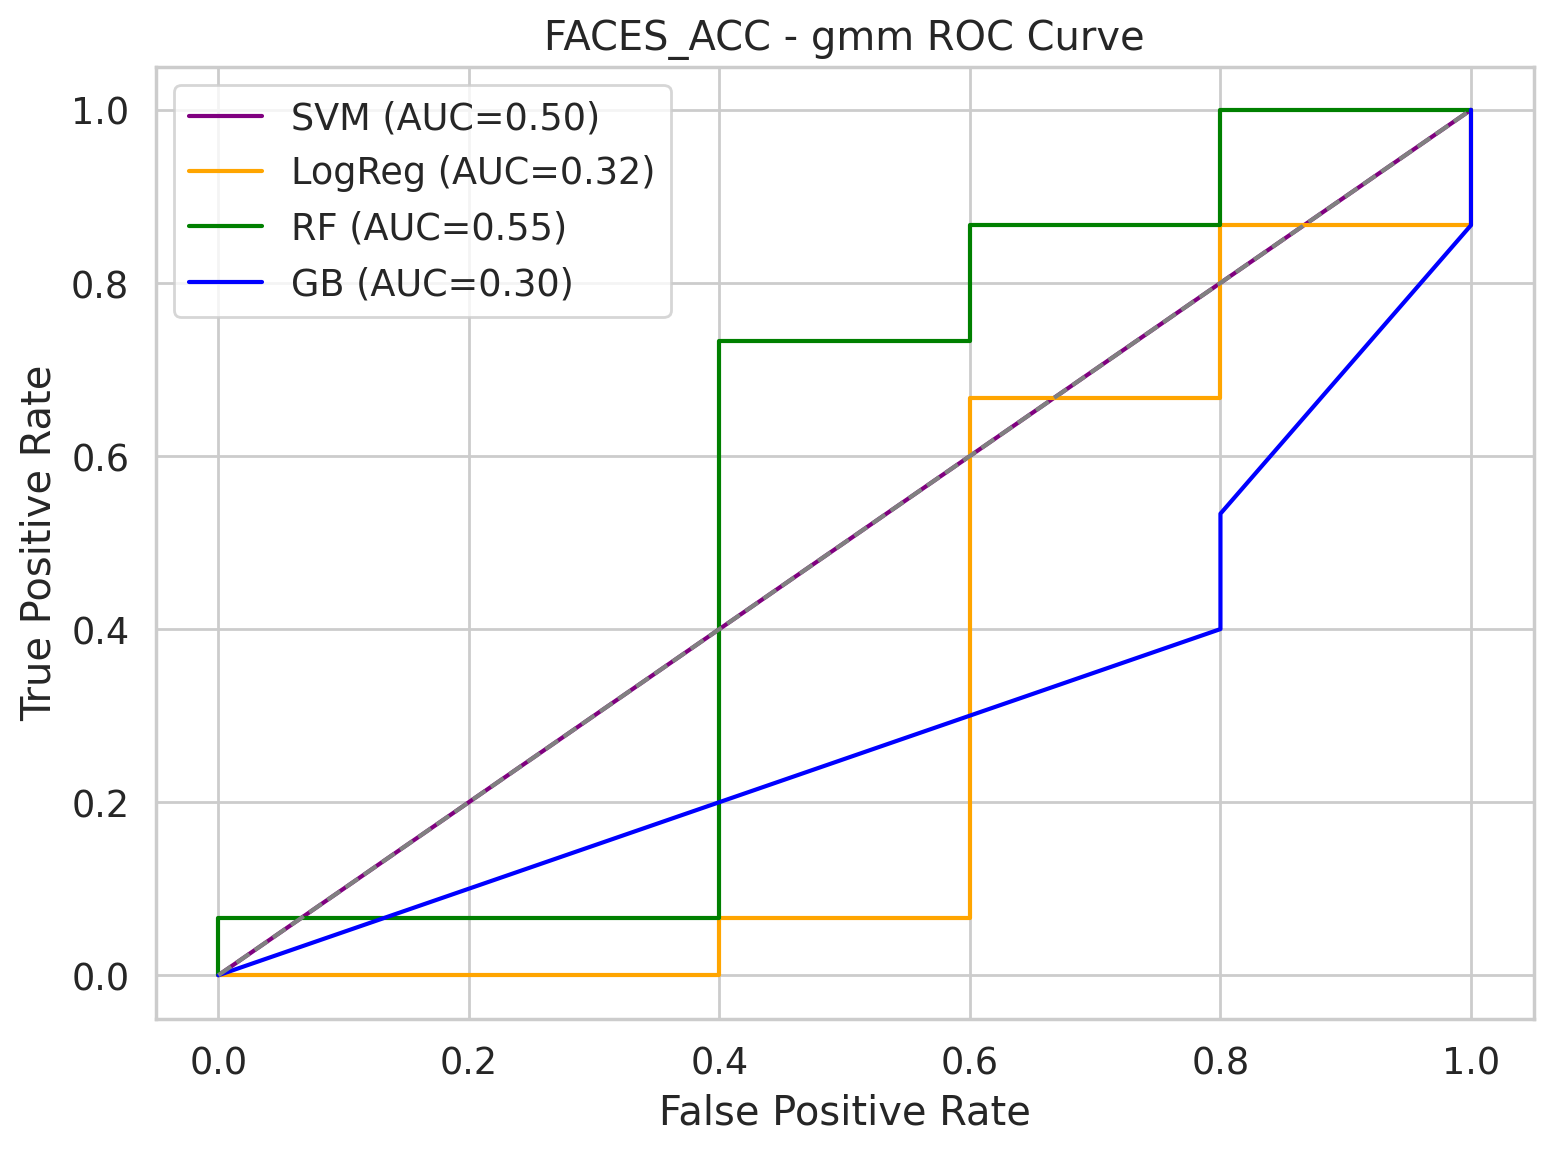


======= PLACES_ACC | Threshold method: median (thr: 0.900) =======
PCA n_components: 67 | Explained Var: 0.95
[SVM]               precision    recall  f1-score   support

           0      0.000     0.000     0.000         8
           1      0.600     1.000     0.750        12

    accuracy                          0.600        20
   macro avg      0.300     0.500     0.375        20
weighted avg      0.360     0.600     0.450        20
 Acc: 0.60, AUC: 0.50
[LR]               precision    recall  f1-score   support

           0      0.273     0.375     0.316         8
           1      0.444     0.333     0.381        12

    accuracy                          0.350        20
   macro avg      0.359     0.354     0.348        20
weighted avg      0.376     0.350     0.355        20
 Acc: 0.35, AUC: 0.34
[RF]               precision    recall  f1-score   support

           0      0.286     0.250     0.267         8
           1      0.538     0.583     0.560        12

    accuracy 

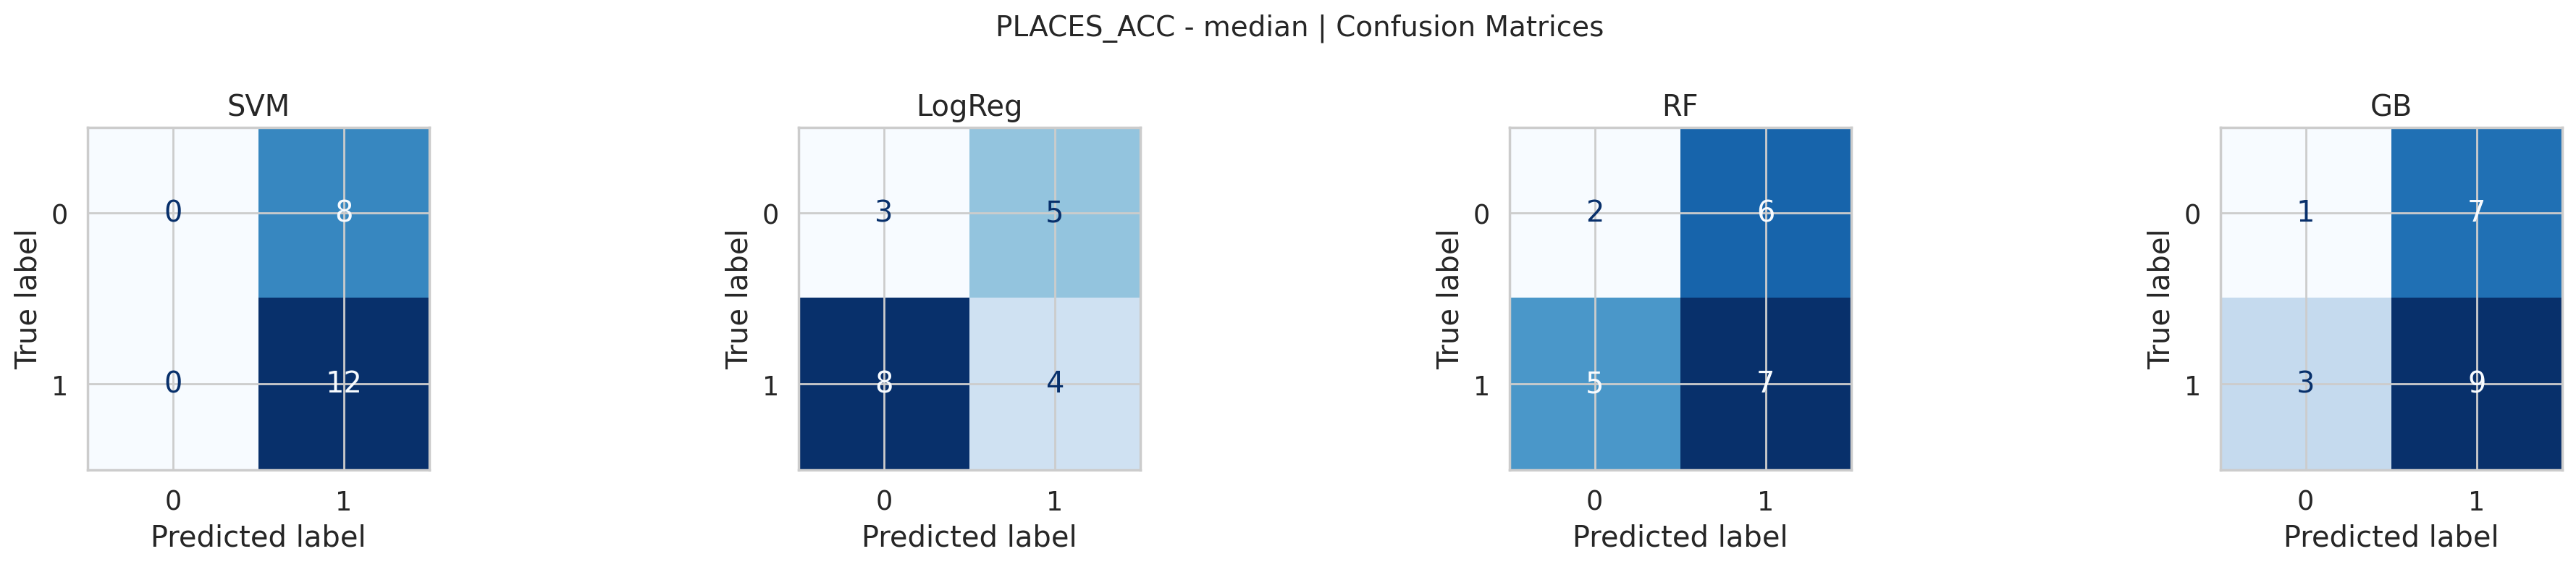

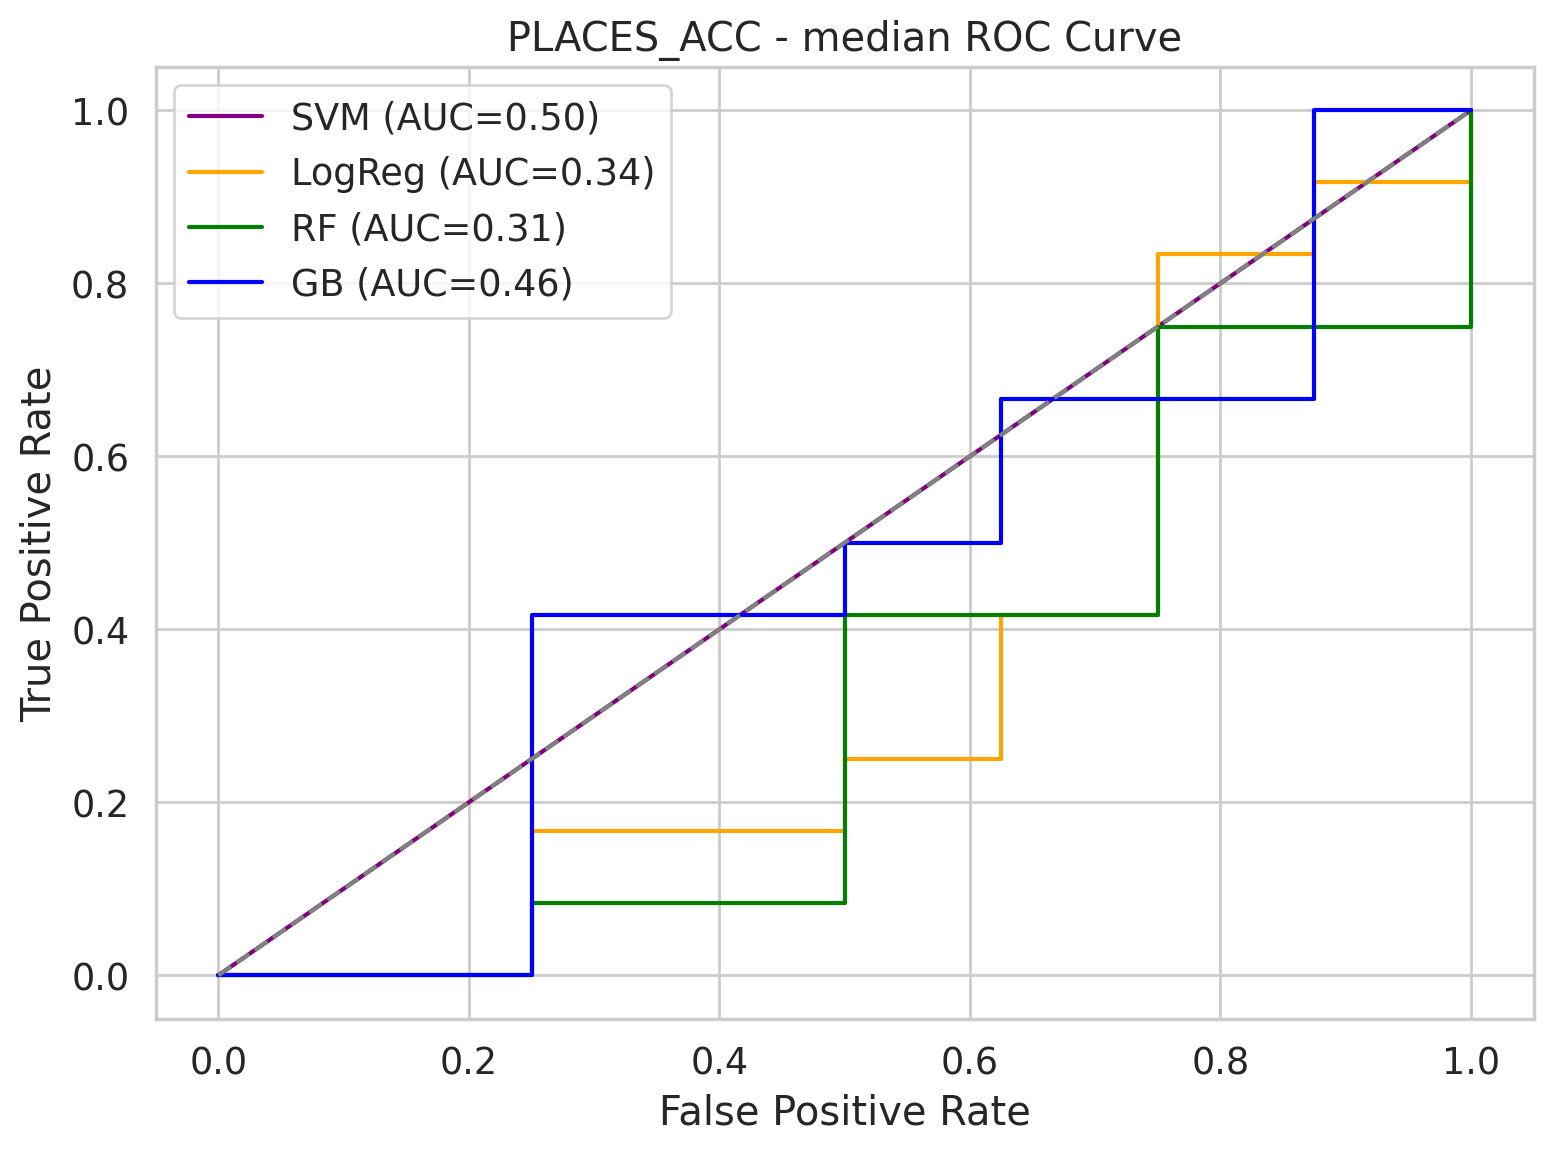


======= PLACES_ACC | Threshold method: percentile_67 (thr: 0.950) =======
PCA n_components: 68 | Explained Var: 0.95
[SVM]               precision    recall  f1-score   support

           0      0.550     1.000     0.710        11
           1      0.000     0.000     0.000         9

    accuracy                          0.550        20
   macro avg      0.275     0.500     0.355        20
weighted avg      0.303     0.550     0.390        20
 Acc: 0.55, AUC: 0.50
[LR]               precision    recall  f1-score   support

           0      0.500     0.364     0.421        11
           1      0.417     0.556     0.476         9

    accuracy                          0.450        20
   macro avg      0.458     0.460     0.449        20
weighted avg      0.463     0.450     0.446        20
 Acc: 0.45, AUC: 0.35
[RF]               precision    recall  f1-score   support

           0      0.300     0.273     0.286        11
           1      0.200     0.222     0.211         9

    ac

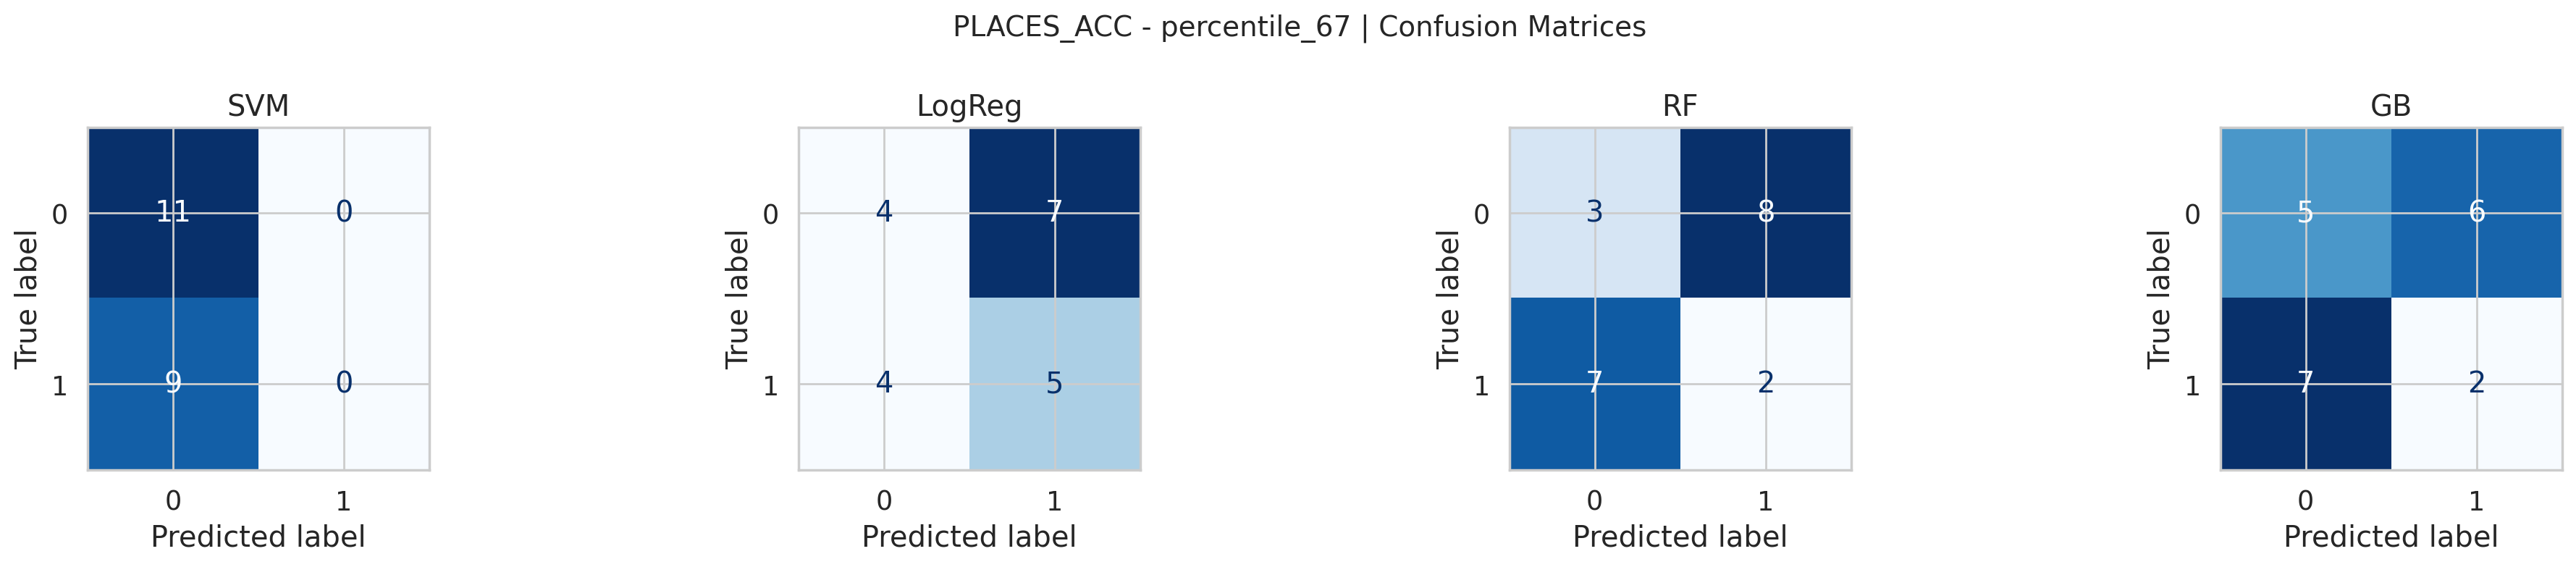

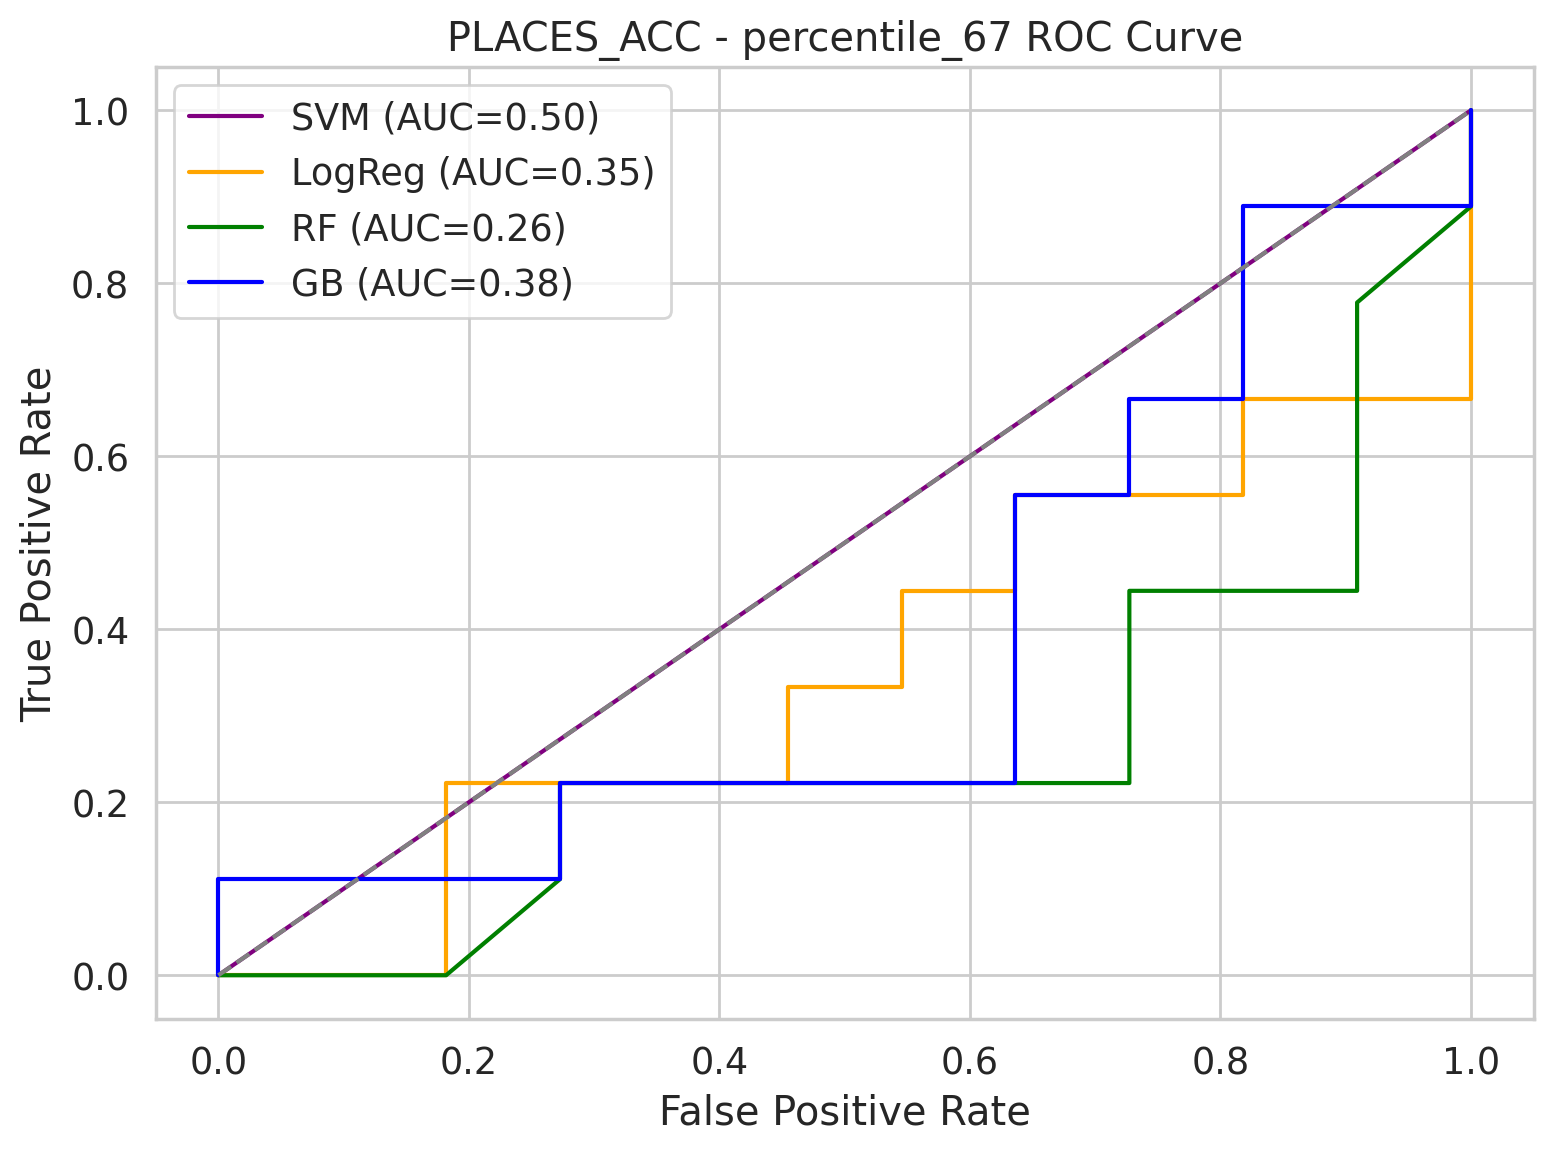


======= PLACES_ACC | Threshold method: gmm (thr: 0.856) =======
PCA n_components: 67 | Explained Var: 0.95
[SVM]               precision    recall  f1-score   support

           0      0.000     0.000     0.000         8
           1      0.600     1.000     0.750        12

    accuracy                          0.600        20
   macro avg      0.300     0.500     0.375        20
weighted avg      0.360     0.600     0.450        20
 Acc: 0.60, AUC: 0.50
[LR]               precision    recall  f1-score   support

           0      0.273     0.375     0.316         8
           1      0.444     0.333     0.381        12

    accuracy                          0.350        20
   macro avg      0.359     0.354     0.348        20
weighted avg      0.376     0.350     0.355        20
 Acc: 0.35, AUC: 0.34
[RF]               precision    recall  f1-score   support

           0      0.286     0.250     0.267         8
           1      0.538     0.583     0.560        12

    accuracy    

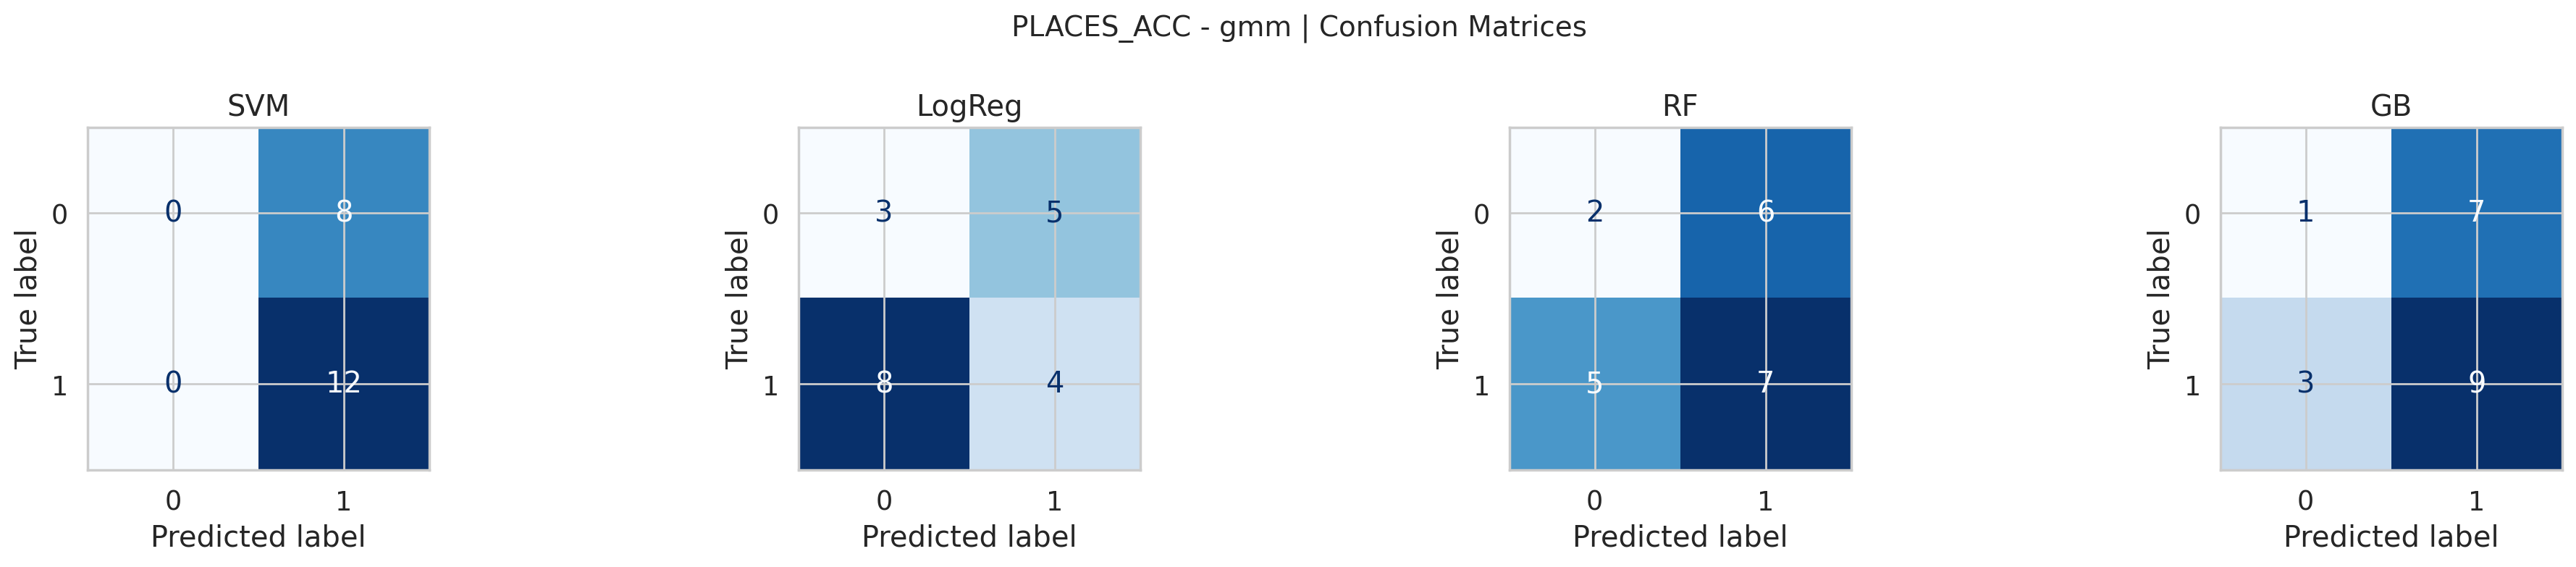

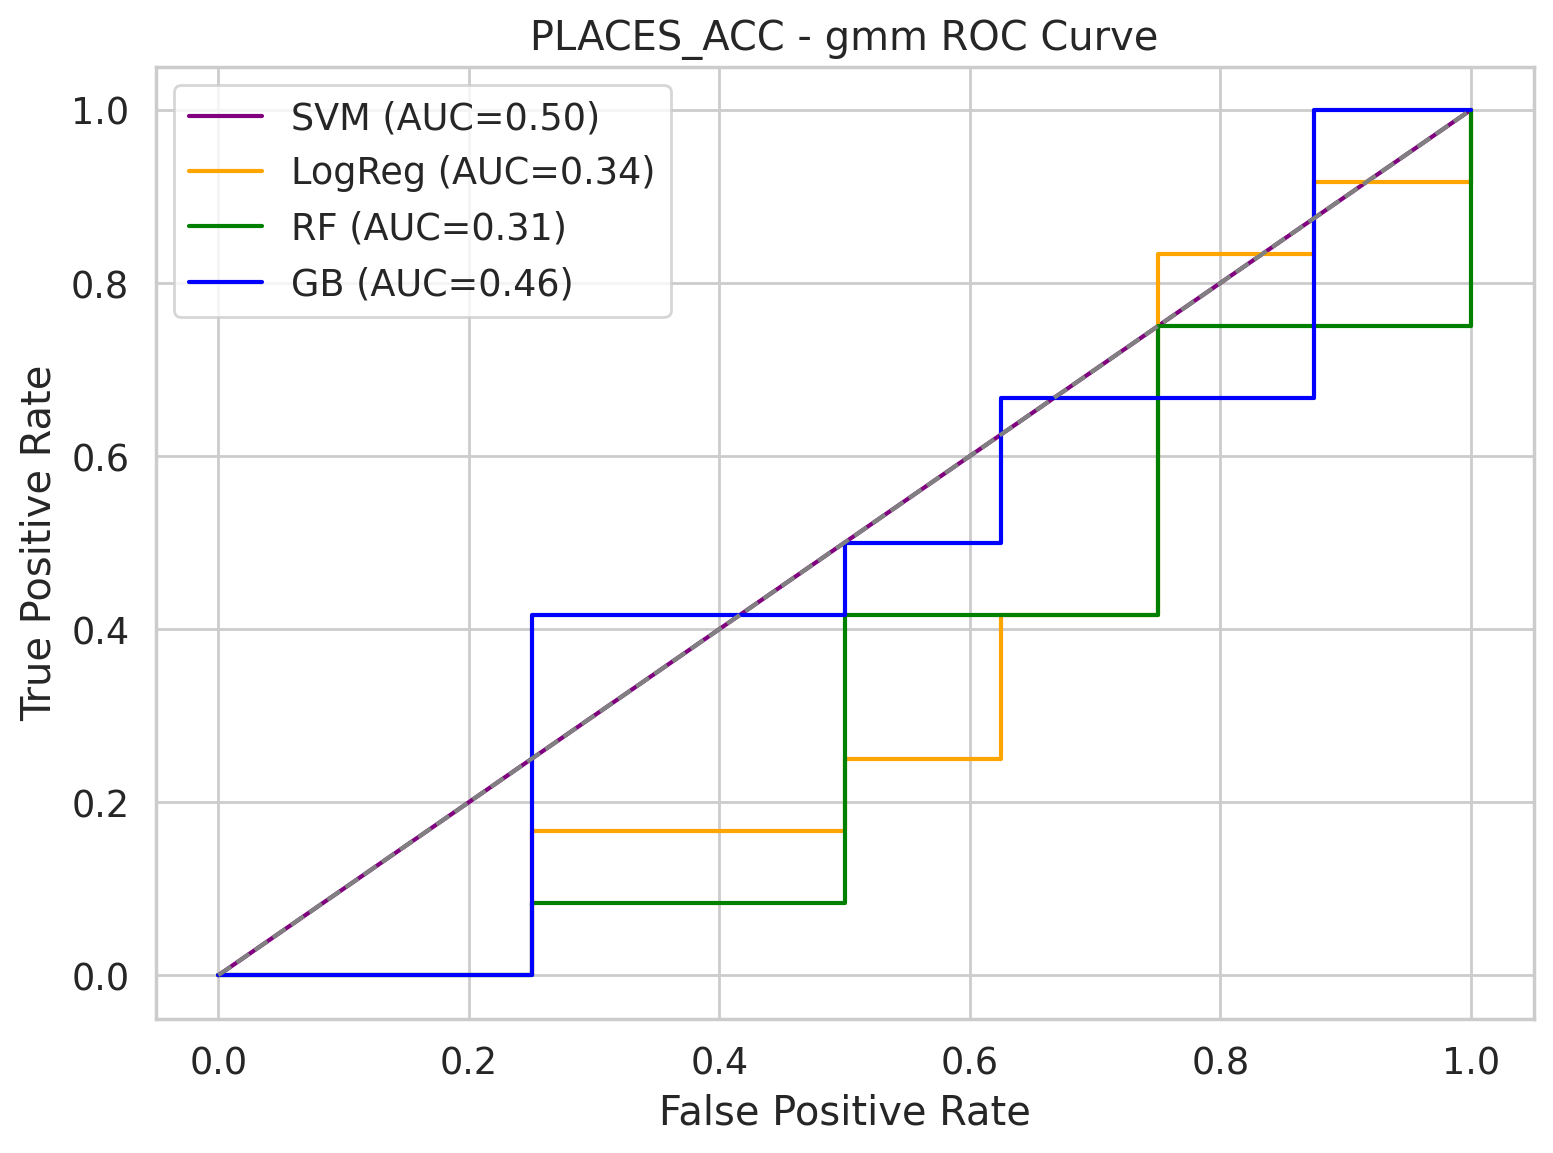


======= TOOLS_ACC | Threshold method: median (thr: 0.850) =======
PCA n_components: 68 | Explained Var: 0.95
[SVM]               precision    recall  f1-score   support

           0      0.000     0.000     0.000         8
           1      0.600     1.000     0.750        12

    accuracy                          0.600        20
   macro avg      0.300     0.500     0.375        20
weighted avg      0.360     0.600     0.450        20
 Acc: 0.60, AUC: 0.50
[LR]               precision    recall  f1-score   support

           0      0.333     0.375     0.353         8
           1      0.545     0.500     0.522        12

    accuracy                          0.450        20
   macro avg      0.439     0.438     0.437        20
weighted avg      0.461     0.450     0.454        20
 Acc: 0.45, AUC: 0.48
[RF]               precision    recall  f1-score   support

           0      0.000     0.000     0.000         8
           1      0.600     1.000     0.750        12

    accuracy  

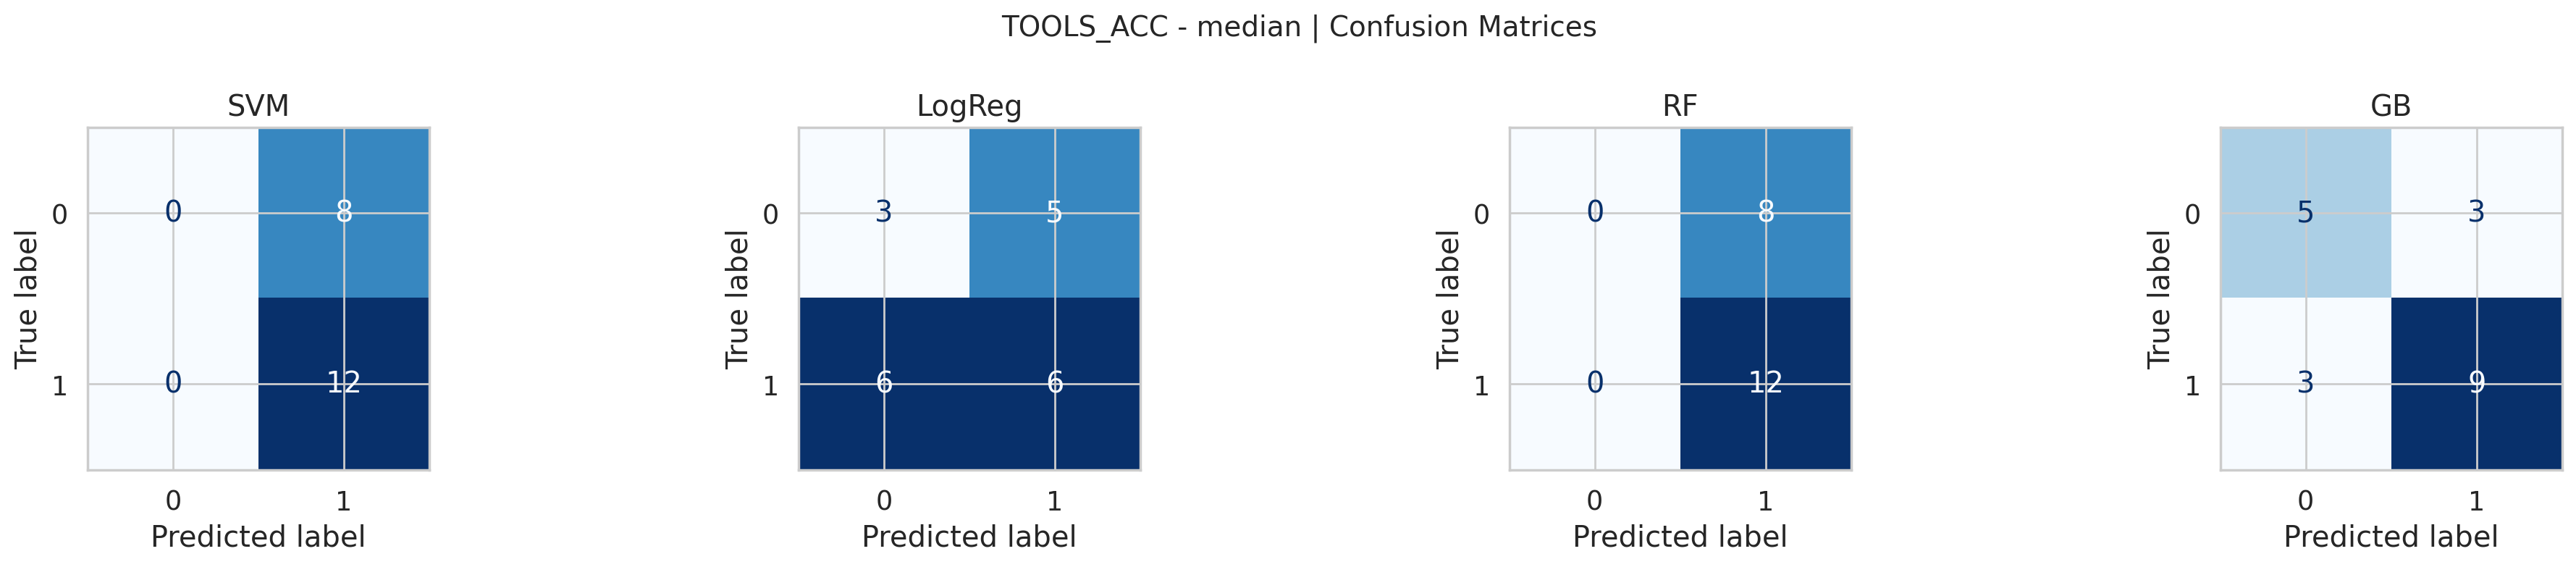

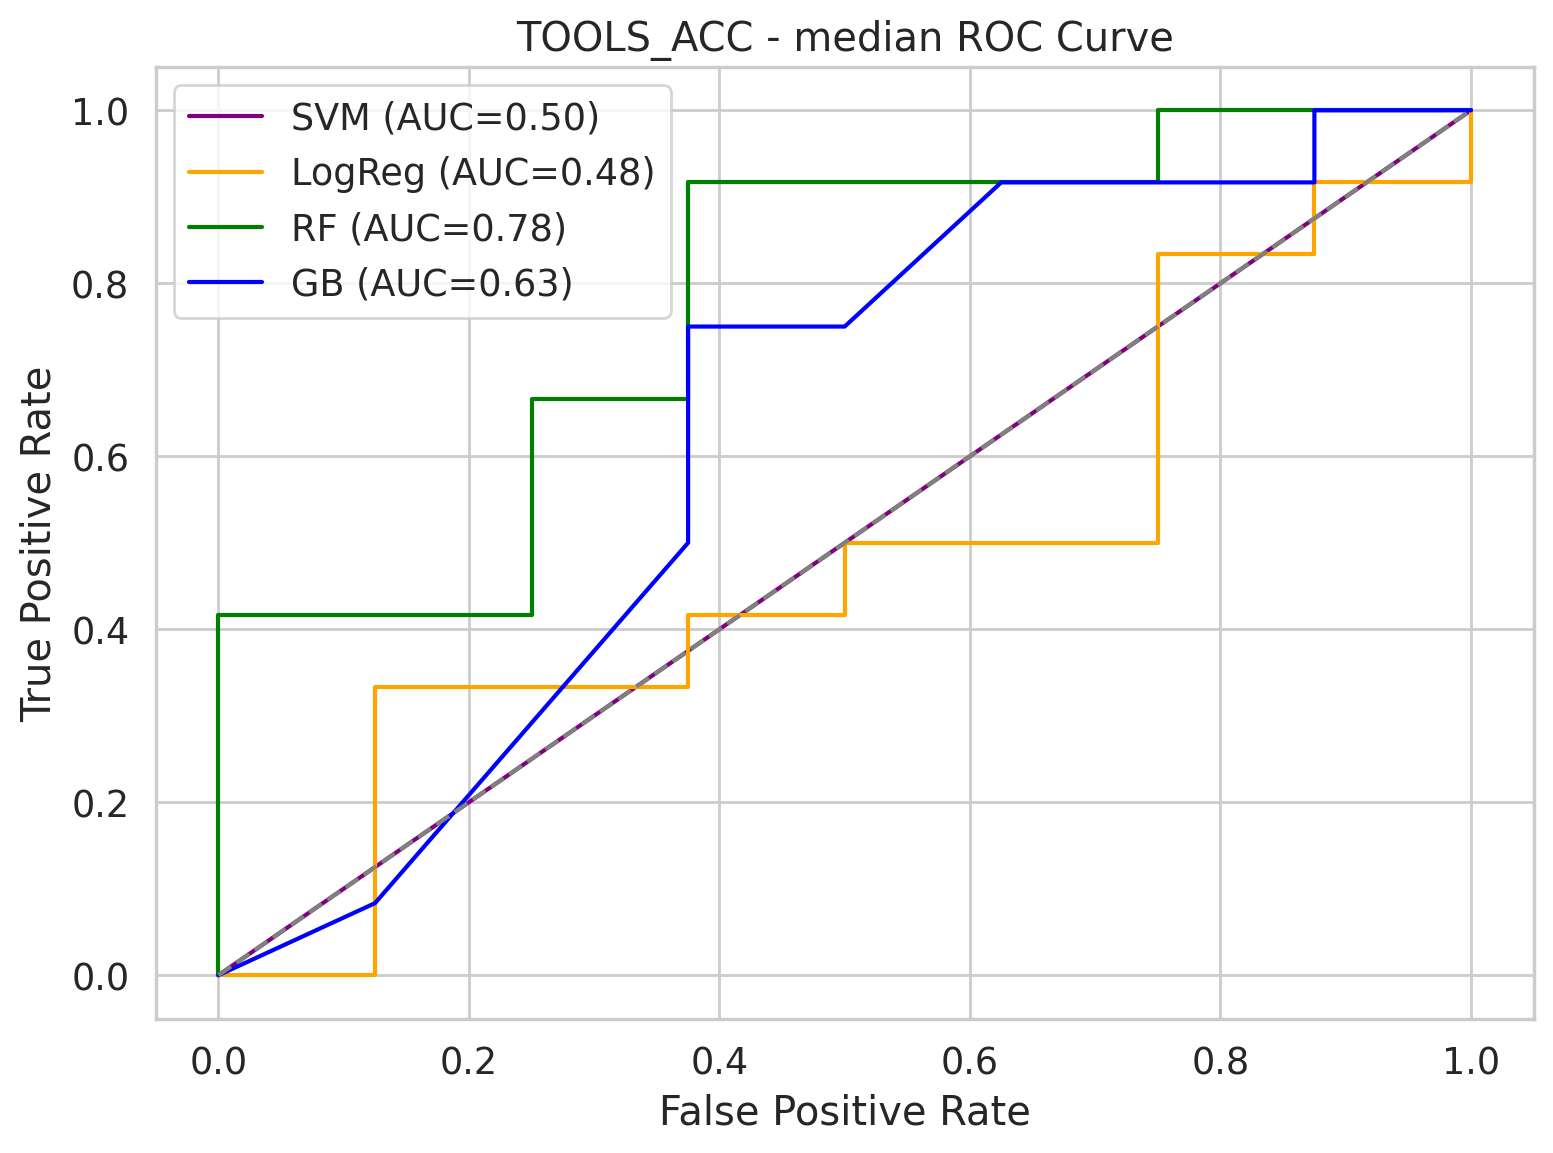


======= TOOLS_ACC | Threshold method: percentile_67 (thr: 0.900) =======
PCA n_components: 68 | Explained Var: 0.95
[SVM]               precision    recall  f1-score   support

           0      0.600     1.000     0.750        12
           1      0.000     0.000     0.000         8

    accuracy                          0.600        20
   macro avg      0.300     0.500     0.375        20
weighted avg      0.360     0.600     0.450        20
 Acc: 0.60, AUC: 0.50
[LR]               precision    recall  f1-score   support

           0      0.556     0.417     0.476        12
           1      0.364     0.500     0.421         8

    accuracy                          0.450        20
   macro avg      0.460     0.458     0.449        20
weighted avg      0.479     0.450     0.454        20
 Acc: 0.45, AUC: 0.50
[RF]               precision    recall  f1-score   support

           0      0.667     0.667     0.667        12
           1      0.500     0.500     0.500         8

    acc

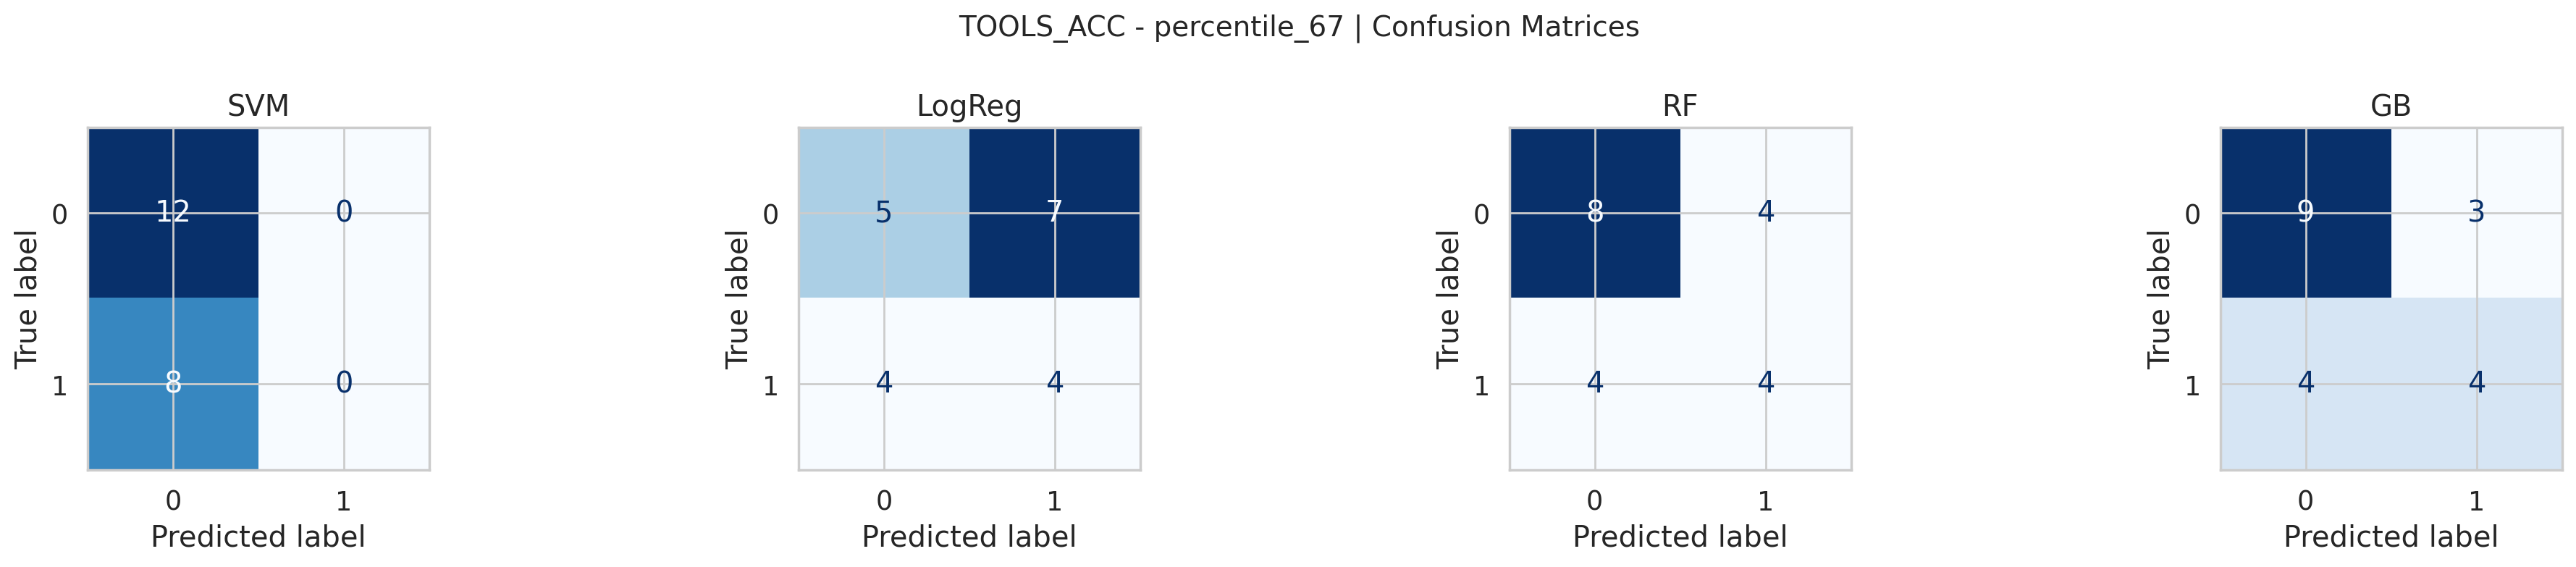

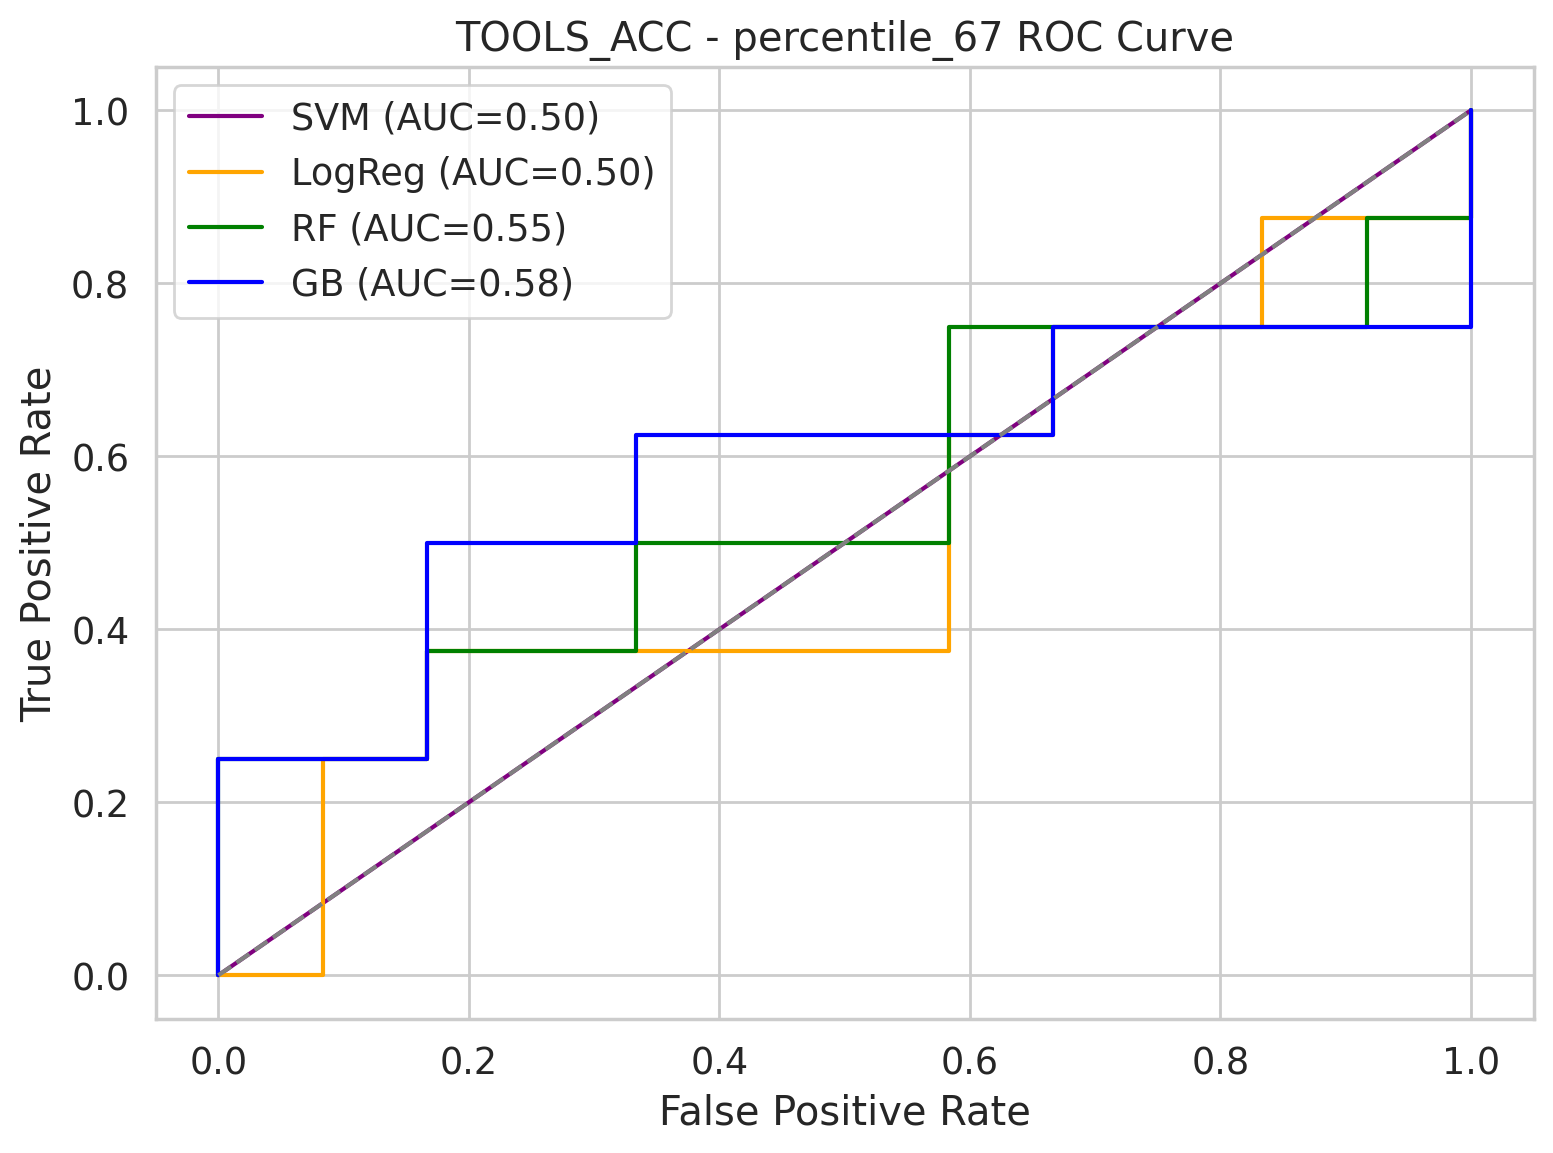


======= TOOLS_ACC | Threshold method: gmm (thr: 0.792) =======
PCA n_components: 68 | Explained Var: 0.95
[SVM]               precision    recall  f1-score   support

           0      0.000     0.000     0.000         5
           1      0.750     1.000     0.857        15

    accuracy                          0.750        20
   macro avg      0.375     0.500     0.429        20
weighted avg      0.562     0.750     0.643        20
 Acc: 0.75, AUC: 0.50
[LR]               precision    recall  f1-score   support

           0      0.375     0.600     0.462         5
           1      0.833     0.667     0.741        15

    accuracy                          0.650        20
   macro avg      0.604     0.633     0.601        20
weighted avg      0.719     0.650     0.671        20
 Acc: 0.65, AUC: 0.69
[RF]               precision    recall  f1-score   support

           0      0.000     0.000     0.000         5
           1      0.722     0.867     0.788        15

    accuracy     

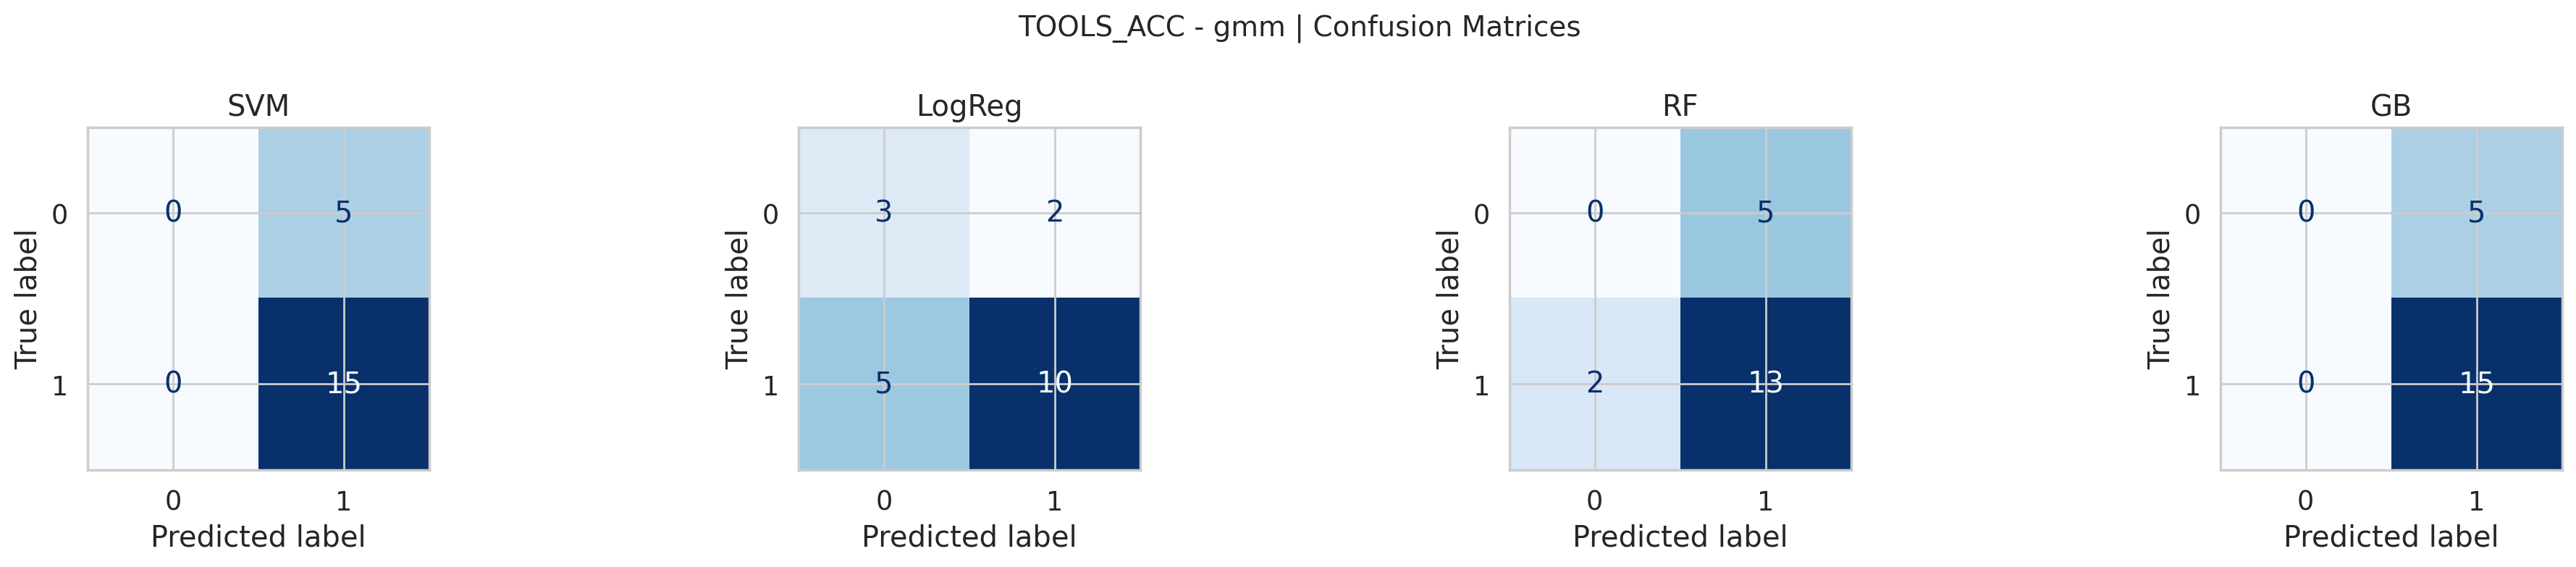

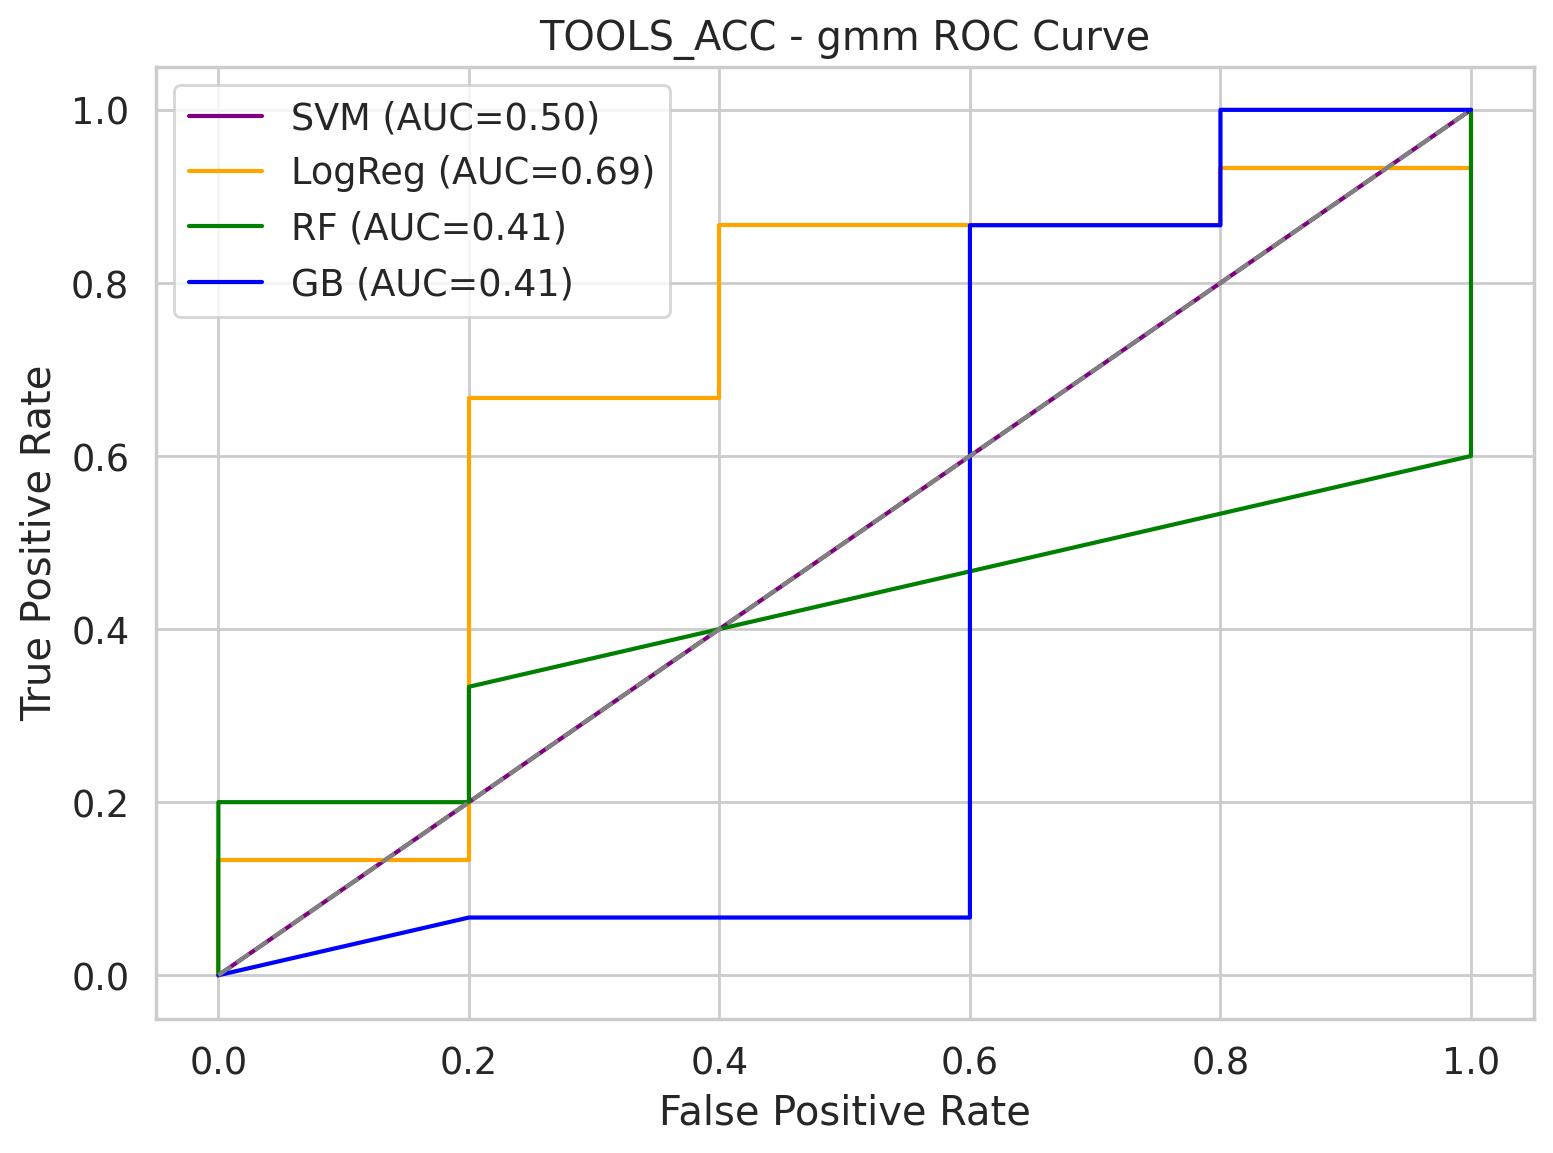


========== Model Comparison Across All Tasks & Thresholds ==========
          Task   ThreshMethod  SVM_Acc  LR_Acc  RF_Acc  GB_Acc  SVM_AUC  \
0       BP_ACC         median     0.55    0.60    0.40    0.60     0.52   
1       BP_ACC  percentile_67     0.65    0.35    0.55    0.70     0.50   
2       BP_ACC            gmm     0.55    0.60    0.40    0.60     0.52   
3    FACES_ACC         median     0.60    0.40    0.60    0.40     0.50   
4    FACES_ACC  percentile_67     0.60    0.55    0.55    0.45     0.50   
5    FACES_ACC            gmm     0.75    0.70    0.75    0.75     0.50   
6   PLACES_ACC         median     0.60    0.35    0.45    0.50     0.50   
7   PLACES_ACC  percentile_67     0.55    0.45    0.25    0.35     0.50   
8   PLACES_ACC            gmm     0.60    0.35    0.45    0.50     0.50   
9    TOOLS_ACC         median     0.60    0.45    0.60    0.70     0.50   
10   TOOLS_ACC  percentile_67     0.60    0.45    0.60    0.65     0.50   
11   TOOLS_ACC            gmm 

In [ ]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import classification_report, roc_auc_score, roc_curve, ConfusionMatrixDisplay
from sklearn.mixture import GaussianMixture
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

### USER-EDITABLE PARAMETERS
THRESHOLD_METHODS = ['median', 'percentile_67', 'gmm']
PERCENTILE = 67
PCA_VAR = 0.95

# -- Load labels/accuracies and features
df_acc = pd.read_csv('wm_2back_accuracies.csv')
grouped = df_acc.groupby('subject')[['BP_ACC', 'FACES_ACC', 'PLACES_ACC', 'TOOLS_ACC']].mean().reset_index()
tasks = ['BP_ACC', 'FACES_ACC', 'PLACES_ACC', 'TOOLS_ACC']

z_FC_upper = {
    'FACES_ACC': np.load('faces_fc_upper.npy'),
    'PLACES_ACC': np.load('places_fc_upper.npy'),
    'BP_ACC':    np.load('body_fc_upper.npy'),
    'TOOLS_ACC': np.load('tools_fc_upper.npy'),
}
print('Data loaded:', {k: v.shape for k, v in z_FC_upper.items()})

# -- Hyperparameter grids
svm_param_grid = {
    'C': [0.01, 0.1, 1, 10],
    'kernel': ['linear', 'rbf'],
    'gamma': ['scale', 'auto'],
}
lr_param_grid = {
    'C': [0.01, 0.1, 1, 10],
    'penalty': ['l2'],
    'solver': ['liblinear'],
    'class_weight': ['balanced'],
    'max_iter': [500]
}
rf_param_grid = {
    'n_estimators': [50, 100],
    'max_depth': [None, 5, 8],
    'min_samples_split': [2, 5],
    'class_weight': ['balanced', None],
    'random_state': [42]
}
gb_param_grid = {
    'n_estimators': [50, 100],
    'max_depth': [3, 5],
    'learning_rate': [0.01, 0.1]
}

def get_labels(acc, method, percentile=67):
    acc = np.asarray(acc)
    if method == 'median':
        threshold = np.median(acc)
        return (acc >= threshold).astype(int), threshold
    elif method.startswith('percentile'):
        threshold = np.percentile(acc, percentile)
        return (acc >= threshold).astype(int), threshold
    elif method == 'gmm':
        acc2d = acc.reshape(-1,1)
        gmm = GaussianMixture(n_components=2, random_state=42).fit(acc2d)
        means = gmm.means_.flatten()
        threshold = np.mean(means)
        comps = gmm.predict(acc2d)
        order = np.argsort(means)
        high_class = order[1]
        return (comps == high_class).astype(int), threshold
    else:
        raise ValueError(f"Unsupported thresholding method: {method}")

results = []

for task in tasks:
    X = z_FC_upper[task]
    acc = grouped[task].values
    for method in THRESHOLD_METHODS:
        y, threshold = get_labels(acc, method=method, percentile=PERCENTILE)
        if len(np.unique(y)) != 2:
            print(f"Skipping {task}-{method}: Only one class found.")
            continue

        print(f"\n======= {task} | Threshold method: {method} (thr: {threshold:.3f}) =======")
        X_train, X_test, y_train, y_test = train_test_split(
            X, y, test_size=0.2, random_state=42, stratify=y)

        # Standardize & PCA
        scaler = StandardScaler()
        X_train_std = scaler.fit_transform(X_train)
        X_test_std  = scaler.transform(X_test)
        pca = PCA(n_components=PCA_VAR, svd_solver='full', random_state=42)
        X_train_pca = pca.fit_transform(X_train_std)
        X_test_pca = pca.transform(X_test_std)
        print(f"PCA n_components: {X_train_pca.shape[1]} | Explained Var: {np.sum(pca.explained_variance_ratio_):.2f}")

        cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=1)

        # --- SVM ---
        svm = SVC(class_weight='balanced', probability=True, random_state=42)
        svm_grid = GridSearchCV(svm, svm_param_grid, cv=cv, scoring='accuracy', n_jobs=-1)
        svm_grid.fit(X_train_pca, y_train)
        y_pred_svm = svm_grid.predict(X_test_pca)
        y_prob_svm = svm_grid.predict_proba(X_test_pca)[:,1]
        acc_svm = np.mean(y_pred_svm == y_test)
        auc_svm = roc_auc_score(y_test, y_prob_svm)
        print('[SVM]', classification_report(y_test, y_pred_svm, digits=3), f"Acc: {acc_svm:.2f}, AUC: {auc_svm:.2f}")

        # --- LR ---
        lr = LogisticRegression(random_state=42)
        lr_grid = GridSearchCV(lr, lr_param_grid, cv=cv, scoring='accuracy', n_jobs=-1)
        lr_grid.fit(X_train_pca, y_train)
        y_pred_lr = lr_grid.predict(X_test_pca)
        y_prob_lr = lr_grid.predict_proba(X_test_pca)[:,1]
        acc_lr = np.mean(y_pred_lr == y_test)
        auc_lr = roc_auc_score(y_test, y_prob_lr)
        print('[LR]', classification_report(y_test, y_pred_lr, digits=3), f"Acc: {acc_lr:.2f}, AUC: {auc_lr:.2f}")

        # --- RF ---
        rf = RandomForestClassifier()
        rf_grid = GridSearchCV(rf, rf_param_grid, cv=cv, scoring='accuracy', n_jobs=-1)
        rf_grid.fit(X_train_pca, y_train)
        y_pred_rf = rf_grid.predict(X_test_pca)
        y_prob_rf = rf_grid.predict_proba(X_test_pca)[:,1]
        acc_rf = np.mean(y_pred_rf == y_test)
        auc_rf = roc_auc_score(y_test, y_prob_rf)
        print('[RF]', classification_report(y_test, y_pred_rf, digits=3), f"Acc: {acc_rf:.2f}, AUC: {auc_rf:.2f}")

        # --- GB ---
        gb = GradientBoostingClassifier(random_state=42)
        gb_grid = GridSearchCV(gb, gb_param_grid, cv=cv, scoring='accuracy', n_jobs=-1)
        gb_grid.fit(X_train_pca, y_train)
        y_pred_gb = gb_grid.predict(X_test_pca)
        y_prob_gb = gb_grid.predict_proba(X_test_pca)[:,1]
        acc_gb = np.mean(y_pred_gb == y_test)
        auc_gb = roc_auc_score(y_test, y_prob_gb)
        print('[GB]', classification_report(y_test, y_pred_gb, digits=3), f"Acc: {acc_gb:.2f}, AUC: {auc_gb:.2f}")

        results.append({
            'Task': task, 'ThreshMethod': method,
            'ThreshValue': threshold,
            'SVM_Acc': acc_svm,   'SVM_AUC': auc_svm,
            'LR_Acc': acc_lr,     'LR_AUC': auc_lr,
            'RF_Acc': acc_rf,     'RF_AUC': auc_rf,
            'GB_Acc': acc_gb,     'GB_AUC': auc_gb
        })

        # --- Confusion Matrices ---
        fig, axs = plt.subplots(1, 4, figsize=(20, 4))
        for ax, y_pred, title in zip(
            axs, [y_pred_svm, y_pred_lr, y_pred_rf, y_pred_gb], ['SVM', 'LogReg', 'RF', "GB"]
        ):
            ConfusionMatrixDisplay.from_predictions(y_test, y_pred, ax=ax, cmap="Blues", colorbar=False)
            ax.set_title(title)
        fig.suptitle(f"{task} - {method} | Confusion Matrices", fontsize=14)
        plt.tight_layout()
        plt.show()

        # --- ROC Curves (ALL FOUR MODELS)---
        fpr_svm, tpr_svm, _ = roc_curve(y_test, y_prob_svm)
        fpr_lr, tpr_lr, _ = roc_curve(y_test, y_prob_lr)
        fpr_rf, tpr_rf, _ = roc_curve(y_test, y_prob_rf)
        fpr_gb, tpr_gb, _ = roc_curve(y_test, y_prob_gb)
        plt.figure(figsize=(8,6))
        plt.plot(fpr_svm, tpr_svm, label=f'SVM (AUC={auc_svm:.2f})', color='purple')
        plt.plot(fpr_lr, tpr_lr, label=f'LogReg (AUC={auc_lr:.2f})', color='orange')
        plt.plot(fpr_rf, tpr_rf, label=f'RF (AUC={auc_rf:.2f})', color='green')
        plt.plot(fpr_gb, tpr_gb, label=f'GB (AUC={auc_gb:.2f})', color='blue')
        plt.plot([0,1], [0,1], '--', color='gray')
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title(f'{task} - {method} ROC Curve')
        plt.legend()
        plt.grid(True)
        plt.show()

# ---- Summary Table ----
results_whole_df = pd.DataFrame(results)
print("\n========== Model Comparison Across All Tasks & Thresholds ==========")
print(results_whole_df[['Task','ThreshMethod','SVM_Acc','LR_Acc','RF_Acc','GB_Acc','SVM_AUC','LR_AUC','RF_AUC','GB_AUC']])


Task BestModel ThresholdMethod  Value
0      BP_ACC        GB   percentile_67   0.70
1   FACES_ACC       SVM             gmm   0.75
2  PLACES_ACC       SVM          median   0.60
3   TOOLS_ACC       SVM             gmm   0.75


--- Best model/threshold combo for each WM task (whole-brain features) ---

Task: BP_ACC | Best Model: GB | Threshold: percentile_67 | Accuracy: 0.70
Task: FACES_ACC | Best Model: SVM | Threshold: gmm | Accuracy: 0.75
Task: PLACES_ACC | Best Model: SVM | Threshold: median | Accuracy: 0.60
Task: TOOLS_ACC | Best Model: SVM | Threshold: gmm | Accuracy: 0.75


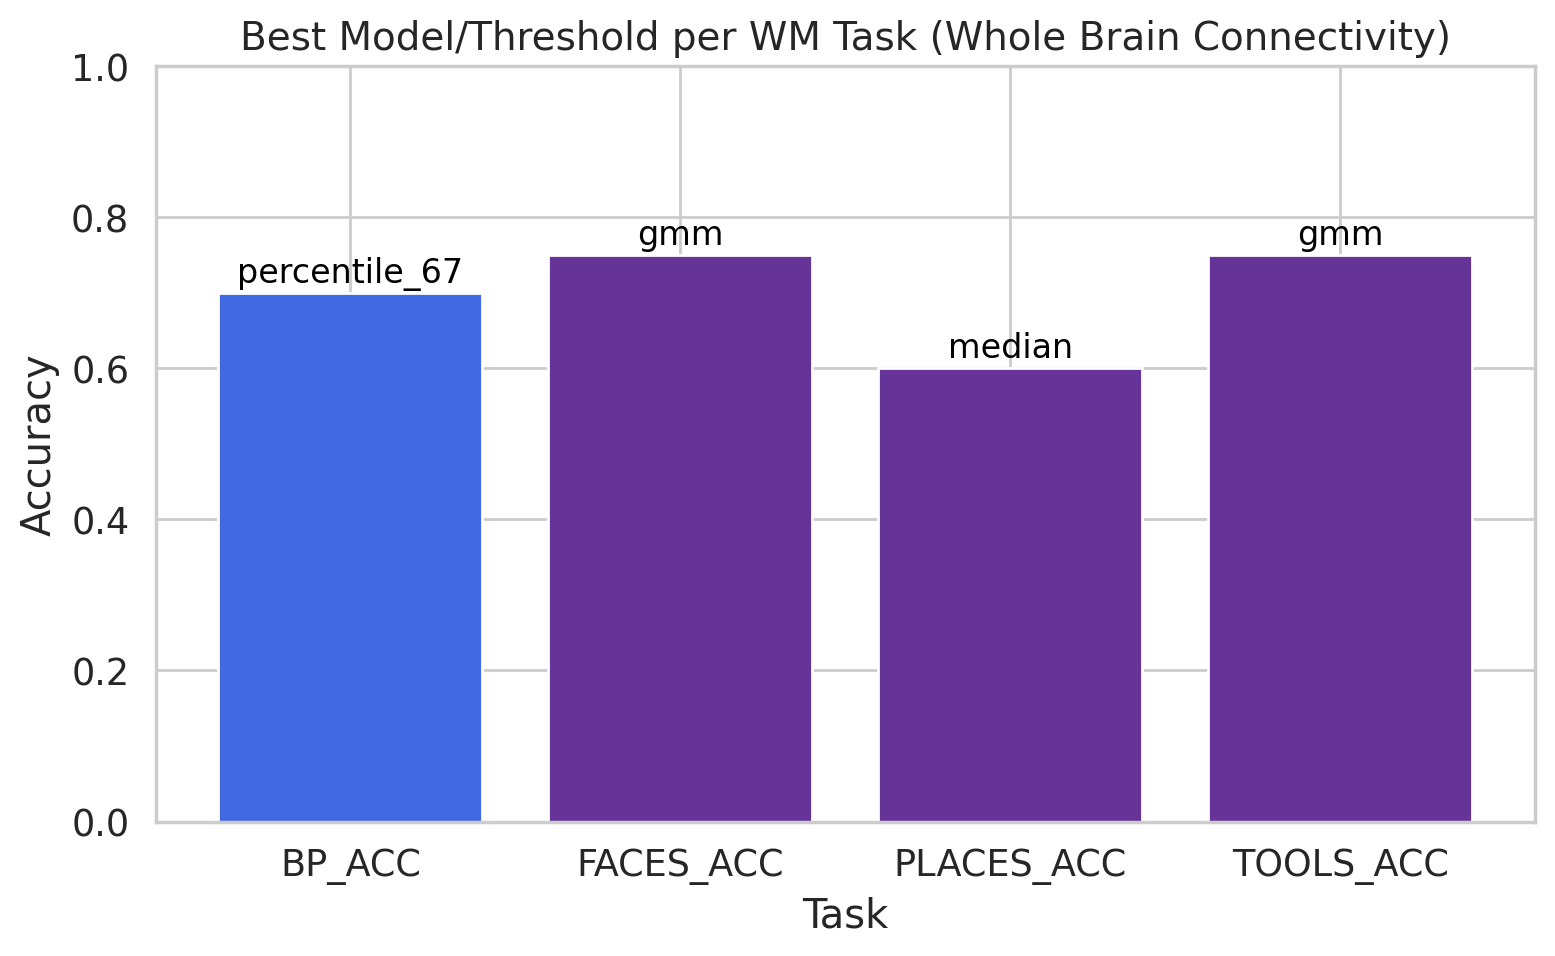

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

def get_best_for_each_task(df, metric='Acc'):
    """
    برای هر تسک، بهترین مدل و آستانه (بر اساس دقت یا AUC یا هر متریک دیگر) را انتخاب می‌کند.
    خروجی: دیتافریم با ستون‌های Task، BestModel، ThresholdMethod، Value.
    """
    model_list = ['SVM', 'LR', 'RF', 'GB']
    records = []
    for task in df['Task'].unique():
        sub_df = df[df['Task']==task]
        best_val = -999
        best_model = None
        best_method = None
        for mi in model_list:
            idx = sub_df[f'{mi}_{metric}'].idxmax()
            val = sub_df.loc[idx, f'{mi}_{metric}']
            if val > best_val:
                best_val = val
                best_model = mi
                best_method = sub_df.loc[idx, 'ThreshMethod']
        records.append({'Task': task, 'BestModel': best_model, 'ThresholdMethod': best_method, 'Value': best_val})
    return pd.DataFrame.from_records(records)

# خروجی جدول برای داده‌های whole brain
best_df = get_best_for_each_task(results_whole_df, metric='Acc')

display(best_df)
print("\n--- Best model/threshold combo for each WM task (whole-brain features) ---\n")
for i, row in best_df.iterrows():
    print(f"Task: {row.Task} | Best Model: {row.BestModel} | Threshold: {row.ThresholdMethod} | Accuracy: {row.Value:.2f}")

# --- Visualization ---
plt.figure(figsize=(8,5))
colors = {
    'SVM':'rebeccapurple',
    'LR':'darkorange',
    'RF':'mediumseagreen',
    'GB':'royalblue'
}
bars = plt.bar(best_df.Task, best_df.Value, color=[colors[m] for m in best_df.BestModel])
for bar, thresh in zip(bars, best_df.ThresholdMethod):
    y = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, y+0.014, f'{thresh}', ha='center', fontsize=12, color='black')
plt.ylabel('Accuracy')
plt.ylim(0, 1)
plt.xlabel('Task')
plt.title('Best Model/Threshold per WM Task (Whole Brain Connectivity)', fontsize=14)
plt.tight_layout()
plt.show()


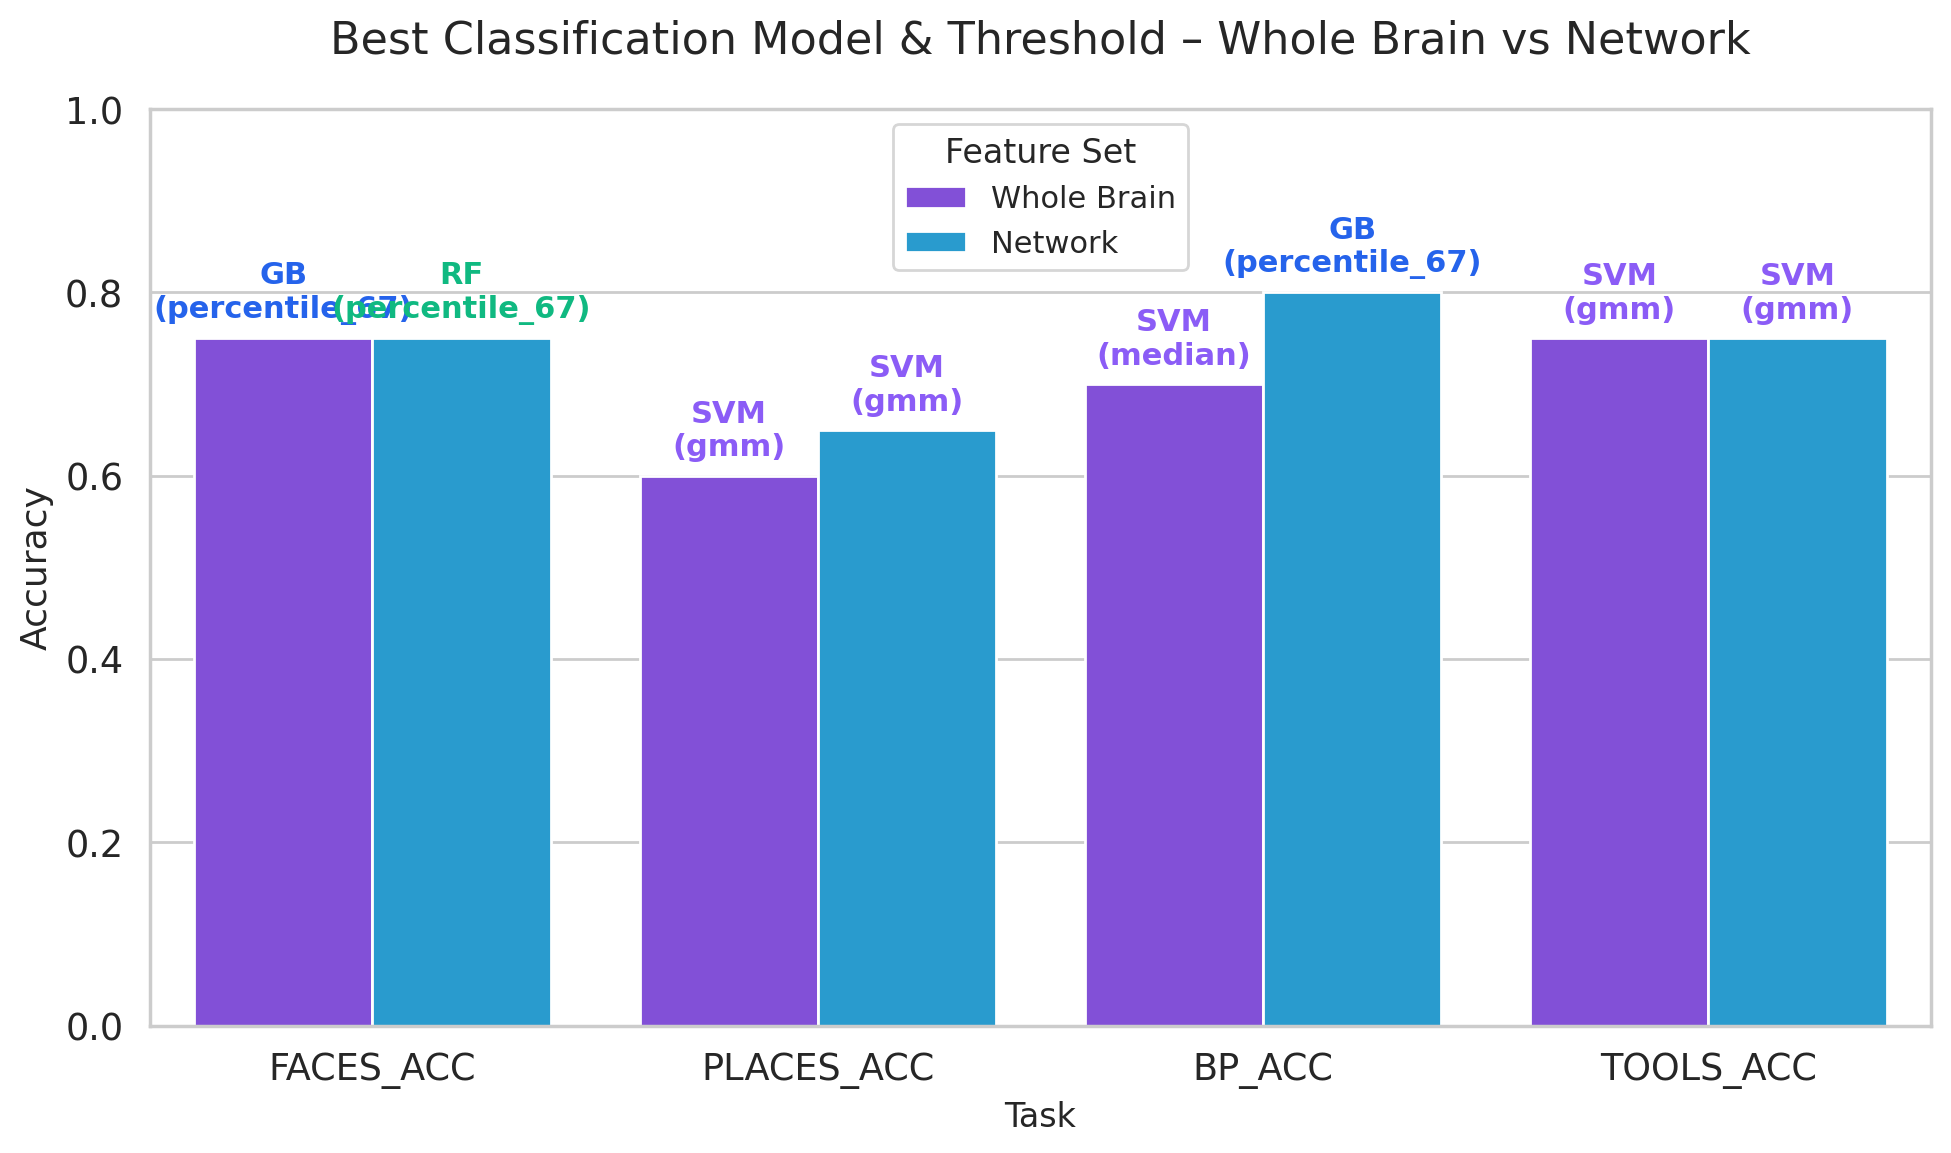

             Value             BestModel             ThresholdMethod  \
FeatureSet Network Whole Brain   Network Whole Brain         Network   
Task                                                                   
FACES_ACC     0.75        0.75       SVM         SVM             gmm   
PLACES_ACC    0.65         0.6        GB         SVM   percentile_67   
BP_ACC         0.8         0.7        RF          GB   percentile_67   
TOOLS_ACC     0.75        0.75       SVM         SVM             gmm   

                           
FeatureSet    Whole Brain  
Task                       
FACES_ACC             gmm  
PLACES_ACC         median  
BP_ACC      percentile_67  
TOOLS_ACC             gmm  


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

def get_best_for_each_task(results_df, metric='Acc'):
    """
    برای هر تسک، بهترین مدل و آستانه (براساس دقت یا AUC) را پیدا می‌کند.
    """
    best_rows = []
    tasks = sorted(results_df['Task'].unique())
    model_list = ['SVM', 'LR', 'RF', 'GB']
    for task in tasks:
        sub = results_df[results_df['Task'] == task]
        best = None
        best_model = None
        best_thresh = None
        for model in model_list:
            col = f"{model}_{metric}"
            if col in sub.columns:
                idx = sub[col].idxmax()
                val = sub[col].max()
                if best is None or val > best:
                    best = val
                    best_model = model
                    best_thresh = sub.loc[idx, 'ThreshMethod']
        best_rows.append({
            "Task": task, "Value": best,
            "BestModel": best_model,
            "ThresholdMethod": best_thresh
        })
    return pd.DataFrame(best_rows)

# تهیه دیتا برای visualization
best_df_network = get_best_for_each_task(results_network_df, metric='Acc')
best_df_network['FeatureSet'] = 'Network'

best_df_whole = get_best_for_each_task(results_whole_df, metric='Acc')
best_df_whole['FeatureSet'] = 'Whole Brain'

df_all = pd.concat([best_df_whole, best_df_network], ignore_index=True)
ordered_tasks = ['FACES_ACC', 'PLACES_ACC', 'BP_ACC', 'TOOLS_ACC']
df_all['Task'] = pd.Categorical(df_all['Task'], categories=ordered_tasks, ordered=True)

# رنگ مدل‌ها + فیچرست
model_colors = {
    'SVM':'#8B5CF6', 'LR':'#F59E42', 'RF':'#10B981', 'GB':'#2563EB'
}
featureset_palette = ['#7C3AED', '#0EA5E9']  # Whole, Net

plt.figure(figsize=(10,6))
sns.set_style('whitegrid')

bars = sns.barplot(
    data=df_all,
    x='Task', y='Value',
    hue='FeatureSet',
    order=ordered_tasks,
    hue_order=['Whole Brain','Network'],
    palette=featureset_palette,
    dodge=True
)

for bar, (_, row) in zip(bars.patches, df_all.iterrows()):
    label = f"{row['BestModel']}\n({row['ThresholdMethod']})"
    color = model_colors.get(row['BestModel'], 'gray')
    x = bar.get_x() + bar.get_width()/2
    y = bar.get_height()
    bars.annotate(
        label, (x, y+0.015),
        ha='center', va='bottom',
        color=color, fontsize=11, fontweight='bold'
    )

bars.set_title("Best Classification Model & Threshold – Whole Brain vs Network", fontsize=16, pad=20)
bars.set_ylabel("Accuracy", fontsize=13)
bars.set_xlabel("Task", fontsize=12)
bars.set_ylim(0,1)
bars.legend(title="Feature Set", fontsize=11, title_fontsize=12)
plt.tight_layout()
plt.show()

# جدول مقایسه‌ای برای مقاله/ارایه
tbl = df_all.pivot(index='Task', columns='FeatureSet', values=['Value','BestModel','ThresholdMethod'])
print(tbl)


In [ ]:
print('Network ResultsDF:', results_newtork_df.head(10))
print('WholeBrain Results1DF:', results_whole_df.head(10))